### Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from scipy.special import logsumexp
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)

### Preprocessing

In [2]:
def read_image_file(path):
    with open(path, "rb") as f:
        data = f.read()
        num_cols = int(data[3:5])
        num_rows = int(data[6:9])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=14)
        return np.array(parsed).reshape(num_rows, num_cols)

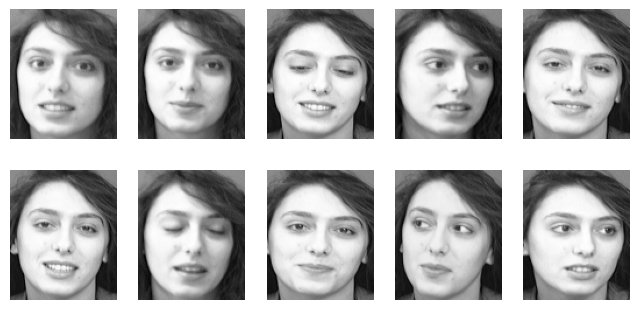

In [3]:
# visaulize 8th individual
id = 8
plt.figure(figsize=(8,8))
for j in range(1,11):
    img = read_image_file(f"faces/s{id}/{j}.pgm")
    plt.subplot(4, 5, j)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

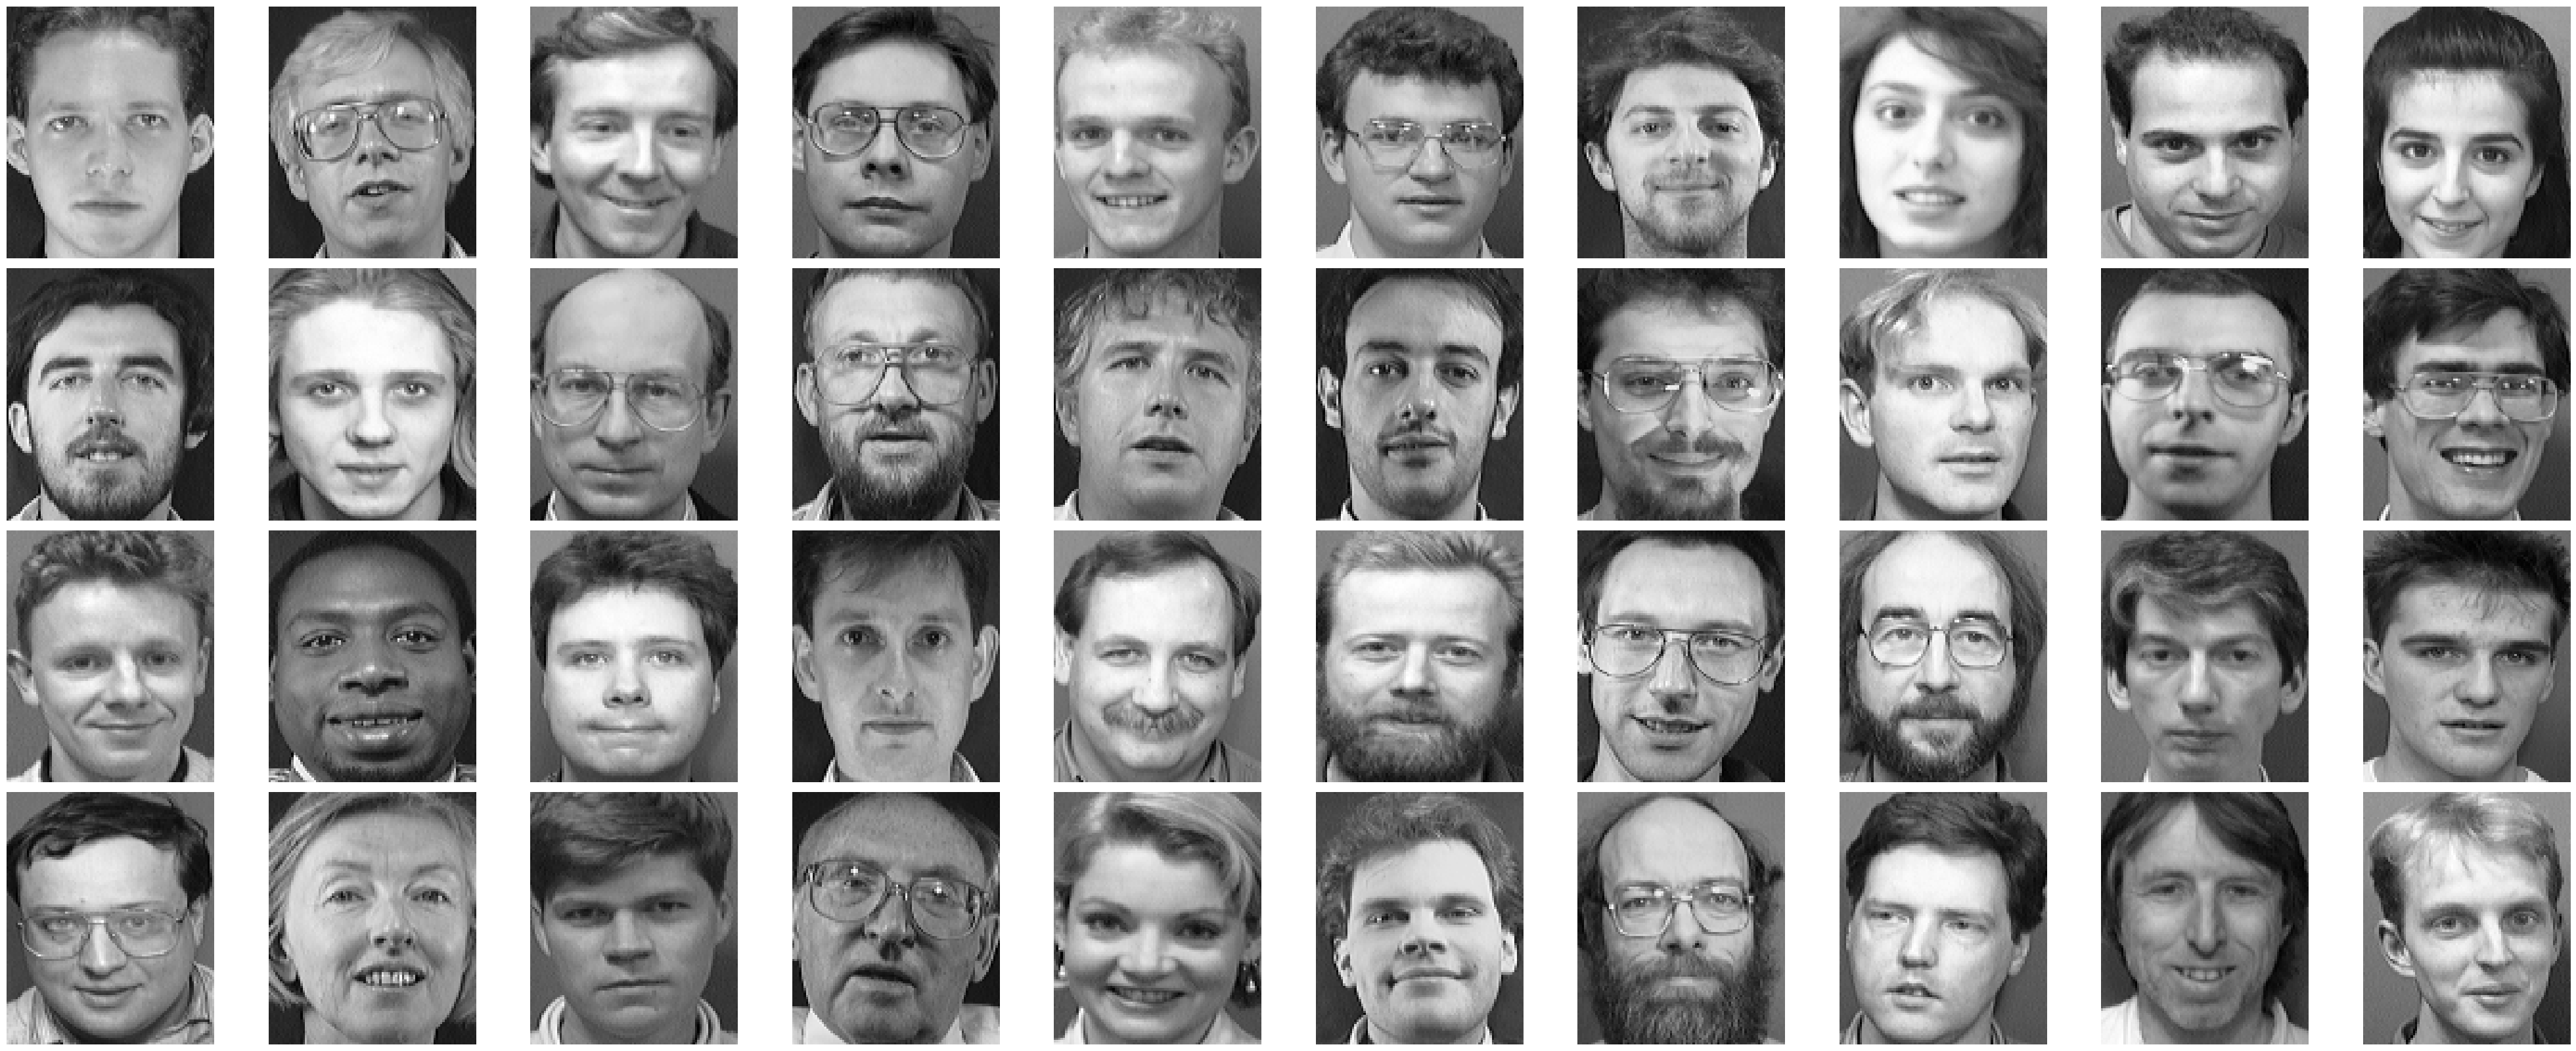

In [4]:
# visaulize 1st image of all individuals 
plt.figure(figsize=(40,40))
for id in range(1,41):
    img = read_image_file(f"faces/s{id}/{1}.pgm")
    plt.subplot(10,10,id)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

In [5]:
# 1-40 individuals, 10 images each, each image is 112x92

# Data Matrix
D = np.empty((0, 112*92), dtype=float) # number of images [rows] x number of pixels [columns]
# label vector
y = np.array([], dtype=int)

for id in range(1, 41):
    for j in range(1, 11):
        img = read_image_file(f"faces/s{id}/{j}.pgm")
        D = np.vstack((D, img.reshape(1, -1).astype(float)))
        y = np.append(y,id)

# shape of Data Matrix and label vector
print(D.shape, y.shape)

(400, 10304) (400,)


In [6]:
# splitting dataset into training and testing sets
odd_rows = np.array([i % 2 != 0 for i in range(400)]) 

# odds rows for taining set
D_train = D[odd_rows]
y_train = y[odd_rows]

# even rows for testing set
D_test = D[~ odd_rows]
y_test = y[~ odd_rows]

# shapes of resulting dataset
print(D_train.shape, y_train.shape)
print(D_test.shape, y_test.shape)

(200, 10304) (200,)
(200, 10304) (200,)


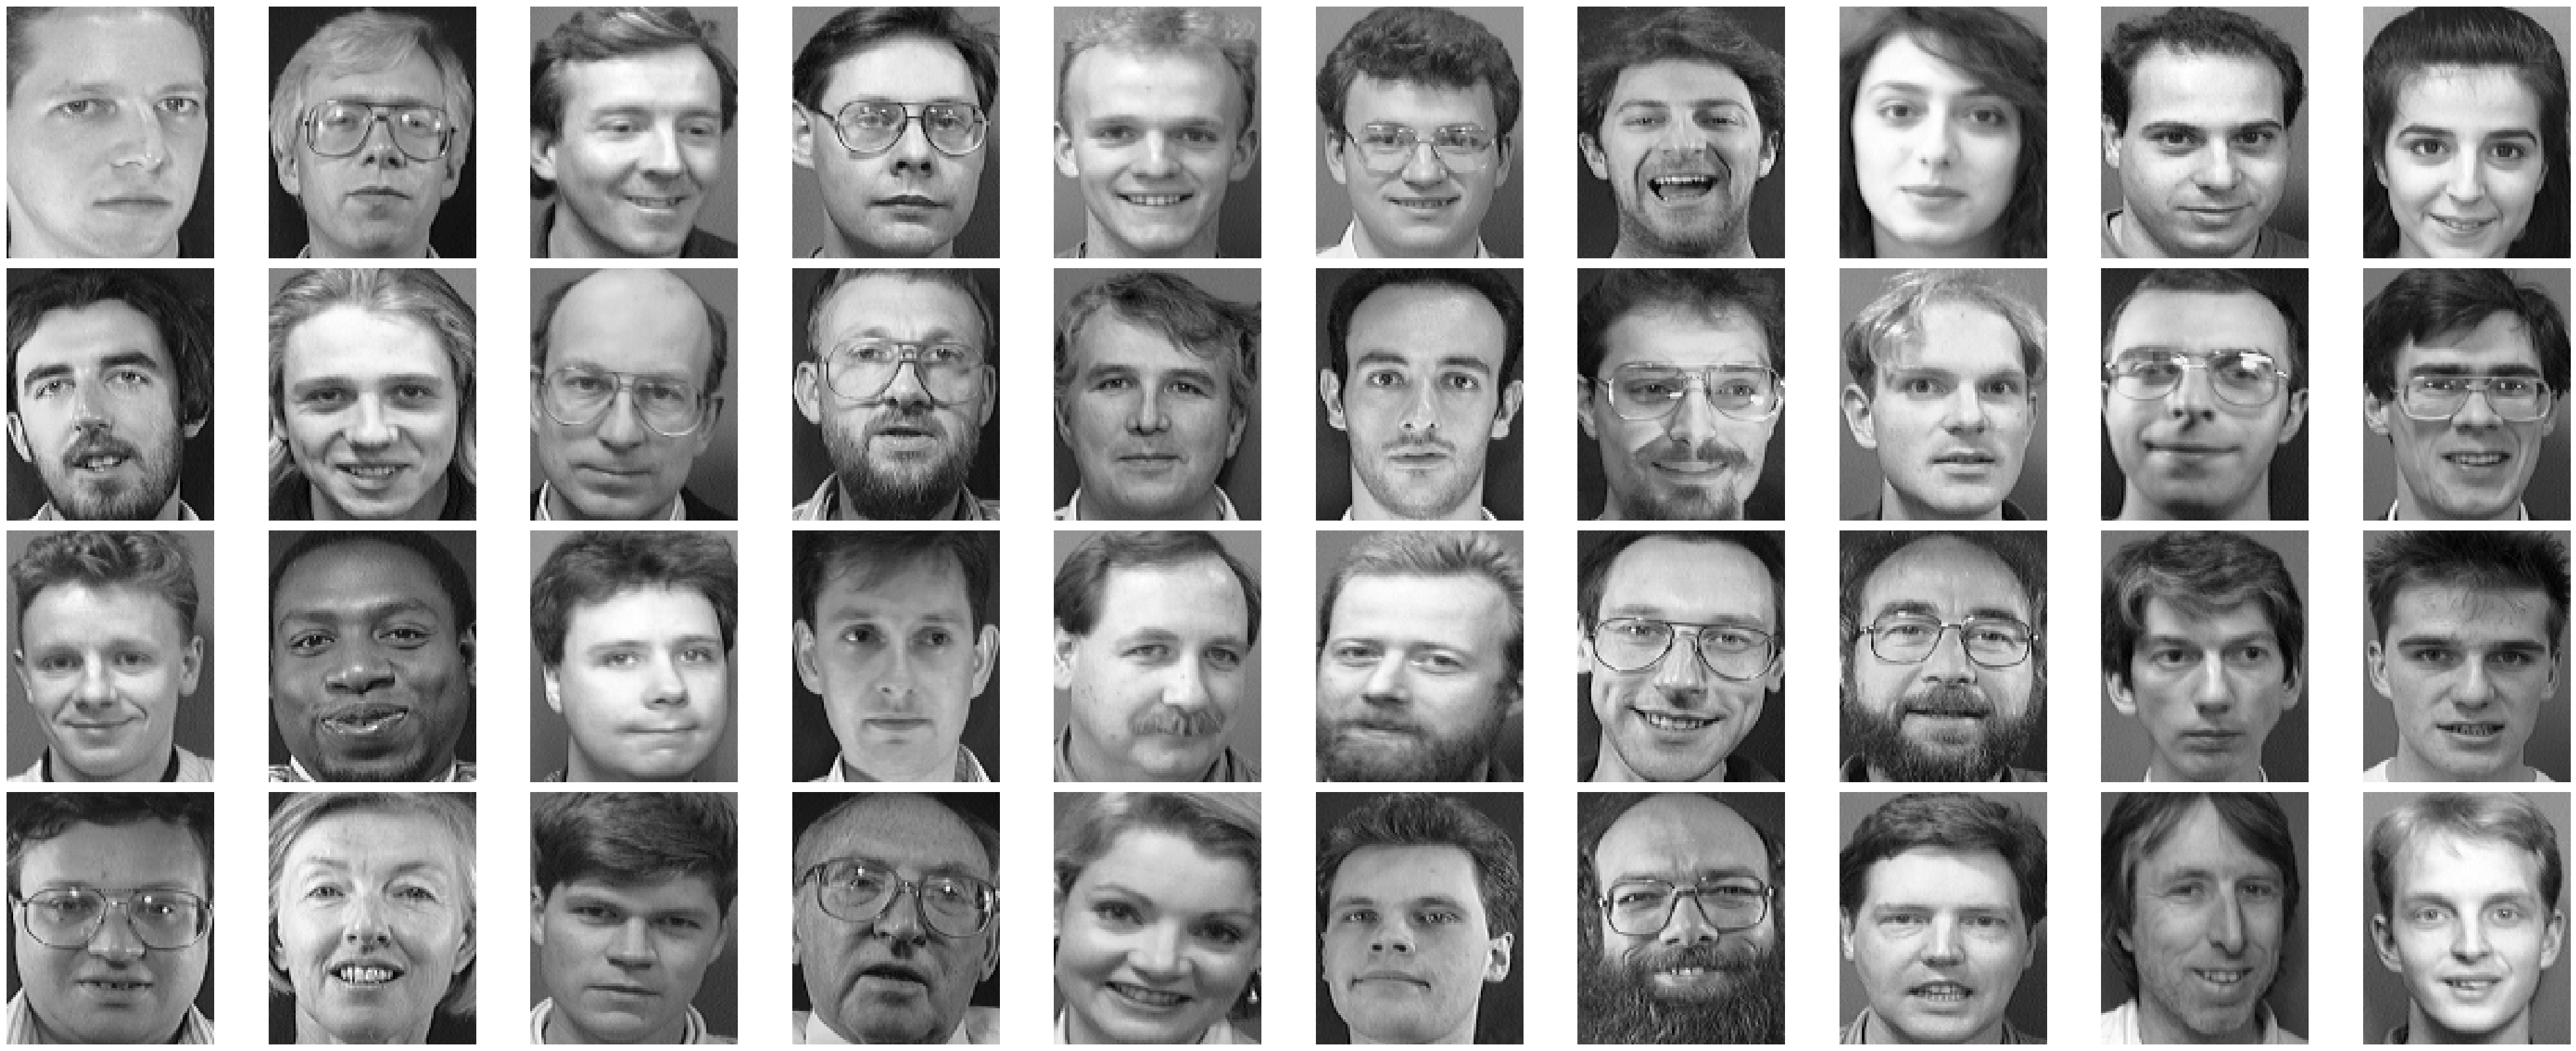

In [7]:
# visaulize 1st image of all individuals 
plt.figure(figsize=(40,40))
for id in range(1,41):
    img = D_train[(id-1)*5].reshape(112, 92)
    plt.subplot(10,10,id)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

### PCA

In [8]:
class PCA():
    def __init__(self, D_train, eigen_values=None, eigen_vectors=None):
        """
        Initialize PCA with data and optional eigenvalues and eigenvectors.
        :param Data: The data matrix.
        :param eigen_values: Optional eigenvalues.
        :param eigen_vectors: Optional eigenvectors.
        """
        self.D_train = D_train
        self.data_mean = np.mean(D_train, axis=0)
        
        if eigen_values is not None and eigen_vectors is not None:
            self.eigen_values = eigen_values
            self.eigen_vectors = eigen_vectors
        else:
            self.calc_eig()

    def project(self, D_test, alpha=0.85):
        """
        Project the data into the PCA space.
        :param D_test: The data to be projected.
        :param alpha: The percentage of variance to be explained.
        :return: The projected data.
        """
        centered_data = D_test - self.data_mean
        
        # check if alpha is between 0 and 1
        if alpha < 0 or alpha > 1:
            raise ValueError("alpha must be between 0 and 1")

        # count PCs from aplha
        num_components = self.count_num_components(alpha)

        # get projection matrix with num_components
        projection_mat = self.eigen_vectors[:,:num_components]

        # compute projected data
        return centered_data @ projection_mat
    
    def calc_eig(self):
        """
        Calculate the eigenvalues and eigenvectors of the covariance matrix.
        :return: The sorted eigenvalues and eigenvectors.
        """
        centered_data = self.D_train - self.data_mean
        # covariance matrix
        cov_mat = np.cov(centered_data, rowvar=False)

        # eigenvalues and eigenvectors
        self.eigen_values, self.eigen_vectors = np.linalg.eigh(cov_mat) 

        # sort indices
        sort_idx = np.argsort(self.eigen_values)[::-1]
        self.eigen_values  = self.eigen_values[sort_idx]
        self.eigen_vectors = self.eigen_vectors[:, sort_idx]

    def count_num_components(self, alpha):
        """
        Count the number of components needed to explain a certain percentage of variance.
        :param alpha: The percentage of variance to be explained.
        :return: The number of components needed.
        """
        total_var = np.sum(self.eigen_values)
        cumvar = np.cumsum(self.eigen_values) / total_var

        num_components = np.searchsorted(cumvar, alpha) + 1
        return num_components

In [9]:
# initialize PCA with no loaded eigenvalues and eigenvectors
pca_first = PCA(D_train)
# eigens
eigen_values, eigen_vectors = pca_first.eigen_values, pca_first.eigen_vectors

# save eigen values and vectors
np.save("eigen_values.npy", eigen_values)
np.save("eigen_vectors.npy", eigen_vectors)

In [10]:
# load eigen values and vectors
eigen_values = np.load("eigen_values.npy")
eigen_vectors = np.load("eigen_vectors.npy")

# initialize PCA with loaded eigen values and vectors
pca = PCA(D_train, eigen_values, eigen_vectors)

# check dimensions of eigen values and vectors
print(eigen_values.shape, eigen_vectors.shape)

(10304,) (10304, 10304)


In [11]:
# PCA with different aplhas
alphas = [.8, .85, .9, .95]
# D_projections {alpha: projected_data} 
D_projections = {}

for alpha in alphas:
    D_projections[alpha] = pca.project(D_train ,alpha)
    print(f"Dimensions at alpha= {alpha} : {D_projections[alpha].shape}")

Dimensions at alpha= 0.8 : (200, 37)
Dimensions at alpha= 0.85 : (200, 53)
Dimensions at alpha= 0.9 : (200, 77)
Dimensions at alpha= 0.95 : (200, 116)


In [12]:
# reconstruct images of some samples with different number of components
sample_faces = [0, 5]
num_components = [pca.count_num_components(alpha) for alpha in alphas]
reconstruct_images = {}
j = 0
for  k in sample_faces:
    for i in num_components:
        img = D_train[k] @ (eigen_vectors[:,:i] @ eigen_vectors[:,:i].T) + np.mean(D_train, axis=0)
        reconstruct_images[(k,i)] = img
        j = j + 1

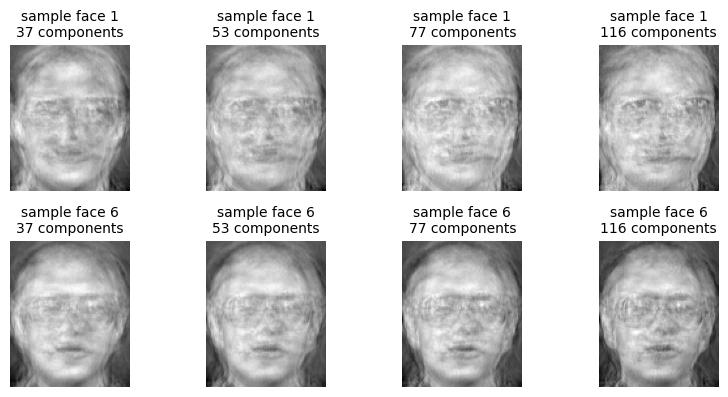

In [13]:
# visaulize reconstucted faces in PCA space
plt.figure(figsize=(8,8))
j = 1
for key, img in reconstruct_images.items():
        plt.subplot(4,4,j)
        plt.axis('off')
        plt.title(f"sample face {key[0]+1}\n{key[1]} components",fontsize=10)
        plt.imshow(img.reshape(112,92), cmap='gray')
        j = j + 1
plt.tight_layout()

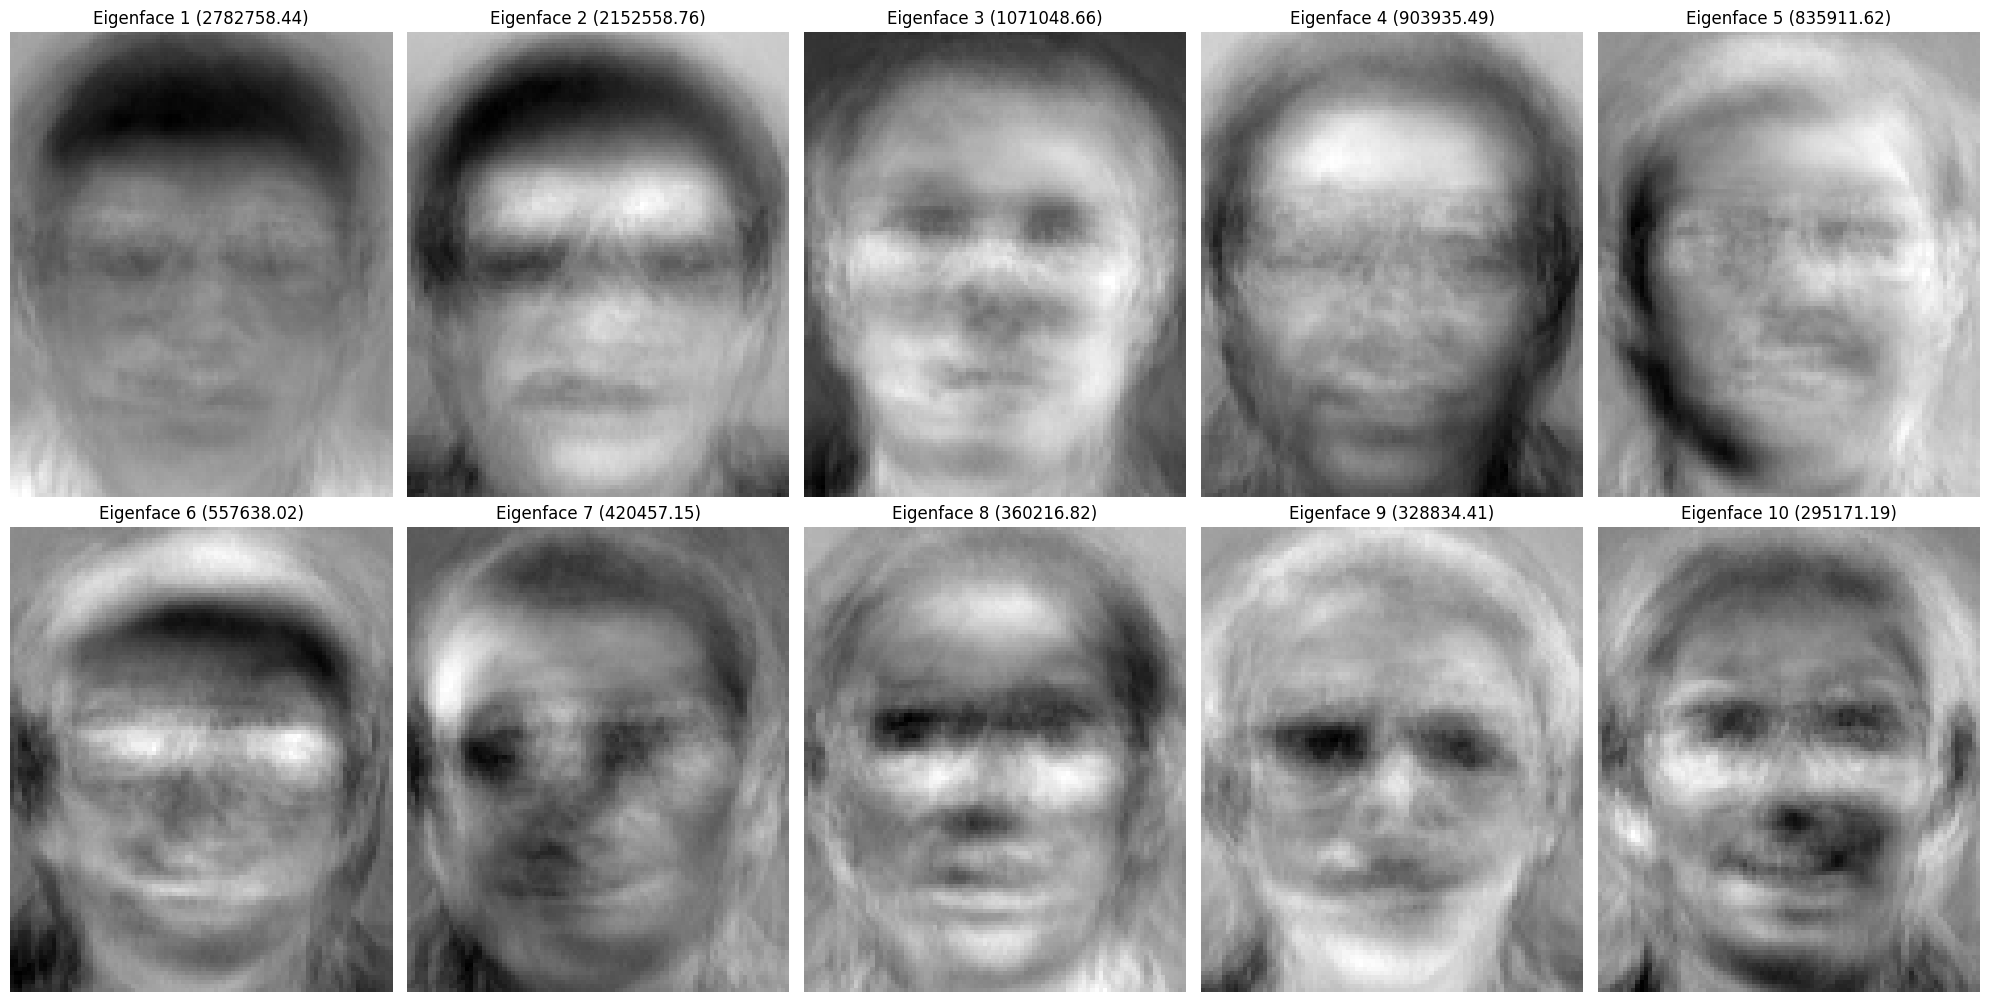

In [14]:
# Display the Eigenfaces with tup 10 eigen values
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(eigen_vectors[:, i].reshape(112, 92), cmap='gray')
    plt.title(f"Eigenface {i + 1} ({eigen_values[i]:.2f})")
plt.tight_layout()
plt.show()

### KMeans

In [15]:


class KMeans():
    def __init__(self, K, rand_start=20, max_iters = 1000):
        self.K = K
        self.rand_start = rand_start
        self.max_iters = max_iters
        self.centers = None
        self.r = None
    
    def setK(self, K):
        self.K = K

    def fit(self, D, y):
        r_best = np.array([])
        centers_best = None
        min_inertia = np.inf

        # apply kmeans (rand_start) times
        for i in range(self.rand_start):
            # set K random centeriods: centers (K, # features)
            centers = D[np.random.choice(D.shape[0], self.K, replace=False)]

            # intialize responsibility matrix(1-hot encode) with zeroes: r (# samples, k)
            r = np.zeros((D.shape[0], self.K), dtype=bool)
            
            r, centers = self.kmeans_loop(D, r, centers)

            # evaluate best cluster using interia
            err = self.inertia(D, r, centers)
            if  err < min_inertia:
                r_best = r
                centers_best = centers
                min_inertia = err
        
        self.map_clusters_to_labels(y, r_best)
        self.centers = centers_best
        self.r = r_best
        
    def kmeans_loop(self, D, r, centers):
        r_prev = r.copy()
        
        curr_iter = 0
        while curr_iter < self.max_iters:
            # compute Distance matrix for each data point x=D[i] with each center
            # assign cluster for each data point
            for i in range(len(D)):
                cluster = np.argmin(np.linalg.norm(centers - D[i], axis=1))
                r[i] = [j == cluster for j in range(self.K)]

            # test for convergence
            if np.array_equal(r_prev, r):
                break
            else:
                r_prev = r.copy()
            
            # refitting center of each cluster
            for j in range(self.K):
                if np.size(D[r[:,j]]) == 0:
                    centers[j] = D[np.random.randint(0, D.shape[0])]
                else: 
                    centers[j] = np.mean(D[r[:,j]], axis=0)
                    
            curr_iter += 1
        return r, centers
    
    def inertia(self, D, r, centers):
        # sum of Euclidean dist from each point to its cluster
        sum = 0
        for j in range(self.K):
            cluster_dis = np.linalg.norm(D[r[:,j]] - centers[j], axis=1)
            sum = sum + np.sum(cluster_dis)

        return sum
    
    def map_clusters_to_labels(self, y_train, r_train):
        """
        Determines the majority label for each cluster based on training labels.
        Should be called after fit.
        """
        self.cluster_label_map = {}
        for j in range(self.K):
            cluster_mask = r_train[:, j]
            labels_in_cluster = y_train[cluster_mask]
            # Do majority vote
            unique_labels, counts = np.unique(labels_in_cluster, return_counts=True)
            majority_label = unique_labels[np.argmax(counts)]
            self.cluster_label_map[j] = majority_label
    
    def predict(self, D_test):
        """
        Predicts labels for new data points based on learned centers and label mapping.

        Args:
            D_test (np.ndarray): New data points to predict (num_samples, num_features).

        Returns:
            np.ndarray: Predicted labels for D_new.
        """
        
        n_samples = D_test.shape[0]
        predicted_labels = np.zeros(n_samples, dtype=int)

        euclidean_dist = np.zeros((n_samples, self.K))
        for j in range(self.K):
            euclidean_dist[:, j] = np.sum((D_test - self.centers[j])**2, axis=1)

        # Find the index of the closest center for each point
        closest_cluster_indices = np.argmin(euclidean_dist, axis=1)

        # Assign labels based on the cluster-to-label map
        for i in range(n_samples):
            cluster_index = closest_cluster_indices[i]
            predicted_labels[i] = self.cluster_label_map.get(cluster_index, -1)

        return predicted_labels

### GMM

In [16]:
# Get max and min values in each D_projection
range_values = {}
for alpha in alphas:
    range_values[alpha] = (np.min(D_projections[alpha]), np.max(D_projections[alpha]))
    print(f"Range of values at alpha= {alpha} : {range_values[alpha]}")

Range of values at alpha= 0.8 : (-3741.212235194231, 3681.0315730764023)
Range of values at alpha= 0.85 : (-3741.212235194231, 3681.0315730764023)
Range of values at alpha= 0.9 : (-3741.212235194231, 3681.0315730764023)
Range of values at alpha= 0.95 : (-3741.212235194231, 3681.0315730764023)


In [17]:
# Standardize the projections
D_projections_standardized = {}
for alpha in alphas:
    D_projections_standardized[alpha] = (D_projections[alpha] - np.mean(D_projections[alpha], axis=0)) / np.std(D_projections[alpha], axis=0)

In [18]:
class GMM():
    def __init__(self, clusters = 40, max_iter = 100, random_starts = 10, tol = 1e-4):
        """
        Initialize GMM with number of clusters, max iterations and random starts.
        :param clusters: The number of clusters.
        :param max_iter: The maximum number of iterations.
        :param random_starts: The number of random starts.
        :param tol: The tolerance for convergence.
        """
        self.tol = tol
        self.max_iter = max_iter
        self.clusters = clusters
        self.random_starts = random_starts
        self.component_label_map = None
        

    def fit(self, X, y_train):
        """
        Fit the GMM to the data.
        :param X: The data matrix.
        """
        self.n_samples, self.n_features = X.shape
        
        # best random start
        best_ll = -np.inf
        best_μs = None
        best_Σs = None
        best_πs = None
        best_start = None

        for rsrt in range(self.random_starts):
            
            # initialize means randomly
            self.μs = np.random.randn(self.clusters, self.n_features)
            # initialize weights and covariance matrices
            self.πs = np.ones(self.clusters) / self.clusters
            self.Σs = np.array([np.eye(self.n_features)] * self.clusters)

            ll = 0 # log likelihood
            
            for iter in range(self.max_iter):
                # E-step
                rs, nll = self.e_step(X)

                # M-step
                self.m_step(X, rs)

                # check for convergence
                if abs(nll - ll) < self.tol:
                    print(f"Converged at iteration {iter} for random start {rsrt}")
                    break

                ll = nll

            if ll > best_ll:
                best_ll = ll
                best_μs = self.μs.copy()
                best_Σs = self.Σs.copy()
                best_πs = self.πs.copy()
                best_start = rsrt

        # set the best parameters
        self.μs = best_μs
        self.Σs = best_Σs
        self.πs = best_πs
        r, _ = self.e_step(X)
        self.map_components_to_labels(y_train, r)

        print("Model fitted successfully.")
        print(f"Best log likelihood: {best_ll}")
        print(f"Best random start: {best_start}")

    def e_step(self, X):
        """
        E-step of the EM algorithm.
        :param X: The data matrix.
        :return: The responsibilities.
        """
        # initialize responsibilities [[r11, r12, ...], [r21, r2, ...], ..., [rN1, rN2, ..., rNC]], N samples, C clusters
        log_rs = np.zeros((self.n_samples, self.clusters))

        # calculate log responsibilities
        for k in range(self.clusters):
            log_rs[:, k] = np.log(self.πs[k] + 1e-15) + self.multivariate_gaussian(X, self.μs[k], self.Σs[k])

        # normalize log responsibilities by subtracting the 
        # log_rs -= np.log(np.exp(log_rs).sum(axis=1, keepdims=True)) 
        # this defeats the purpose of using log to prevent underflow

        # normalize log responsibilities using logsumexp
        log_evidence = logsumexp(log_rs, axis=1, keepdims=True)
        log_rs = log_rs - log_evidence

        return np.exp(log_rs), np.sum(log_evidence)

    def m_step(self, X, rs):
        """
        M-step of the EM algorithm.
        :param X: The data matrix.
        :param rs: The responsibilities.
        """

        #print shapes

        # calculate sum of responsibilities per cluster
        Nk = rs.sum(axis=0)
        Nk_stable = Nk + 1e-10 # to avoid division by zero

        # update weights of clusters
        self.πs = Nk / self.n_samples

        # sum_πs = np.sum(self.πs)

        # update means of clusters
        self.μs = rs.T @ X / Nk_stable[:, np.newaxis]

        # print(f"X shape: {X.shape}")
        # print(f"rs shape: {rs.shape}")
        # print(f"πs shape: {self.πs.shape}")
        # print(f"μs shape: {self.μs.shape}")
        # print(f"Σs shape: {self.Σs.shape}")
        # print(f"Nk shape: {Nk.shape}")

        # update covariance matrices of clusters
        self.Σs = np.zeros((self.clusters, self.n_features, self.n_features))
        for k in range(self.clusters):
            diff = X - self.μs[k] 
            self.Σs[k] = (rs[:, k][:, np.newaxis] * diff).T @ diff / Nk_stable[k]
            self.Σs[k] = (self.Σs[k] + self.Σs[k].T) / 2 # make sure Σ is symmetric
            self.Σs[k] += np.eye(self.n_features) * 1e-10 # to avoid singular matrix

    def multivariate_gaussian(self, X, μ, Σ):
        """
        Multivariate Gaussian distribution.
        :param X: The data matrix.
        :param μ: The mean vector.
        :param Σ: The covariance matrix.
        :return: The pdf.
        """
        d = X.shape[1] # number of features

        # calculate determinant of Σ
        log_det_Σ = np.log(np.linalg.det(Σ) + 1e-18) # to avoid singular matrix
        # calculate first term
        log_first_term = -(d/2) * np.log(2 * np.pi) - 0.5 * log_det_Σ
        
        # calculate inverse of Σ
        Σ_inv = np.linalg.inv(Σ)

        # initialize log pdfs [log(N(X0|μ,Σ)),log(N(X1|μ,Σ)), ...]
        log_pdfs = np.zeros(X.shape[0], dtype=float)

        for i in range(X.shape[0]):
            # calculate difference
            diff = (X[i] - μ)[:, np.newaxis]
            # calculate second term
            log_second_term = -0.5 * diff.T @ Σ_inv @ diff
            # calculate log pdf
            log_pdfs[i] = log_first_term + log_second_term[0, 0]

        return log_pdfs
    
    def map_components_to_labels(self, y_train, r_train):
        """
        Determines the majority label for each GMM component based on training labels
        and responsibilities using hard assignment (argmax).

        Args:
            y_train (np.ndarray): True labels for the training data.
            r_train (np.ndarray): Responsibilities from fitting on training data.
            num_subjects (int): Number of unique classes/subjects.
        """

        self.component_label_map = {}
        # Determine the most likely component for each training sample
        assigned_component = np.argmax(r_train, axis=1)

        for k in range(self.clusters):
            # Find training samples assigned to this component
            component_mask = (assigned_component == k)
            if np.sum(component_mask) > 0:
                labels_in_component = y_train[component_mask]
                # Do majority vote
                unique_labels, counts = np.unique(labels_in_component, return_counts=True)
                majority_label = unique_labels[np.argmax(counts)]
                self.component_label_map[k] = majority_label
            else:
                self.component_label_map[k] = -1


    def predict(self, X):
        """
        Predicts class labels for new data X based on learned GMM parameters
        and the component-to-label map.

        Args:
            X (np.ndarray): New data points to predict (num_samples, num_features).

        Returns:
            np.ndarray: Predicted class labels for X.
        """
        # E-step for the new data X using the learned parameters
        rs_new, _ = self.e_step(X)

        # Find the most likely component for each new data point
        predicted_component_indices = np.argmax(rs_new, axis=1)

        # Map component indices to class labels
        n_samples = X.shape[0]
        predicted_labels = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            component_index = predicted_component_indices[i]
            predicted_labels[i] = self.component_label_map.get(component_index, -1)

        return predicted_labels


# Autoencoder

In [19]:
IMG_HEIGHT = 112
IMG_WIDTH = 92
INPUT_SIZE = IMG_WIDTH*IMG_HEIGHT

In [20]:
class BaseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

    def encode(self, x):
        raise NotImplementedError

    def decode(self, z):
        raise NotImplementedError

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

    def project(self, D_numpy: np.ndarray):
        """Encodes input numpy array into the latent space."""
        raise NotImplementedError

    def reconstruct(self, x):
        """Reconstructs input data from the autoencoder."""
        self.eval()
        with torch.no_grad():
            x_recon = self.forward(x)
        return x_recon

In [21]:
class FullyConnectedAutoencoder(BaseAutoencoder):
    """
    Simplified Fully Connected Autoencoder.
    Assumes flattened input, Sigmoid output, optional BN.

    Args:
        input_dim (int): Dimension of the flattened input data (e.g., 92*112).
        latent_dim (int): Dimension of the bottleneck layer (encoded representation).
        hidden_dims (list): List of integers specifying the number of neurons in each hidden layer
                           of the encoder. The decoder will mirror this structure.
        use_batch_norm (bool): Whether to use Batch Normalization in hidden layers.
    """
    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 hidden_dims: list = [512, 256, 128]):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims

        encoder_layers = []
        last_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(last_dim, h_dim))
            encoder_layers.append(nn.BatchNorm1d(h_dim))
            encoder_layers.append(nn.ReLU())
            last_dim = h_dim
        encoder_layers.append(nn.Linear(last_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, last_dim))
        decoder_layers.append(nn.BatchNorm1d(last_dim))
        decoder_layers.append(nn.ReLU())

        for h_dim in reversed(hidden_dims[:-1]):
            decoder_layers.append(nn.Linear(last_dim, h_dim))
            decoder_layers.append(nn.BatchNorm1d(h_dim))
            decoder_layers.append(nn.ReLU())
            last_dim = h_dim

        decoder_layers.append(nn.Linear(last_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """ Encodes input data into the latent space.
        Args:
            x (torch.Tensor): Input data.[B, H*W]
        Returns:
            torch.Tensor: Encoded representation. [B, latent_dim]
        """
        return self.encoder(x)

    def decode(self, z):
        """ Decodes latent representation back to input space.
        Args:
            z (torch.Tensor): Latent representation. [B, latent_dim]
        Returns:
            torch.Tensor: Reconstructed data. [B, H*W]
        """
        return self.decoder(z)
    
    
    def project(self, D_numpy: np.ndarray):
        """
        Encodes numpy data into the latent space. Handles tensor conversion.

        Args:
            D_numpy (np.ndarray): Input data as a NumPy array.
                                  Shape [n_samples, input_dim].

        Returns:
            np.ndarray: Latent space representation as a NumPy array.
        """
        self.eval()

        # Determine device model is on
        device = next(self.parameters()).device

        data_tensor = torch.from_numpy(D_numpy).float() / 255.0
        data_tensor = data_tensor.to(device)

        data_tensor = data_tensor.view(data_tensor.size(0), -1)

        with torch.no_grad():
            z_tensor = self.encode(data_tensor)

        z_numpy = z_tensor.cpu().numpy()
        return z_numpy

In [22]:
class ConvolutionalAutoencoder(BaseAutoencoder):
    """
    Convolutional Autoencoder with a fixed 3-layer architecture.
    Assumes input/output tensors are [Batch, Height, Width].
    Internally adds/removes channel dimension for Conv/BN layers.
    Always uses BatchNorm2d and ReLU activation in hidden layers.
    Uses Sigmoid activation for the final output.

    Args:
        img_height (int): Height of the input image.
        img_width (int): Width of the input image.
        latent_dim (int): Dimension of the bottleneck layer (encoded representation).
    """
    def __init__(self,
                 img_height: int,
                 img_width: int,
                 latent_dim: int):
        super().__init__()

        self.img_height = img_height
        self.img_width = img_width
        self.latent_dim = latent_dim

        # --- Encoder ---
        # Input: [B, 1, H, W]
        encoder_layers = []
        # Layer 1: 1 -> 16 channels
        encoder_layers.append(nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1))
        encoder_layers.append(nn.BatchNorm2d(16))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # H/2, W/2

        # Layer 2: 16 -> 32 channels
        encoder_layers.append(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1))
        encoder_layers.append(nn.BatchNorm2d(32))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # H/4, W/4

        # Layer 3: 32 -> 64 channels
        encoder_layers.append(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1))
        encoder_layers.append(nn.BatchNorm2d(64))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # H/8, W/8
        # Output: [B, 64, H/8, W/8]

        self.encoder_conv = nn.Sequential(*encoder_layers)

        # Calculate the flattened size after conv layers dynamically
        self._flattened_size, self._final_conv_h, self._final_conv_w = self._get_flattened_size_and_shape(
            img_height, img_width
        )
        self._final_conv_channels = 64 # Output channels of the last encoder conv layer
        print(f"Encoder output shape before flatten: (Batch, {self._final_conv_channels}, {self._final_conv_h}, {self._final_conv_w})")
        print(f"Calculated flattened size after encoder conv layers: {self._flattened_size}")

        # --- Bottleneck ---
        self.fc_encoder = nn.Linear(self._flattened_size, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, self._flattened_size)

        # --- Build Decoder ---
        # Input: [B, 64, H/8, W/8] (after reshape)
        decoder_layers = []
        # Layer 1: 64 -> 32 channels, Upsample x2
        decoder_layers.append(nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0))
        decoder_layers.append(nn.BatchNorm2d(32))
        decoder_layers.append(nn.ReLU()) # Output: [B, 32, H/4, W/4]

        # Layer 2: 32 -> 16 channels, Upsample x2
        decoder_layers.append(nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0))
        decoder_layers.append(nn.BatchNorm2d(16))
        decoder_layers.append(nn.ReLU()) # Output: [B, 16, H/2, W/2]

        # Layer 3: 16 -> 1 channel, Upsample x2
        decoder_layers.append(nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=0))
        # Output: [B, 1, H, W]

        decoder_layers.append(nn.Sigmoid())

        self.decoder_conv = nn.Sequential(*decoder_layers)

    def _get_flattened_size_and_shape(self, H, W):
        """ Helper function to calculate the flattened size and shape after conv layers """
        dummy_input = torch.zeros(1, 1, H, W)
        with torch.no_grad():
            output = self.encoder_conv(dummy_input)
        flattened_size = int(torch.numel(output))
        final_h = output.size(2)
        final_w = output.size(3)
        return flattened_size, final_h, final_w

    def encode(self, x):
        """ Encodes input data into the latent space.
        Args:
            x (torch.Tensor): Input data. [B, H, W]
        Returns:
            torch.Tensor: Encoded representation. [B, latent_dim]
        """
        x = x.unsqueeze(1) # -> [B, 1, H, W]
        features = self.encoder_conv(x)
        features_flat = features.view(features.size(0), -1)
        z = self.fc_encoder(features_flat) # [B, latent_dim]
        return z

    def decode(self, z):
        """ Decodes latent representation back to input space.
        Args:
            z (torch.Tensor): Latent representation. [B, latent_dim]
        Returns:
            torch.Tensor: Reconstructed data. [B, H*W]
        """
        features_flat = self.fc_decoder(z) # -> [B, flattened_size]
        # Reshape back to the shape before flattening in the encoder
        features = features_flat.view(z.size(0), self._final_conv_channels, self._final_conv_h, self._final_conv_w)
        # -> [B, C_final, H_final, W_final]

        reconstruction_with_channel = self.decoder_conv(features) # [B, 1, H_out, W_out]

        if reconstruction_with_channel.size(2) != self.img_height or reconstruction_with_channel.size(3) != self.img_width:
            reconstruction_with_channel = F.interpolate(reconstruction_with_channel,
                                                         size=(self.img_height, self.img_width),
                                                         mode='bilinear', align_corners=False)

        reconstruction = reconstruction_with_channel.squeeze(1) # [B, H, W]
        return reconstruction
    
    
    def project(self, D_numpy: np.ndarray):
        """
        Encodes numpy data into the latent space. Handles tensor conversion.

        Args:
            D_numpy (np.ndarray): Input data as a NumPy array.
                                  Shape [n_samples, H*W] or [n_samples, H, W].

        Returns:
            np.ndarray: Latent space representation as a NumPy array.
        """
        self.eval()

        # Determine device model is on
        device = next(self.parameters()).device

        data_tensor = torch.from_numpy(D_numpy).float() / 255.0
        data_tensor = data_tensor.to(device)

        data_tensor = data_tensor.view(-1, self.img_height, self.img_width)
        with torch.no_grad():
            z_tensor = self.encode(data_tensor)

        z_numpy = z_tensor.cpu().numpy()
        return z_numpy

In [23]:
class NumpyFaceDataset(Dataset):
    """
    PyTorch Dataset wrapping NumPy arrays D_train and y_train.
    Handles reshaping and normalization.

    Args:
        D (np.ndarray): Data array, shape (num_samples, flattened_dim)
                        Pixel values are in [0, 255].
        y (np.ndarray): Label array, shape (num_samples,).
        img_h (int): Target image height for reshaping.
        img_w (int): Target image width for reshaping.
        return_flat (bool): If True, return flattened images [H*W].
                            If False, return reshaped images [H, W].
    """
    def __init__(self, D: np.ndarray, y: np.ndarray, img_h: int, img_w: int, return_flat: bool = False):
        self.img_h = img_h
        self.img_w = img_w
        self.return_flat = return_flat

        self.data = torch.from_numpy(D).float() / 255.0
        self.labels = torch.from_numpy(y).long() # Use long for class labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img_flat = self.data[idx] # Shape [H*W]
        label = self.labels[idx]

        if self.return_flat:
            return img_flat, label
        else:
            img_reshaped = img_flat.view(self.img_h, self.img_w)
            return img_reshaped, label

In [24]:
def visualize_reconstructions(model: BaseAutoencoder,
                              dataloader: DataLoader,
                              device: torch.device,
                              n_samples: int = 5): # Removed is_conv
    """
    Visualizes original and reconstructed images from a dataloader.

    Args:
        model: The trained autoencoder model (ConvolutionalAutoencoder or FullyConnectedAutoencoder).
        dataloader: DataLoader providing batches of (image, label) tuples.
        device: The device the model and data are on ('cuda' or 'cpu').
        n_samples: Number of samples to visualize.
    """
    model.eval()
    originals = []
    reconstructions = []

    is_conv_model = isinstance(model, ConvolutionalAutoencoder)
    print(f"Visualizer detected model type: {'Convolutional' if is_conv_model else 'FullyConnected'}")

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, _ = batch 
            images = images.to(device)

            recon = model(images)

            if images.dim() == 2: 
                originals.append(images.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH))
            else:
                originals.append(images.cpu())

            if recon.dim() == 2:
                reconstructions.append(recon.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH))
            else:
                reconstructions.append(recon.cpu())

            current_total = sum(batch_orig.size(0) for batch_orig in originals)
            if current_total >= n_samples:
                 break


    # Concatenate batches and select n_samples
    originals = torch.cat(originals, dim=0)[:n_samples]
    reconstructions = torch.cat(reconstructions, dim=0)[:n_samples]

    plt.figure(figsize=(n_samples * 2, 4))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples, i + 1)
        plt.imshow(originals[i].numpy()*255, cmap='gray')
        ax.set_title("Original"); ax.axis('off')

        ax = plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(reconstructions[i].numpy()*255, cmap='gray')
        ax.set_title("Reconstructed"); ax.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
def train_autoencoder(model: BaseAutoencoder,
                      train_loader: DataLoader,
                      val_loader: DataLoader, # Added validation loader
                      criterion: nn.Module,
                      optimizer: torch.optim.Optimizer,
                      epochs: int,
                      device: torch.device):
    """
    Trains an autoencoder model.

    Args:
        model: The autoencoder model to train.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        criterion: The loss function (e.g., nn.MSELoss).
        optimizer: The optimizer (e.g., Adam).
        epochs: Number of epochs to train for.
        device: The device to train on ('cuda' or 'cpu').

    Returns:
        tuple: A tuple containing two lists: (train_loss_history, val_loss_history)
    """
    train_loss_history = []
    val_loss_history = []

    print(f"\n--- Starting Training on {device} for {epochs} epochs ---")
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        for i, (img, _) in enumerate(train_loader): # Unpack and ignore labels
            img = img.to(device)

            optimizer.zero_grad()
            recon_img = model(img)
            loss = criterion(recon_img, img)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * img.size(0) # Accumulate loss scaled by batch size

        epoch_train_loss = running_train_loss / len(train_loader.dataset) # Average loss over dataset size
        train_loss_history.append(epoch_train_loss)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for img, _ in val_loader: # Unpack and ignore labels
                img = img.to(device)
                recon_img = model(img)
                loss = criterion(recon_img, img)
                running_val_loss += loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

    print("--- Training Finished ---")
    plot_loss_history(train_loss_history, val_loss_history)
    return train_loss_history, val_loss_history


def plot_loss_history(train_loss, val_loss, title="Model Loss"):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 128
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
D_train_ae, D_val_ae, y_train_ae, y_val_ae = train_test_split(
        D_train, y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train
    )


--- Starting Training on cuda for 100 epochs ---
Epoch [1/100], Train Loss: 0.033841, Val Loss: 0.039768
Epoch [2/100], Train Loss: 0.021683, Val Loss: 0.035183
Epoch [3/100], Train Loss: 0.016808, Val Loss: 0.037674
Epoch [4/100], Train Loss: 0.015084, Val Loss: 0.032851
Epoch [5/100], Train Loss: 0.013399, Val Loss: 0.027172
Epoch [6/100], Train Loss: 0.013217, Val Loss: 0.018919
Epoch [7/100], Train Loss: 0.012508, Val Loss: 0.015675
Epoch [8/100], Train Loss: 0.011681, Val Loss: 0.013248
Epoch [9/100], Train Loss: 0.011169, Val Loss: 0.012659
Epoch [10/100], Train Loss: 0.010630, Val Loss: 0.012300
Epoch [11/100], Train Loss: 0.010963, Val Loss: 0.012164
Epoch [12/100], Train Loss: 0.010004, Val Loss: 0.011956
Epoch [13/100], Train Loss: 0.010042, Val Loss: 0.011743
Epoch [14/100], Train Loss: 0.009189, Val Loss: 0.011332
Epoch [15/100], Train Loss: 0.009411, Val Loss: 0.011404
Epoch [16/100], Train Loss: 0.008753, Val Loss: 0.011235
Epoch [17/100], Train Loss: 0.008508, Val Loss:

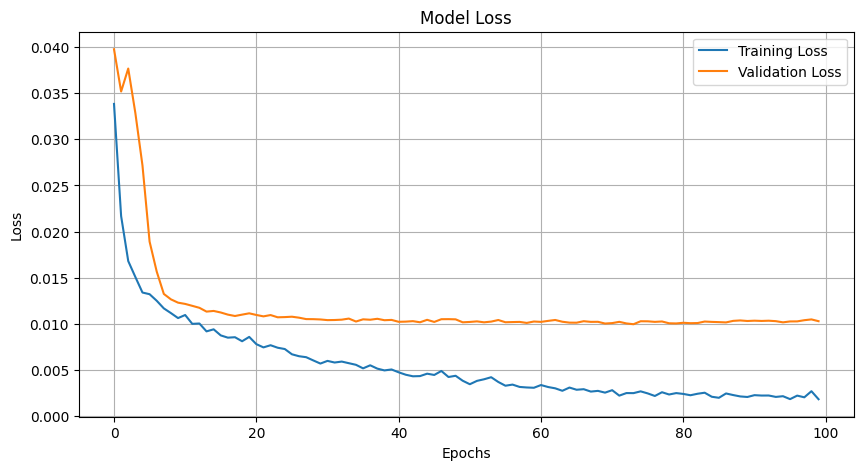

In [27]:
fc_model = FullyConnectedAutoencoder(
        input_dim=INPUT_SIZE,
        latent_dim=LATENT_DIM,
        hidden_dims=[1024, 512, 256]
    ).to(device)

# Create Dataset and DataLoader for FCAE (return_flat=True) using only training data
fc_train_dataset = NumpyFaceDataset(D_train_ae, y_train_ae, IMG_HEIGHT, IMG_WIDTH, return_flat=True)
fc_train_loader = DataLoader(fc_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
fc_val_dataset = NumpyFaceDataset(D_val_ae, y_val_ae, IMG_HEIGHT, IMG_WIDTH, return_flat=True)
fc_val_loader = DataLoader(fc_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
fc_test_dataset = NumpyFaceDataset(D_test, y_test, IMG_HEIGHT, IMG_WIDTH, return_flat=True)
fc_test_loader = DataLoader(fc_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

fc_optimizer = optim.Adam(fc_model.parameters(), lr=LEARNING_RATE)

fc_train_loss = train_autoencoder(
    model=fc_model,
    train_loader=fc_train_loader,
    val_loader=fc_val_loader,
    criterion=criterion,
    optimizer=fc_optimizer,
    epochs=EPOCHS,
    device=device
)

Visualizer detected model type: FullyConnected


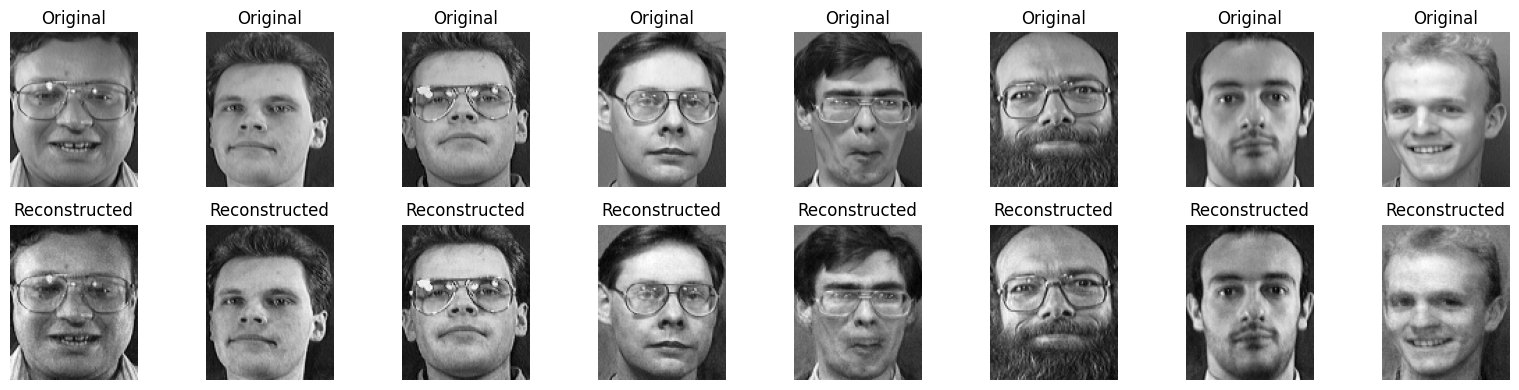

In [28]:
visualize_reconstructions(fc_model, fc_train_loader, device, n_samples=8)

Visualizer detected model type: FullyConnected


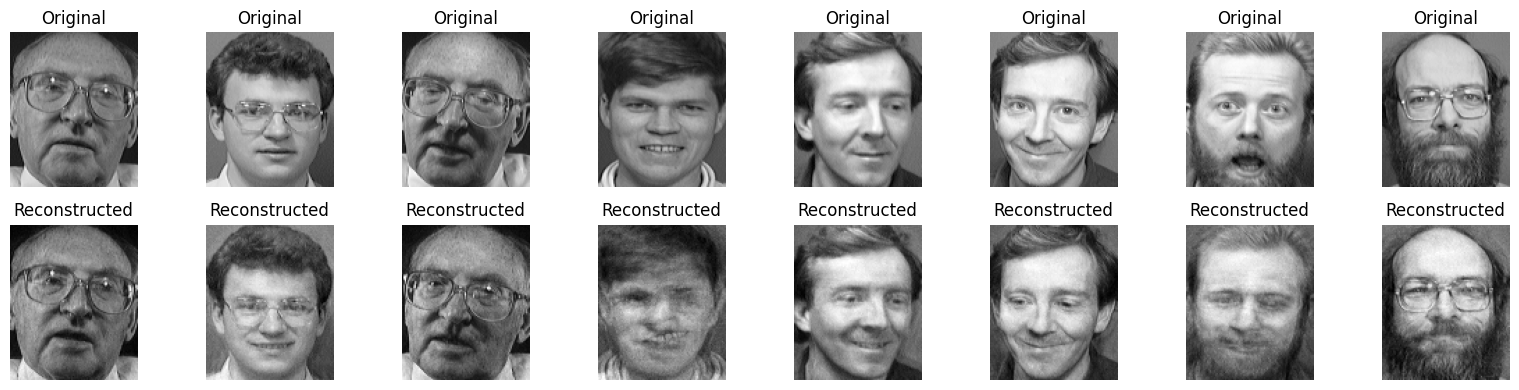

In [29]:
visualize_reconstructions(fc_model, fc_test_loader, device, n_samples=8)

Encoder output shape before flatten: (Batch, 64, 14, 11)
Calculated flattened size after encoder conv layers: 9856

--- Starting Training on cuda for 200 epochs ---
Epoch [1/200], Train Loss: 0.045920, Val Loss: 0.048734
Epoch [2/200], Train Loss: 0.031101, Val Loss: 0.044587
Epoch [3/200], Train Loss: 0.026721, Val Loss: 0.038416
Epoch [4/200], Train Loss: 0.024219, Val Loss: 0.030431
Epoch [5/200], Train Loss: 0.022155, Val Loss: 0.024704
Epoch [6/200], Train Loss: 0.020050, Val Loss: 0.021083
Epoch [7/200], Train Loss: 0.018457, Val Loss: 0.019431
Epoch [8/200], Train Loss: 0.016934, Val Loss: 0.016462
Epoch [9/200], Train Loss: 0.015645, Val Loss: 0.015212
Epoch [10/200], Train Loss: 0.014691, Val Loss: 0.014548
Epoch [11/200], Train Loss: 0.013882, Val Loss: 0.014294
Epoch [12/200], Train Loss: 0.013206, Val Loss: 0.013274
Epoch [13/200], Train Loss: 0.012624, Val Loss: 0.012656
Epoch [14/200], Train Loss: 0.012368, Val Loss: 0.012241
Epoch [15/200], Train Loss: 0.011698, Val Loss

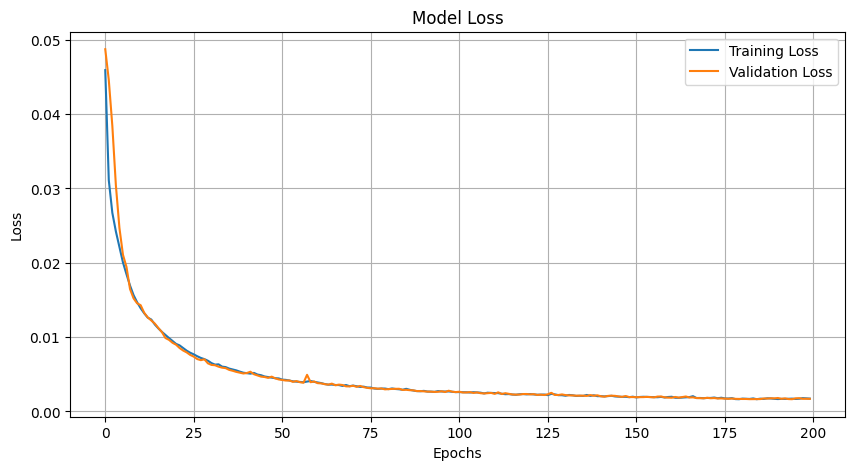

In [30]:
conv_model = ConvolutionalAutoencoder(
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        latent_dim=LATENT_DIM,
    ).to(device)

conv_train_dataset = NumpyFaceDataset(D_train, y_train, IMG_HEIGHT, IMG_WIDTH, return_flat=False)
conv_train_loader = DataLoader(conv_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
conv_val_dataset = NumpyFaceDataset(D_val_ae, y_val_ae, IMG_HEIGHT, IMG_WIDTH, return_flat=False)
conv_val_loader = DataLoader(conv_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
conv_test_dataset = NumpyFaceDataset(D_test, y_test, IMG_HEIGHT, IMG_WIDTH, return_flat=False)
conv_test_loader = DataLoader(conv_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

conv_optimizer = optim.Adam(conv_model.parameters(), lr=LEARNING_RATE)
conv_train_loss = train_autoencoder(
    model=conv_model,
    train_loader=conv_train_loader,
    val_loader=conv_val_loader,
    criterion=criterion,
    optimizer=conv_optimizer,
    epochs=200,
    device=device
)

Visualizer detected model type: Convolutional


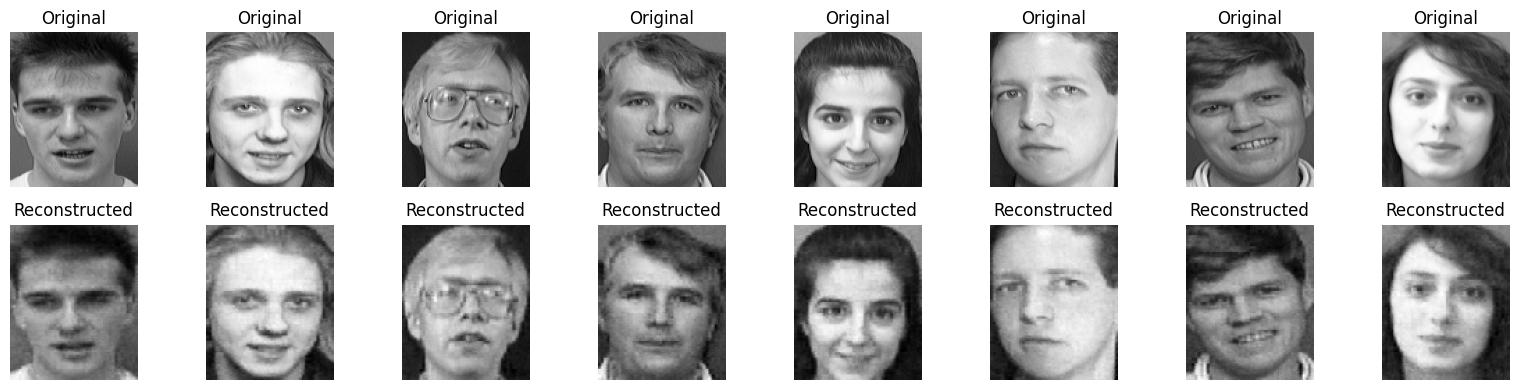

In [31]:
visualize_reconstructions(conv_model, conv_train_loader, device, n_samples=8)

Visualizer detected model type: Convolutional


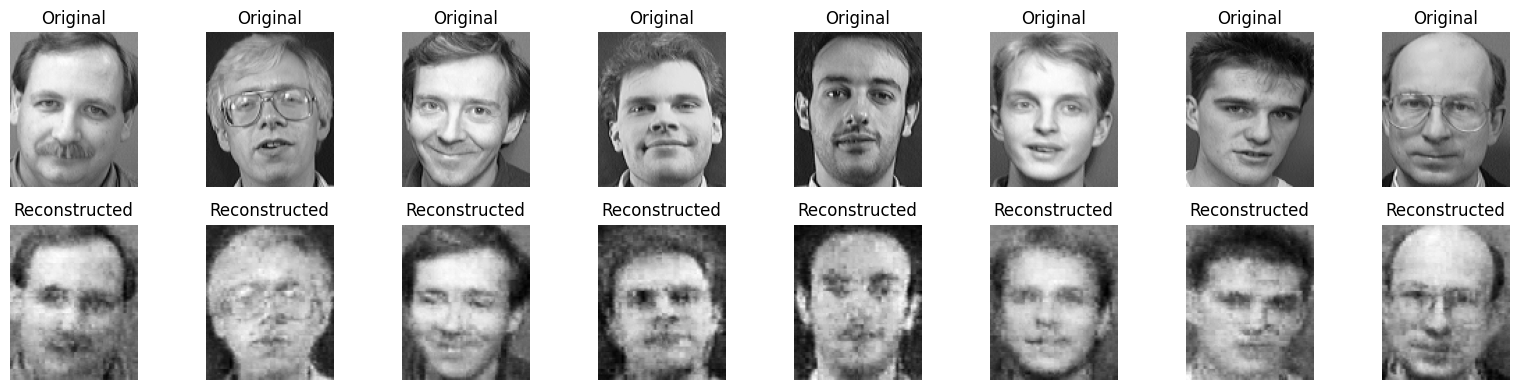

In [32]:
visualize_reconstructions(conv_model, conv_test_loader, device, n_samples=8)

# Evaluation

In [33]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay # Evaluation metrics
import seaborn as sns
NUM_SUBJECTS = 40

In [34]:
def evaluate_projection_classification(
    projector,              # PCA instance or trained AE model
    classifier,             # KMeans instance (or GMM later)
    D_train_orig: np.ndarray, # Original training data (N_train, flat_dim) - pixels 0-255
    y_train: np.ndarray,      # Training labels (N_train,)
    D_test_orig: np.ndarray,  # Original test data (N_test, flat_dim) - pixels 0-255
    y_test: np.ndarray,       # Test labels (N_test,)
    exp_name: str,
    projection_kwargs: dict = {},
    ):
    """
    Evaluates a dimensionality reduction + clustering classification pipeline.

    Args:
        projector: Instance of PCA or a trained Autoencoder model. Must have a .project() method
                   that accepts numpy array and projection_kwargs, returns projected numpy array.
        classifier: Instance of KMeans (or GMM). Must have .fit() and .predict() methods.
                    Fit takes projected data. Predict takes new projected data.
                    KMeans also needs _map_clusters_to_labels called after fit.
        D_train_orig: Original training data (for projection). Assumed 0-255 pixels.
        y_train: Training labels.
        D_test_orig: Original test data (for projection). Assumed 0-255 pixels.
        y_test: Test labels.
        exp_name: Name of the experiment.
        projection_kwargs: Dictionary of keyword arguments for the projector's .project() method.

    Returns:
        dict: Dictionary containing evaluation metrics ('accuracy', 'f1_weighted', 'f1_macro').
    """
    print(f"\n--- Evaluating: Projector={type(projector).__name__}, Classifier={type(classifier).__name__} ---")
    print(f"Projection Args: {projection_kwargs}, Classifier K={getattr(classifier, 'K', 'N/A')}")

    # 1. Project Training Data
    D_train_proj = projector.project(D_train_orig, **projection_kwargs)

    # 2. Fit Classifier on Projected Training Data and predict on it after to evaluate clustering
    if isinstance(classifier, KMeans):
        classifier.fit(D_train_proj, y_train)
        y_pred_train = classifier.predict(D_train_proj)
    elif isinstance(classifier, GMM):
        D_train_proj_standard = (D_train_proj - np.mean(D_train_proj, axis=0)) / np.std(D_train_proj, axis=0)
        classifier.fit(D_train_proj_standard, y_train)
        y_pred_train = classifier.predict(D_train_proj_standard)
    else:
        classifier.fit(D_train_proj, y_train)
        y_pred_train = classifier.predict(D_train_proj)

    # D_test_proj = projector.project(D_test_orig, **projection_kwargs)

    # # Predict on Projected Test Data
    # y_pred_test = classifier.predict(D_test_proj)

    # Evaluate
    accuracy = accuracy_score(y_train, y_pred_train)
    f1_weighted = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Test F1 Score (Macro): {f1_macro:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_train, y_pred_train, labels=np.arange(1, NUM_SUBJECTS + 1)) # Assuming labels are 1 to num_subjects
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, NUM_SUBJECTS + 1))
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(ax=ax, cmap='viridis')
    plt.title(f"Confusion Matrix ({exp_name})")
    plt.show()


    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }

In [35]:
projectors = {
        "PCA_alpha_0.80": (pca, {'alpha': 0.80}),
        "PCA_alpha_0.85": (pca, {'alpha': 0.85}),
        "PCA_alpha_0.90": (pca, {'alpha': 0.90}),
        "PCA_alpha_0.95": (pca, {'alpha': 0.95}),
        "FullyConnectedAutoEncoder": (fc_model, {}),
        "ConvolutionalAutoencoder": (conv_model, {}),
    }

classifiers = {
    "KMeans_K20": KMeans(K=20, rand_start=20),
    "KMeans_K40": KMeans(K=40, rand_start=20),
    "KMeans_K60": KMeans(K=60, rand_start=20),
    "GMM_K20": GMM(clusters=20, random_starts=20, max_iter=150),
    "GMM_K40": GMM(clusters=40, random_starts=20, max_iter=150),
    "GMM_K60": GMM(clusters=60, random_starts=20, max_iter=150),
}

results = {}


----- Running Experiment: PCA_alpha_0.80_KMeans_K20 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.8}, Classifier K=20
Test Accuracy: 0.4350
Test F1 Score (Weighted): 0.3181
Test F1 Score (Macro): 0.3181


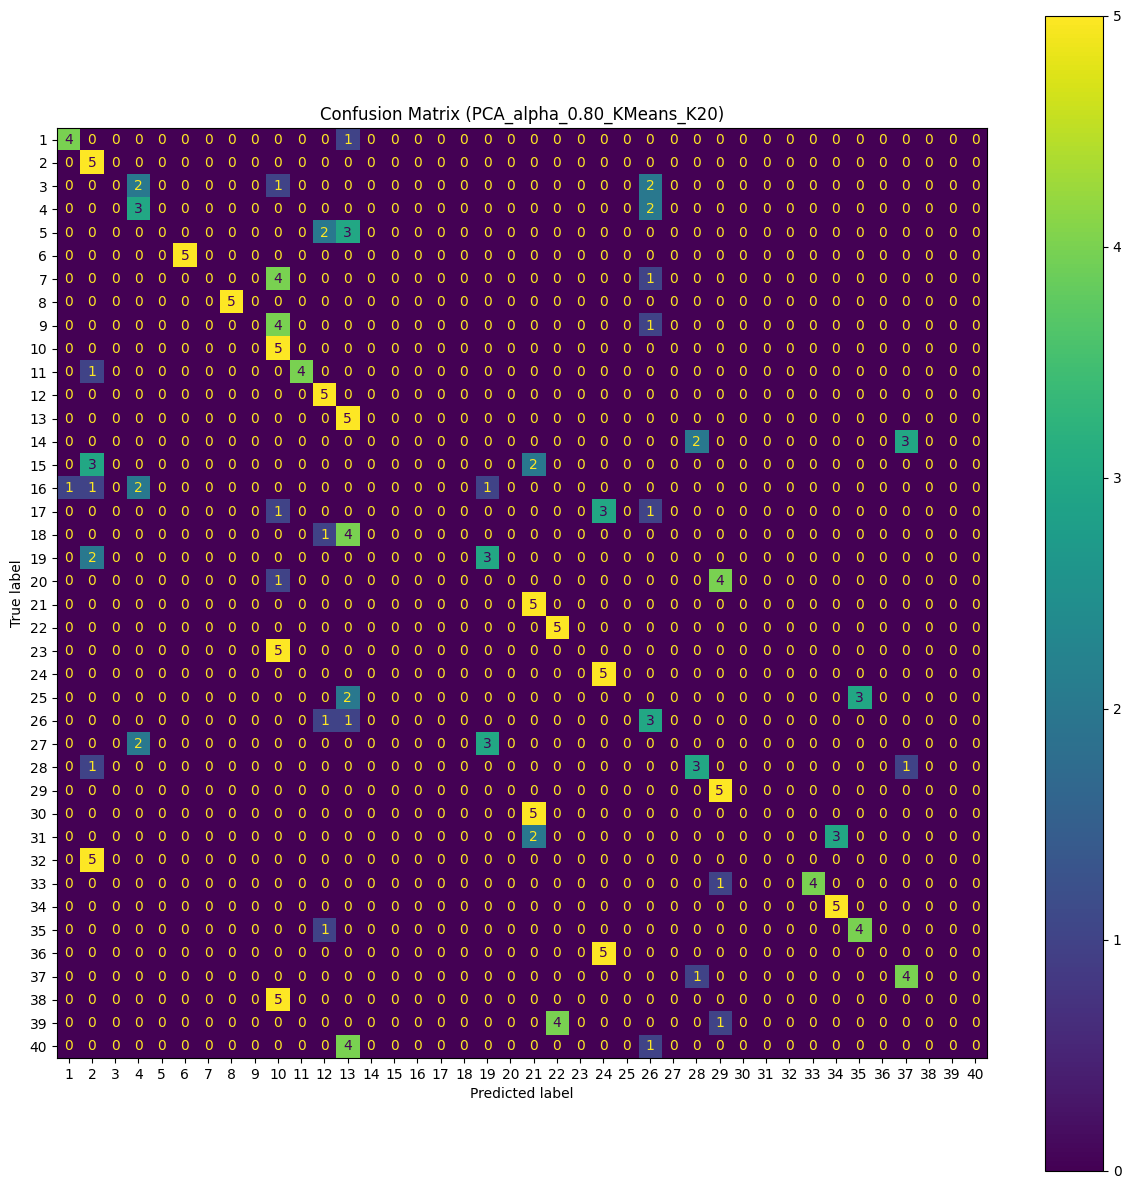


----- Running Experiment: PCA_alpha_0.80_KMeans_K40 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.8}, Classifier K=40
Test Accuracy: 0.6550
Test F1 Score (Weighted): 0.6160
Test F1 Score (Macro): 0.6160


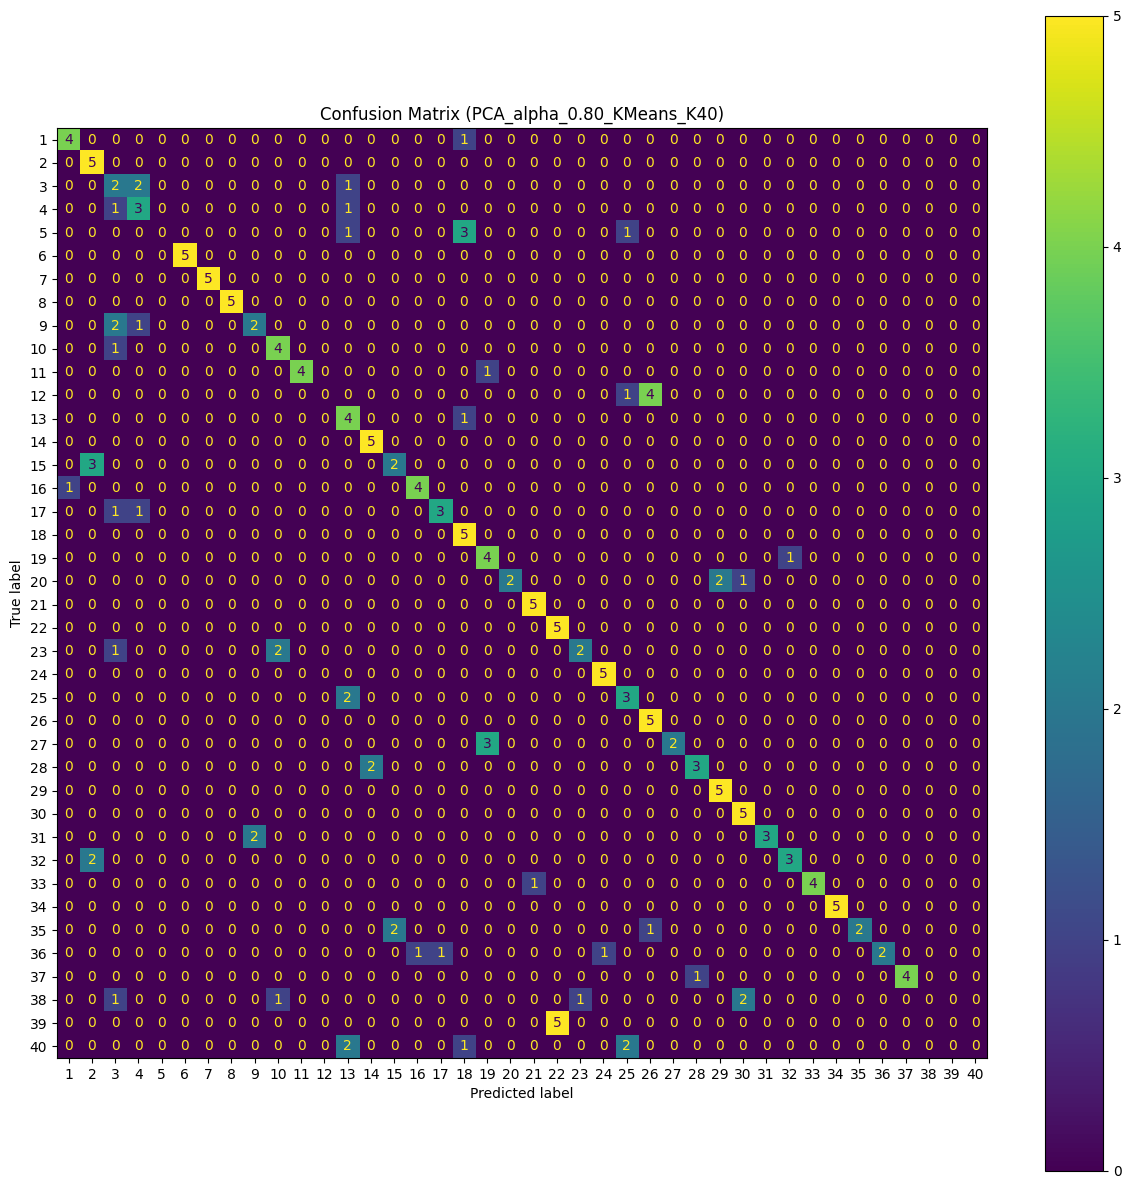


----- Running Experiment: PCA_alpha_0.80_KMeans_K60 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.8}, Classifier K=60
Test Accuracy: 0.7900
Test F1 Score (Weighted): 0.7630
Test F1 Score (Macro): 0.7630


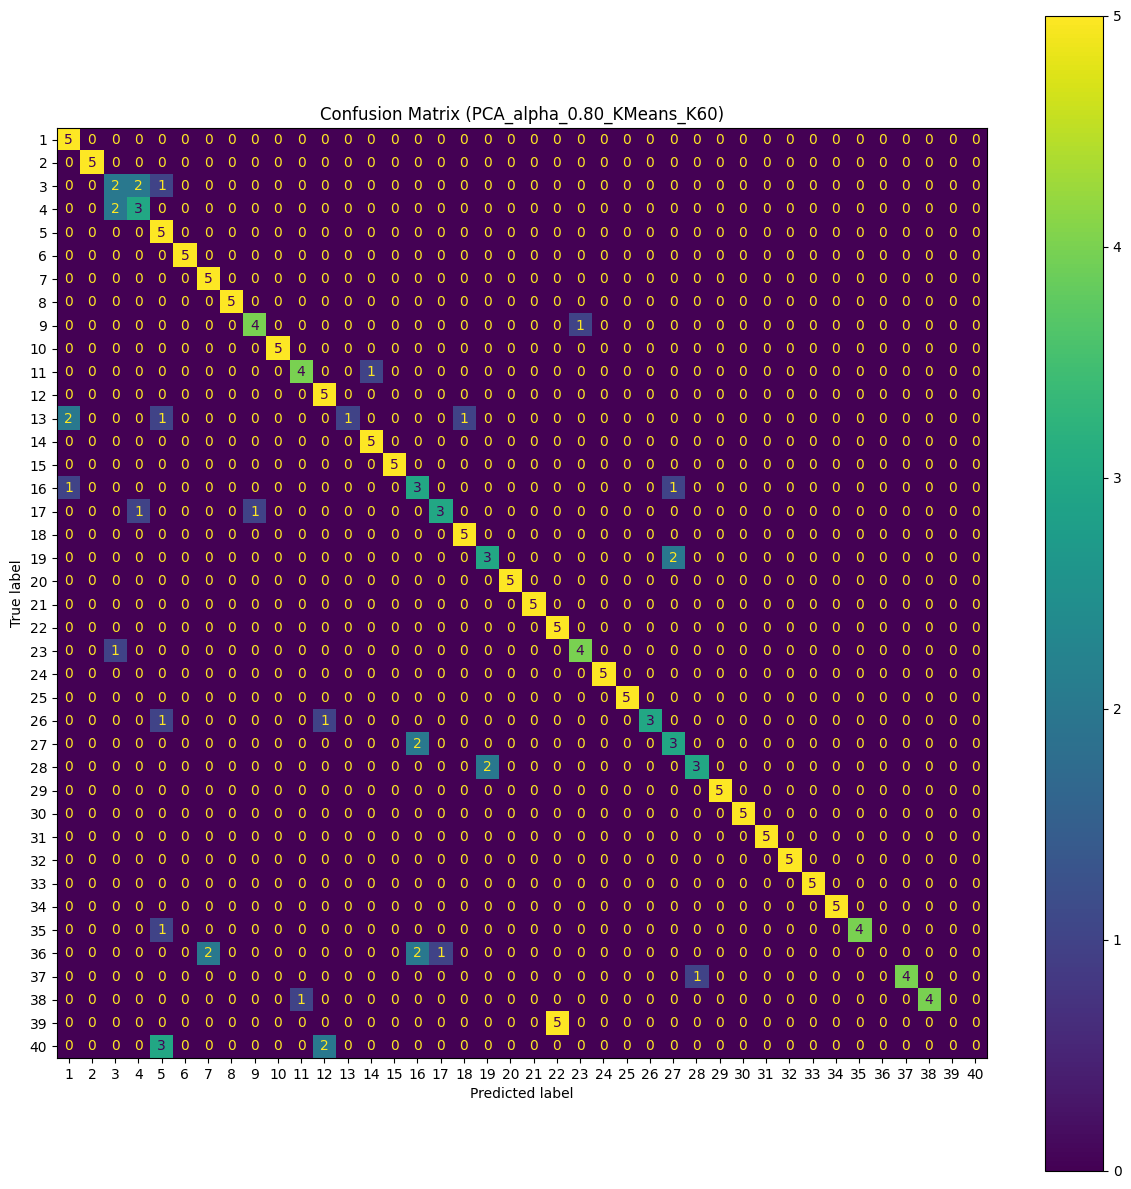


----- Running Experiment: PCA_alpha_0.80_GMM_K20 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.8}, Classifier K=N/A
Converged at iteration 6 for random start 0
Converged at iteration 6 for random start 1
Converged at iteration 7 for random start 2
Converged at iteration 7 for random start 3
Converged at iteration 5 for random start 4
Converged at iteration 7 for random start 5
Converged at iteration 6 for random start 6
Converged at iteration 6 for random start 7
Converged at iteration 6 for random start 8
Converged at iteration 6 for random start 9
Converged at iteration 6 for random start 10
Converged at iteration 6 for random start 11
Converged at iteration 6 for random start 12
Converged at iteration 5 for random start 13
Converged at iteration 5 for random start 14
Converged at iteration 5 for random start 15
Converged at iteration 6 for random start 16
Converged at iteration 8 for random start 17
Converged at iteration 7 for random start 1

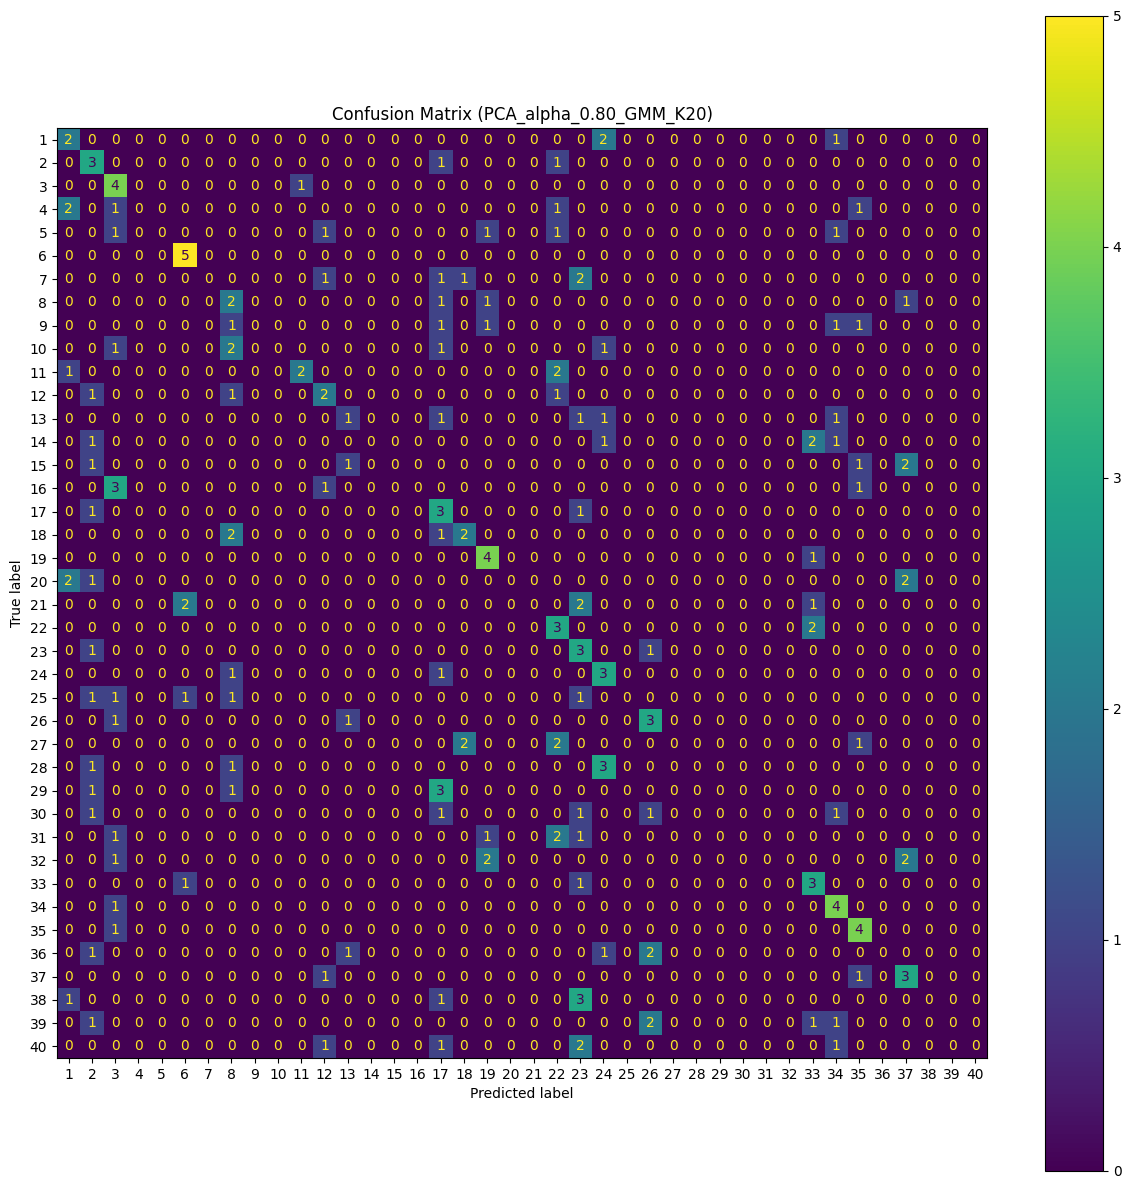


----- Running Experiment: PCA_alpha_0.80_GMM_K40 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.8}, Classifier K=N/A
Converged at iteration 8 for random start 0
Converged at iteration 7 for random start 1
Converged at iteration 7 for random start 2
Converged at iteration 45 for random start 3
Converged at iteration 7 for random start 4
Converged at iteration 6 for random start 5
Converged at iteration 34 for random start 6
Converged at iteration 8 for random start 7
Converged at iteration 7 for random start 8
Converged at iteration 10 for random start 9
Converged at iteration 8 for random start 10
Converged at iteration 11 for random start 11
Converged at iteration 9 for random start 12
Converged at iteration 7 for random start 13
Converged at iteration 9 for random start 14
Converged at iteration 13 for random start 15
Converged at iteration 22 for random start 16
Converged at iteration 9 for random start 17
Converged at iteration 9 for random s

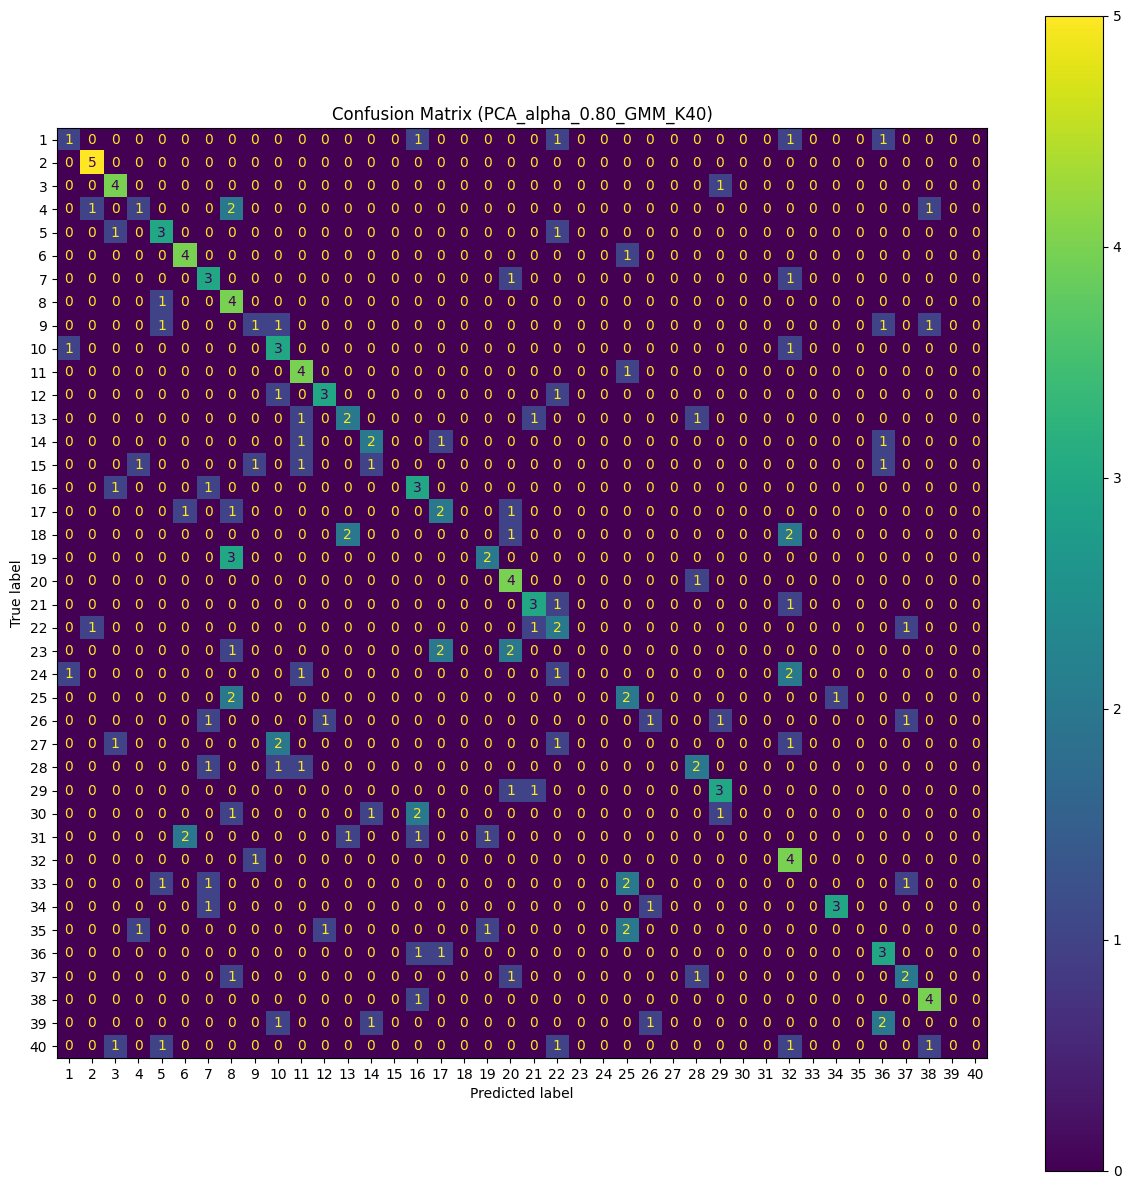


----- Running Experiment: PCA_alpha_0.80_GMM_K60 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.8}, Classifier K=N/A
Converged at iteration 34 for random start 0
Converged at iteration 18 for random start 1
Converged at iteration 11 for random start 2
Converged at iteration 33 for random start 3
Converged at iteration 36 for random start 4
Converged at iteration 23 for random start 5
Converged at iteration 38 for random start 6
Converged at iteration 15 for random start 7
Converged at iteration 39 for random start 8
Converged at iteration 19 for random start 9
Converged at iteration 23 for random start 10
Converged at iteration 67 for random start 11
Converged at iteration 21 for random start 12
Converged at iteration 57 for random start 13
Converged at iteration 22 for random start 14
Converged at iteration 42 for random start 15
Converged at iteration 30 for random start 16
Converged at iteration 35 for random start 17
Converged at iteration 69

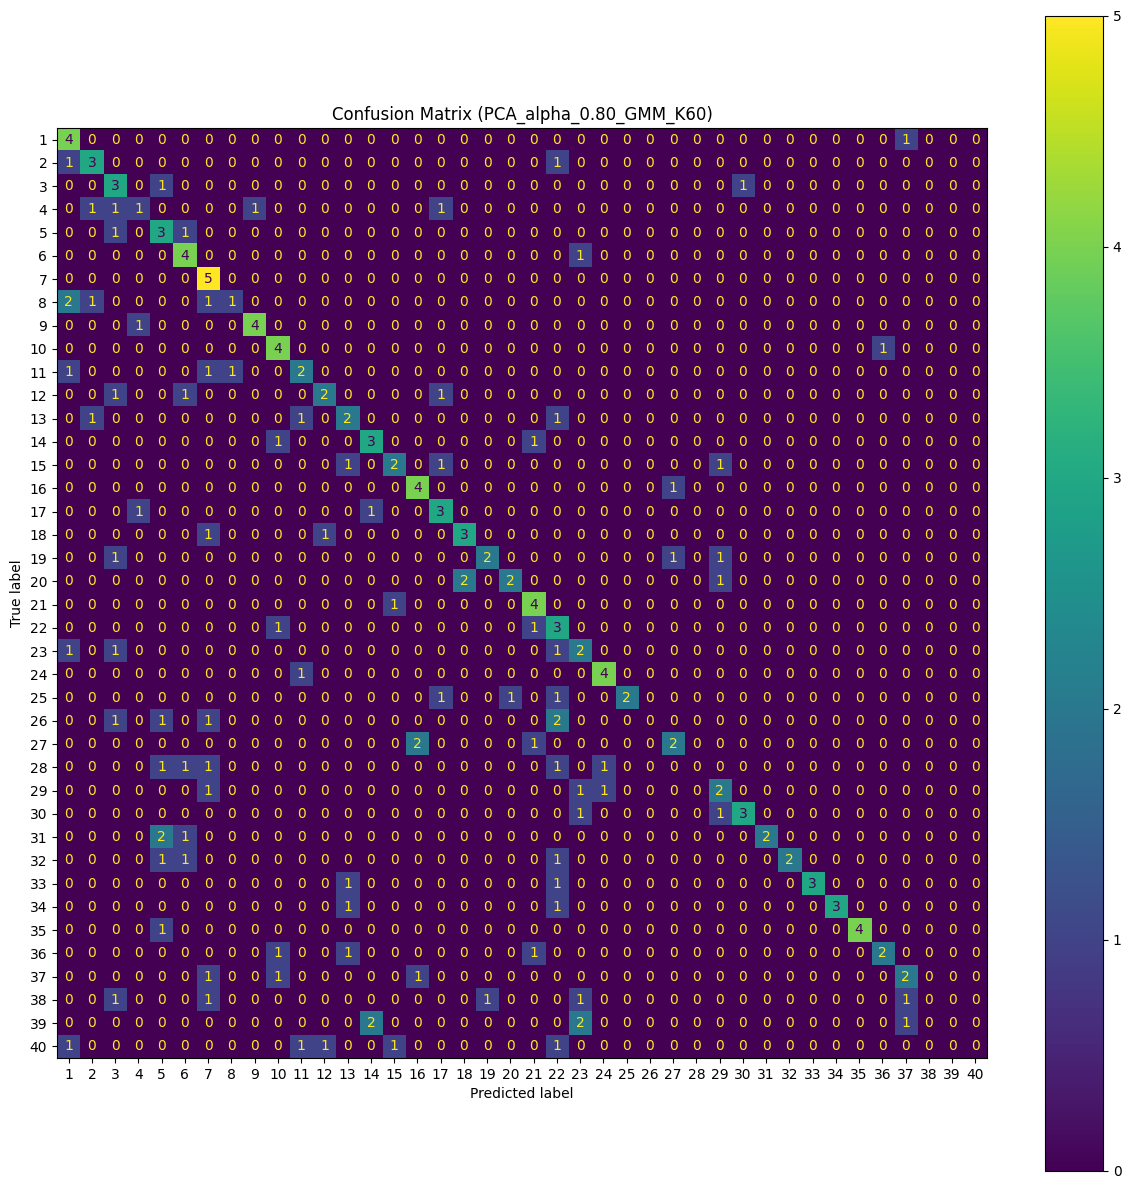



=== Evaluation Results Summary ===
PCA_alpha_0.80_KMeans_K20: Accuracy=0.4350, F1_Weighted=0.3181, F1_Macro=0.3181
PCA_alpha_0.80_KMeans_K40: Accuracy=0.6550, F1_Weighted=0.6160, F1_Macro=0.6160
PCA_alpha_0.80_KMeans_K60: Accuracy=0.7900, F1_Weighted=0.7630, F1_Macro=0.7630
PCA_alpha_0.80_GMM_K20: Accuracy=0.2800, F1_Weighted=0.1845, F1_Macro=0.1845
PCA_alpha_0.80_GMM_K40: Accuracy=0.4000, F1_Weighted=0.3320, F1_Macro=0.3320
PCA_alpha_0.80_GMM_K60: Accuracy=0.4850, F1_Weighted=0.4591, F1_Macro=0.4591

----- Running Experiment: PCA_alpha_0.85_KMeans_K20 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.85}, Classifier K=20
Test Accuracy: 0.4750
Test F1 Score (Weighted): 0.3479
Test F1 Score (Macro): 0.3479


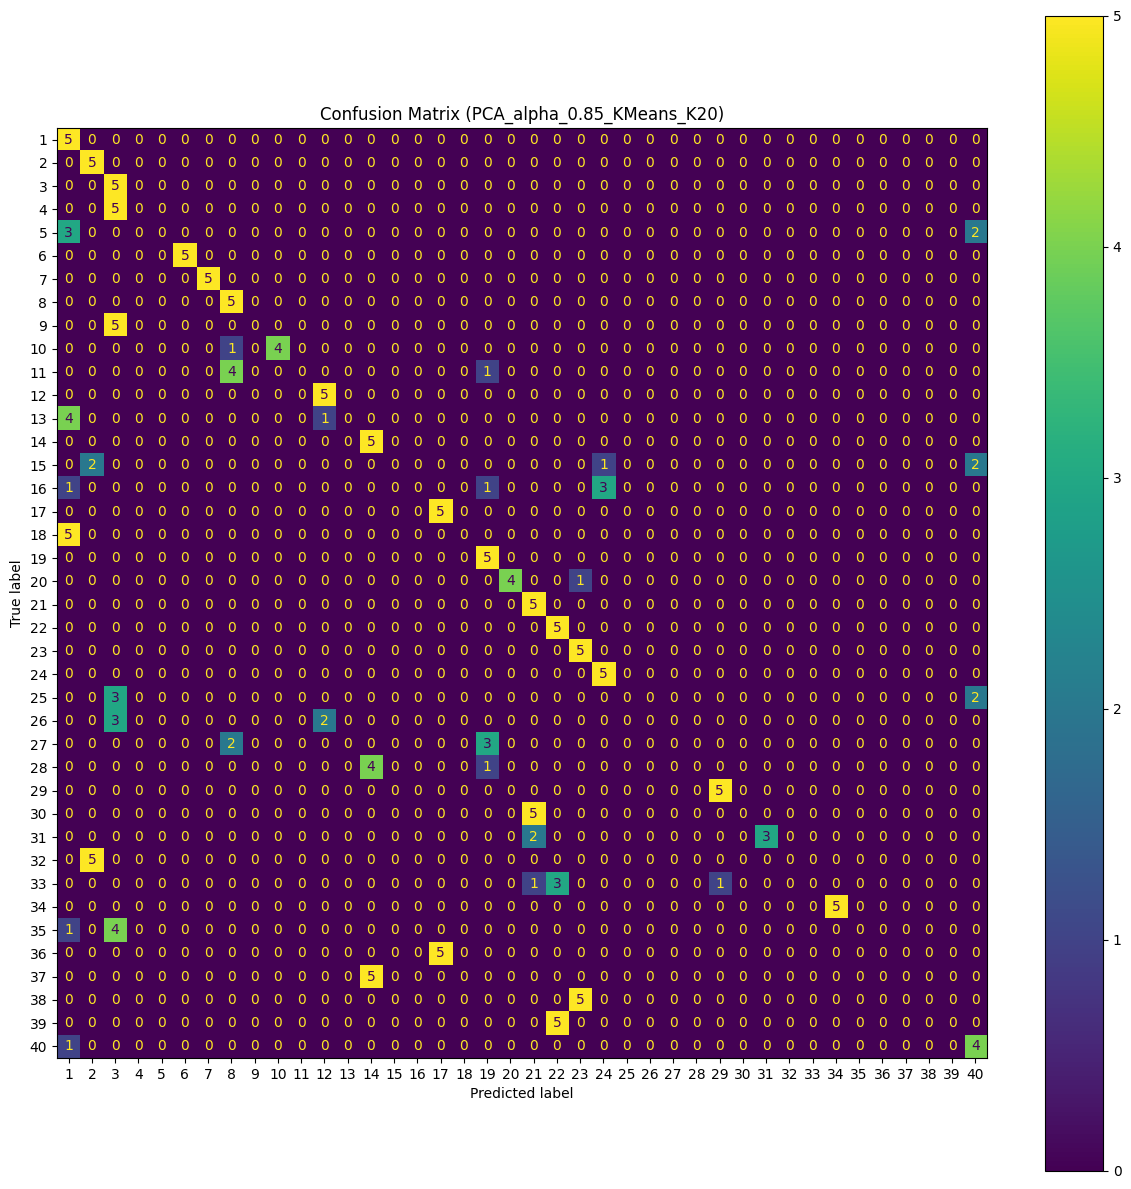


----- Running Experiment: PCA_alpha_0.85_KMeans_K40 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.85}, Classifier K=40
Test Accuracy: 0.6450
Test F1 Score (Weighted): 0.6014
Test F1 Score (Macro): 0.6014


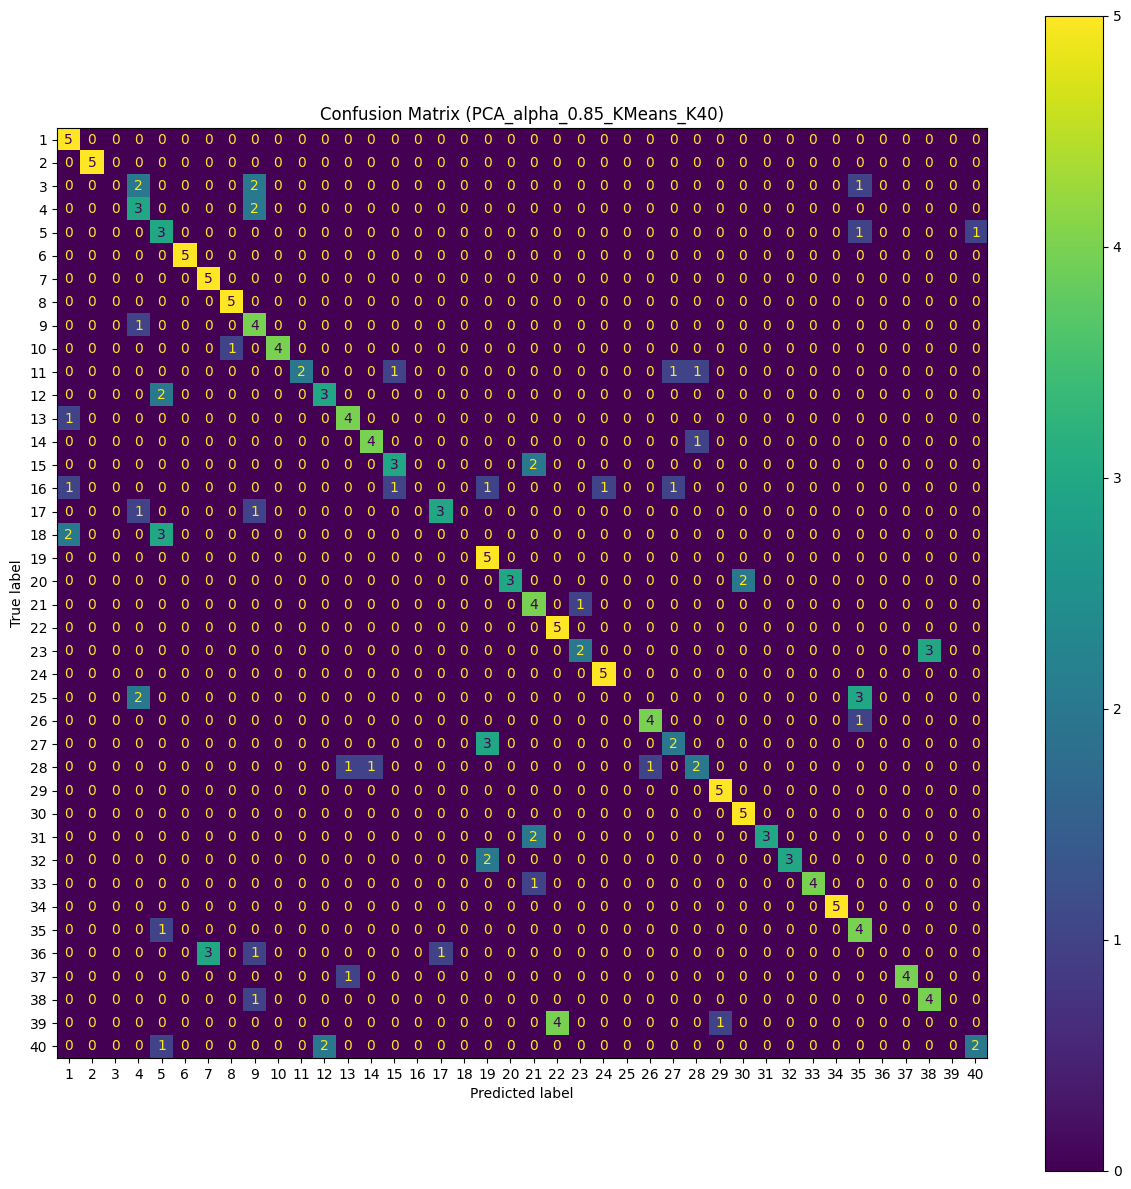


----- Running Experiment: PCA_alpha_0.85_KMeans_K60 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.85}, Classifier K=60
Test Accuracy: 0.7550
Test F1 Score (Weighted): 0.7411
Test F1 Score (Macro): 0.7411


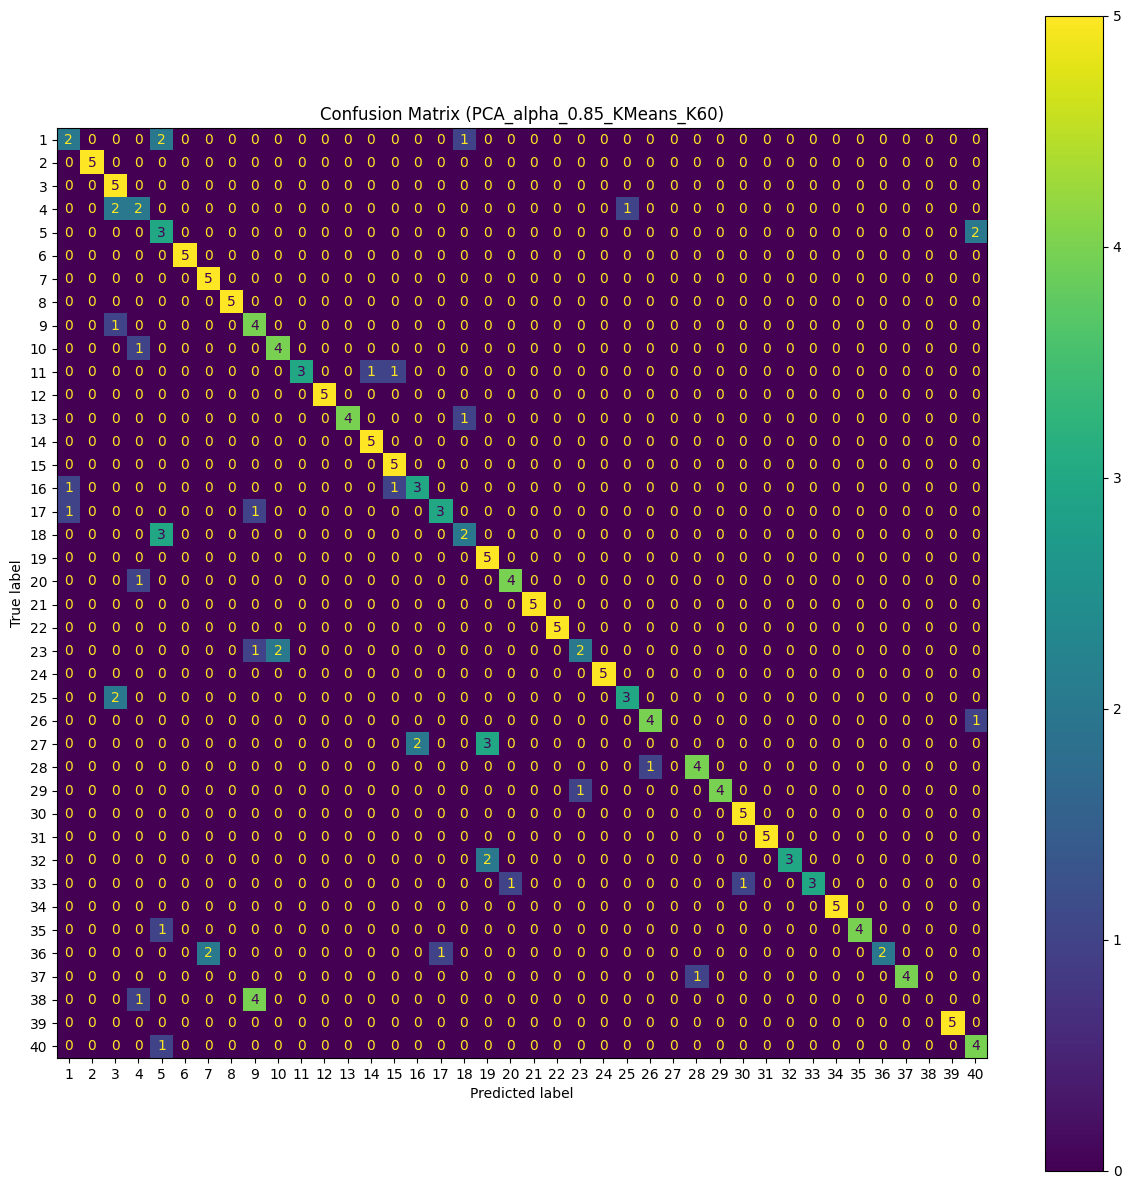


----- Running Experiment: PCA_alpha_0.85_GMM_K20 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.85}, Classifier K=N/A
Converged at iteration 6 for random start 0
Converged at iteration 7 for random start 1
Converged at iteration 5 for random start 2
Converged at iteration 5 for random start 3
Converged at iteration 9 for random start 4
Converged at iteration 5 for random start 5
Converged at iteration 6 for random start 6
Converged at iteration 6 for random start 7
Converged at iteration 5 for random start 8
Converged at iteration 5 for random start 9
Converged at iteration 6 for random start 10
Converged at iteration 7 for random start 11
Converged at iteration 5 for random start 12
Converged at iteration 6 for random start 13
Converged at iteration 10 for random start 14
Converged at iteration 5 for random start 15
Converged at iteration 6 for random start 16
Converged at iteration 5 for random start 17
Converged at iteration 5 for random start

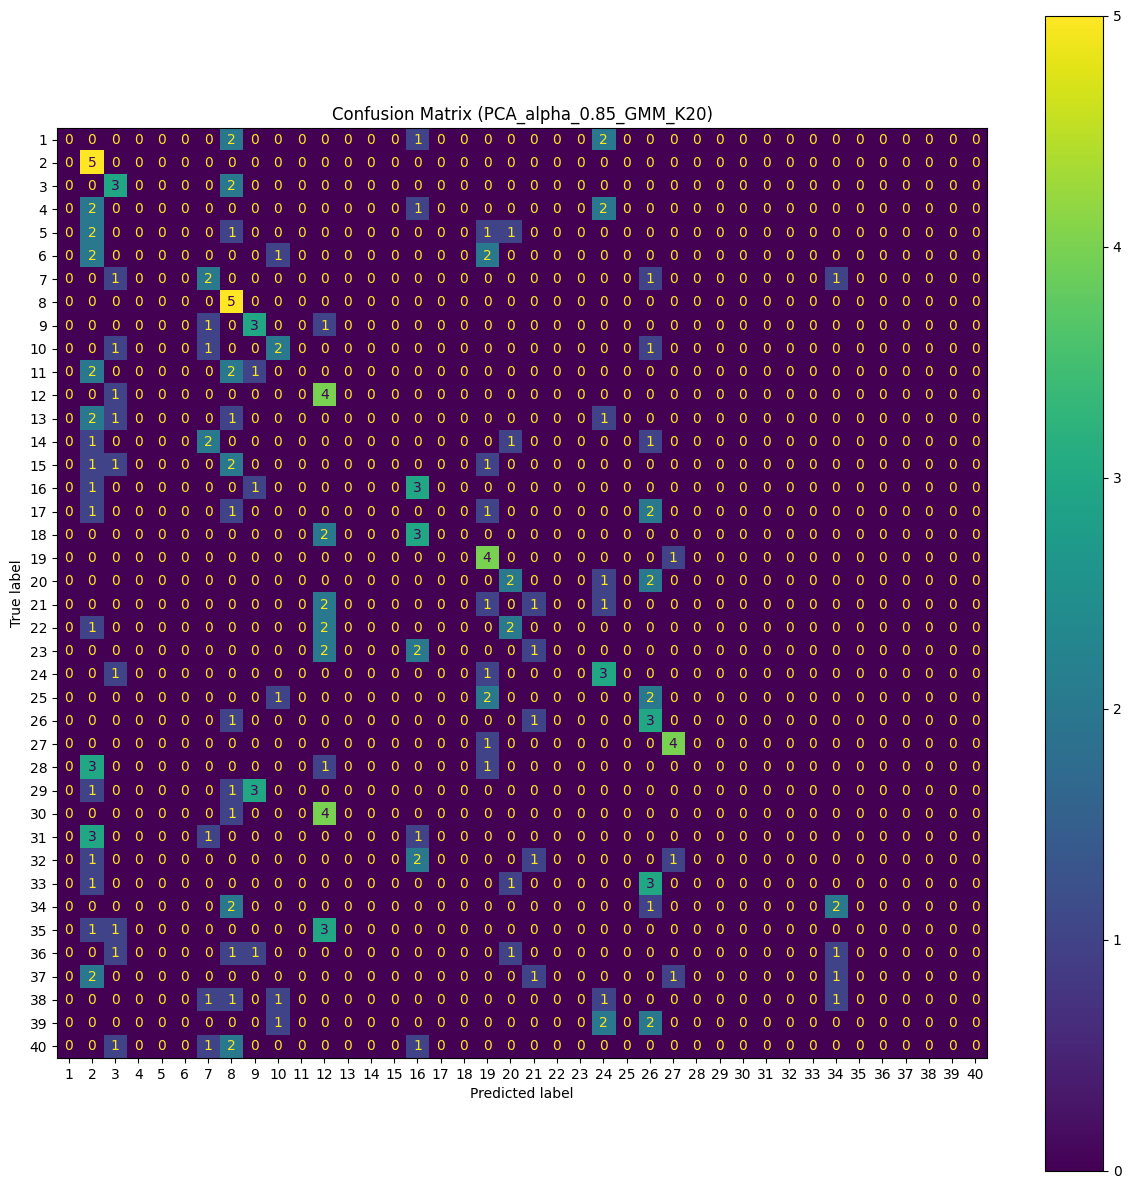


----- Running Experiment: PCA_alpha_0.85_GMM_K40 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.85}, Classifier K=N/A
Converged at iteration 23 for random start 0
Converged at iteration 6 for random start 1
Converged at iteration 7 for random start 2
Converged at iteration 8 for random start 3
Converged at iteration 24 for random start 4
Converged at iteration 27 for random start 5
Converged at iteration 9 for random start 6
Converged at iteration 8 for random start 7
Converged at iteration 9 for random start 8
Converged at iteration 18 for random start 9
Converged at iteration 14 for random start 10
Converged at iteration 7 for random start 11
Converged at iteration 38 for random start 12
Converged at iteration 8 for random start 13
Converged at iteration 9 for random start 14
Converged at iteration 11 for random start 15
Converged at iteration 10 for random start 16
Converged at iteration 7 for random start 17
Converged at iteration 16 for rand

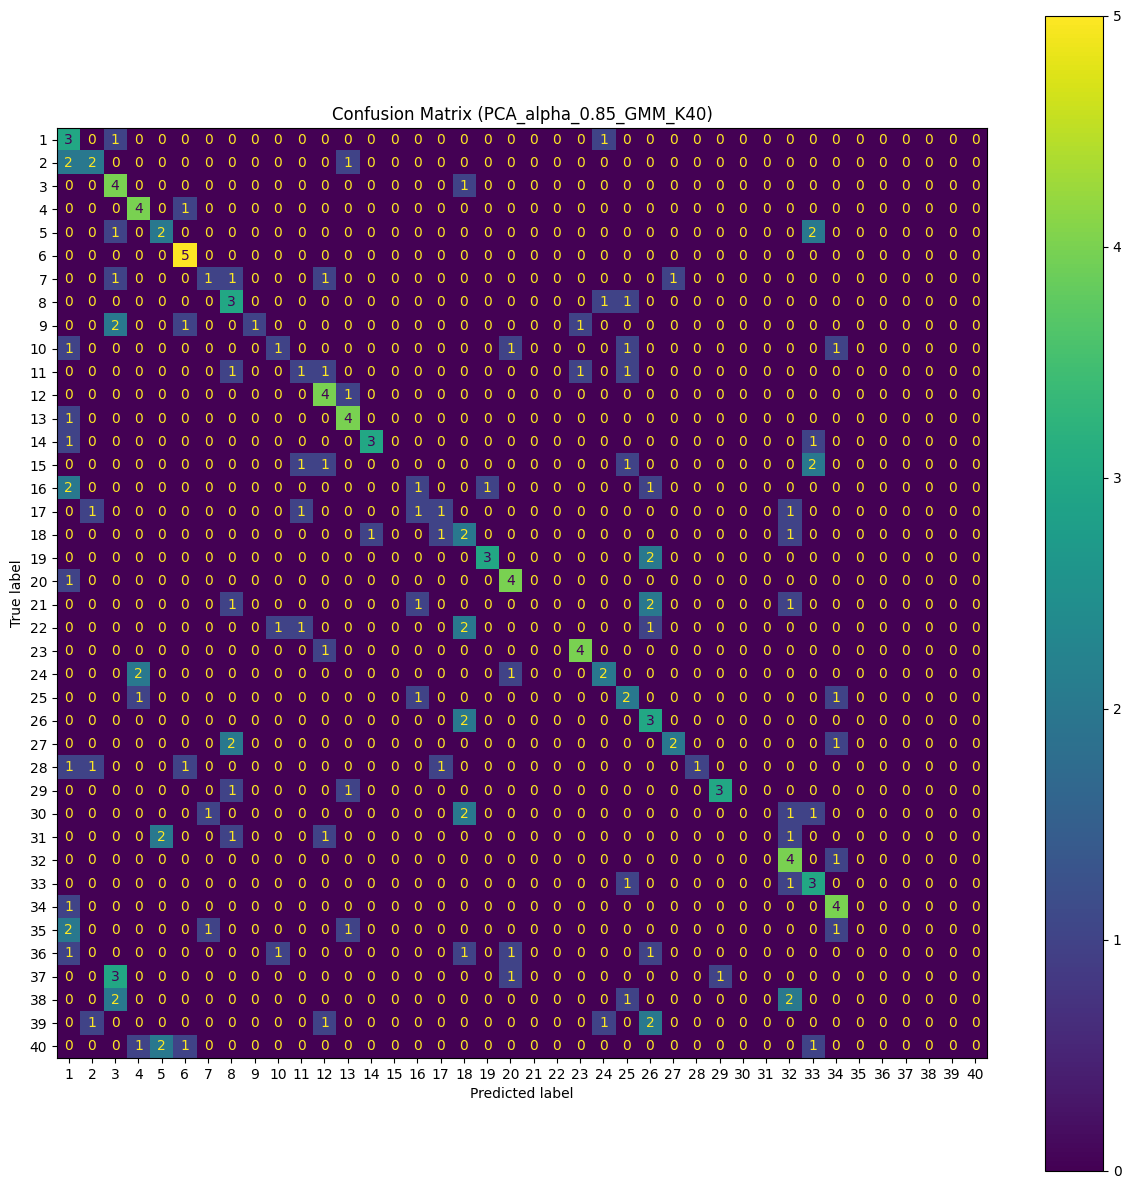


----- Running Experiment: PCA_alpha_0.85_GMM_K60 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.85}, Classifier K=N/A
Converged at iteration 41 for random start 0
Converged at iteration 63 for random start 1
Converged at iteration 12 for random start 2
Converged at iteration 32 for random start 3
Converged at iteration 38 for random start 4
Converged at iteration 28 for random start 5
Converged at iteration 43 for random start 6
Converged at iteration 35 for random start 7
Converged at iteration 37 for random start 8
Converged at iteration 47 for random start 9
Converged at iteration 26 for random start 10
Converged at iteration 34 for random start 11
Converged at iteration 13 for random start 12
Converged at iteration 19 for random start 13
Converged at iteration 22 for random start 14
Converged at iteration 72 for random start 15
Converged at iteration 56 for random start 16
Converged at iteration 31 for random start 17
Converged at iteration 2

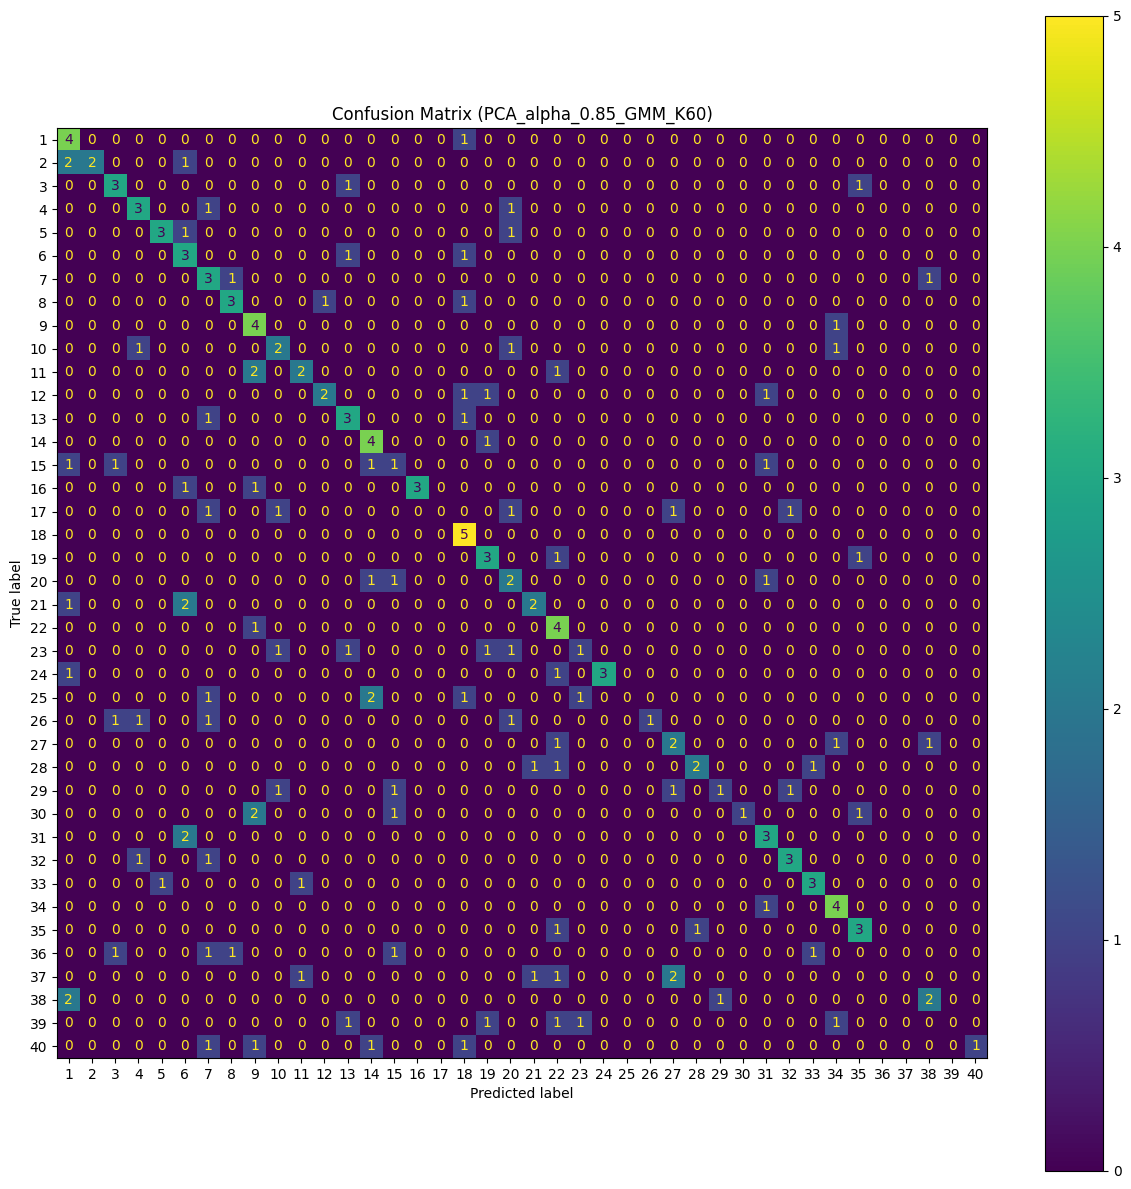



=== Evaluation Results Summary ===
PCA_alpha_0.80_KMeans_K20: Accuracy=0.4350, F1_Weighted=0.3181, F1_Macro=0.3181
PCA_alpha_0.80_KMeans_K40: Accuracy=0.6550, F1_Weighted=0.6160, F1_Macro=0.6160
PCA_alpha_0.80_KMeans_K60: Accuracy=0.7900, F1_Weighted=0.7630, F1_Macro=0.7630
PCA_alpha_0.80_GMM_K20: Accuracy=0.2800, F1_Weighted=0.1845, F1_Macro=0.1845
PCA_alpha_0.80_GMM_K40: Accuracy=0.4000, F1_Weighted=0.3320, F1_Macro=0.3320
PCA_alpha_0.80_GMM_K60: Accuracy=0.4850, F1_Weighted=0.4591, F1_Macro=0.4591
PCA_alpha_0.85_KMeans_K20: Accuracy=0.4750, F1_Weighted=0.3479, F1_Macro=0.3479
PCA_alpha_0.85_KMeans_K40: Accuracy=0.6450, F1_Weighted=0.6014, F1_Macro=0.6014
PCA_alpha_0.85_KMeans_K60: Accuracy=0.7550, F1_Weighted=0.7411, F1_Macro=0.7411
PCA_alpha_0.85_GMM_K20: Accuracy=0.2300, F1_Weighted=0.1298, F1_Macro=0.1298
PCA_alpha_0.85_GMM_K40: Accuracy=0.3850, F1_Weighted=0.3205, F1_Macro=0.3205
PCA_alpha_0.85_GMM_K60: Accuracy=0.4550, F1_Weighted=0.4209, F1_Macro=0.4209

----- Running Experi

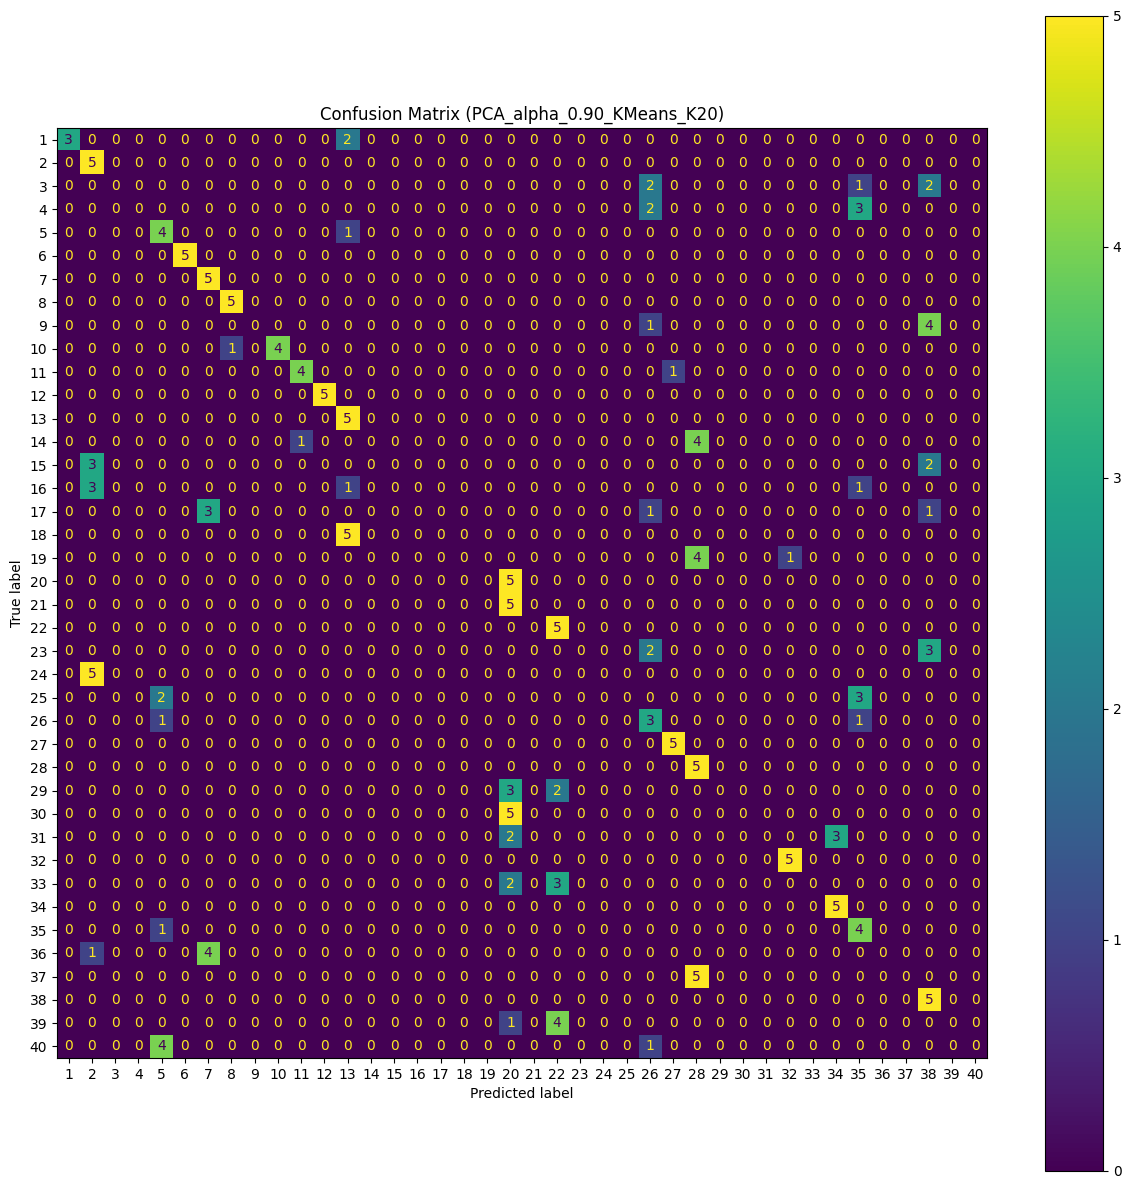


----- Running Experiment: PCA_alpha_0.90_KMeans_K40 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.9}, Classifier K=40
Test Accuracy: 0.6350
Test F1 Score (Weighted): 0.5788
Test F1 Score (Macro): 0.5788


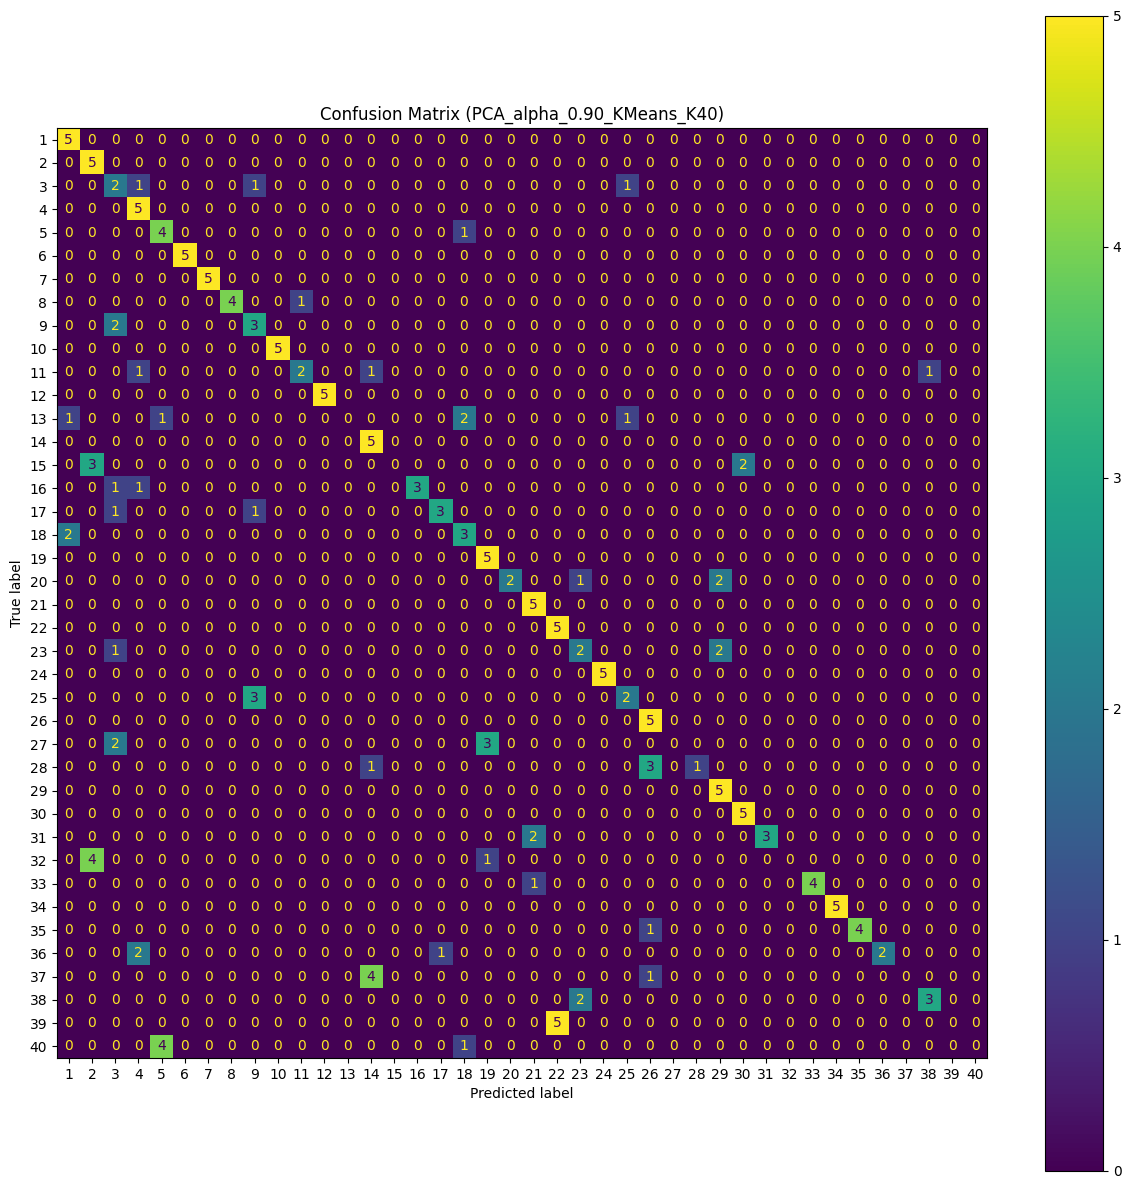


----- Running Experiment: PCA_alpha_0.90_KMeans_K60 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.9}, Classifier K=60
Test Accuracy: 0.8150
Test F1 Score (Weighted): 0.8018
Test F1 Score (Macro): 0.8018


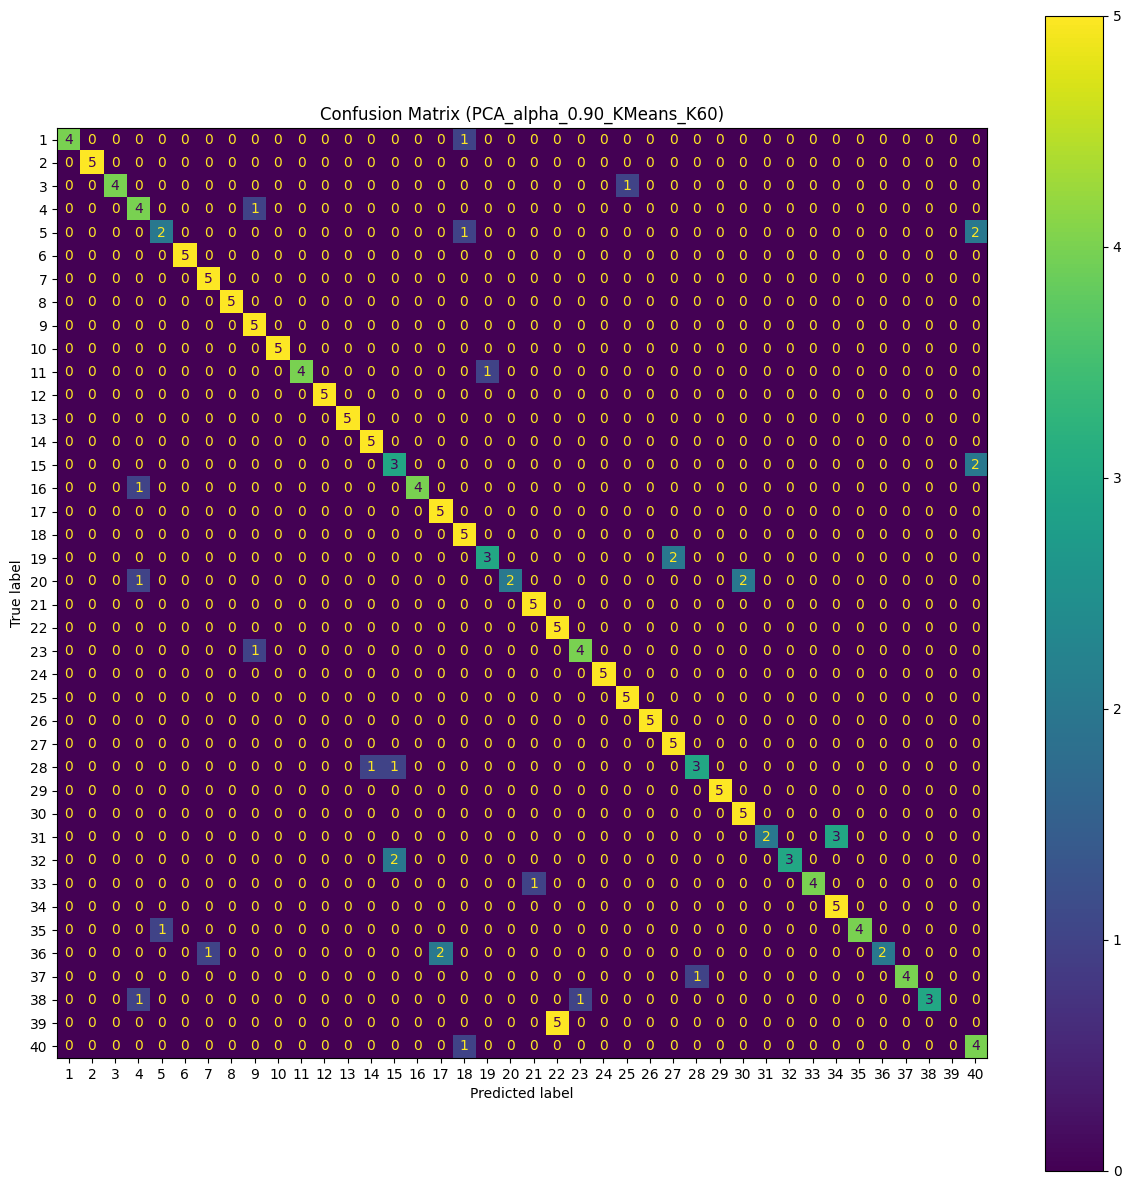


----- Running Experiment: PCA_alpha_0.90_GMM_K20 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.9}, Classifier K=N/A
Converged at iteration 7 for random start 0
Converged at iteration 6 for random start 1
Converged at iteration 6 for random start 2
Converged at iteration 5 for random start 3
Converged at iteration 6 for random start 4
Converged at iteration 6 for random start 5
Converged at iteration 7 for random start 6
Converged at iteration 7 for random start 7
Converged at iteration 5 for random start 8
Converged at iteration 6 for random start 9
Converged at iteration 8 for random start 10
Converged at iteration 6 for random start 11
Converged at iteration 5 for random start 12
Converged at iteration 6 for random start 13
Converged at iteration 5 for random start 14
Converged at iteration 8 for random start 15
Converged at iteration 6 for random start 16
Converged at iteration 8 for random start 17
Converged at iteration 6 for random start 1

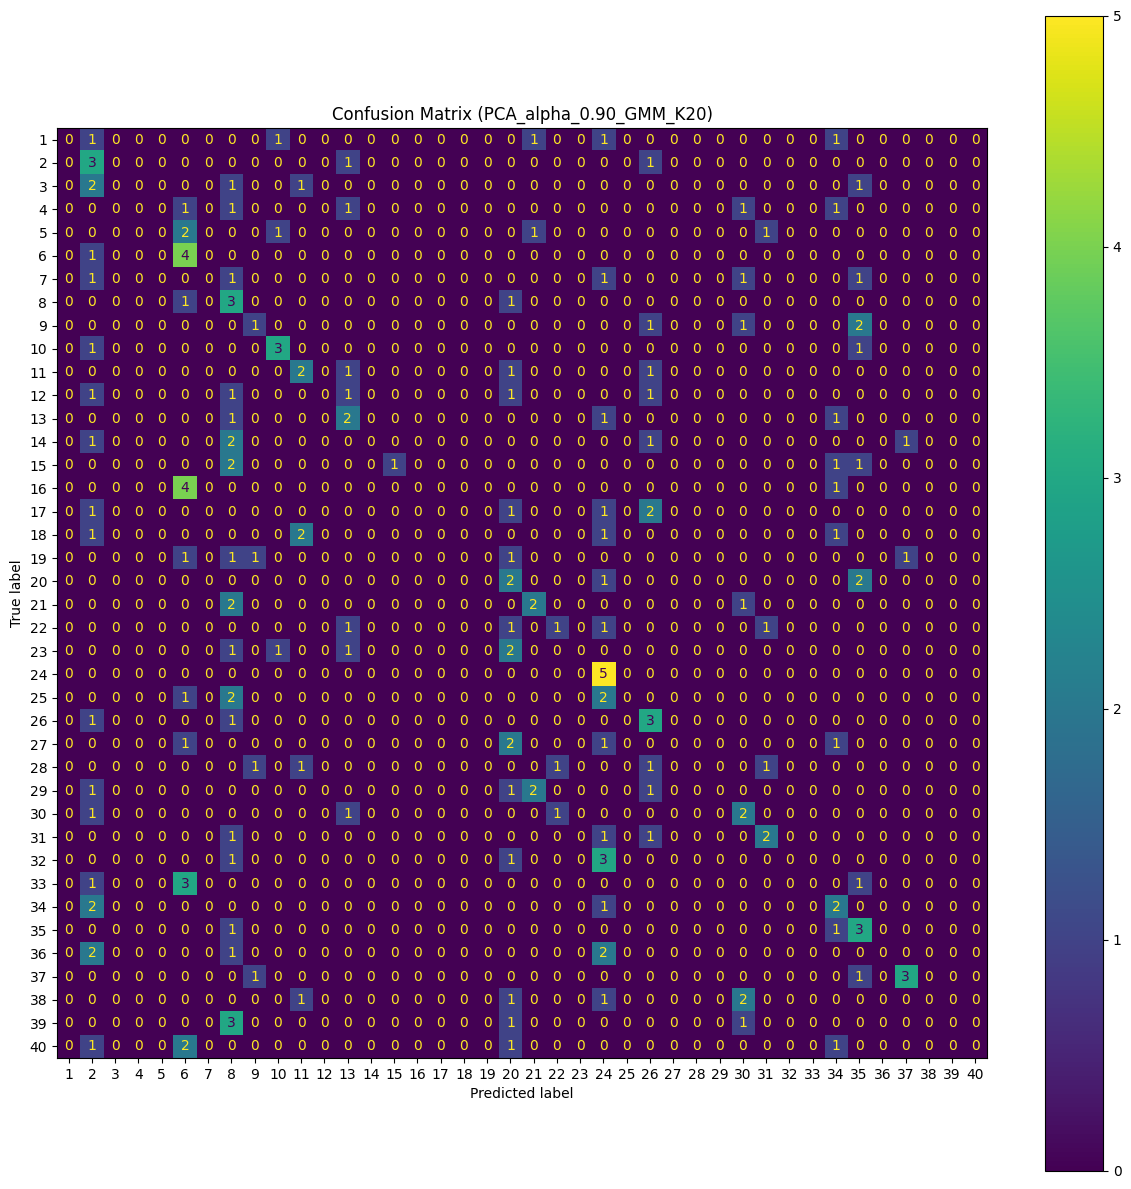


----- Running Experiment: PCA_alpha_0.90_GMM_K40 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.9}, Classifier K=N/A
Converged at iteration 16 for random start 0
Converged at iteration 11 for random start 1
Converged at iteration 12 for random start 2
Converged at iteration 6 for random start 3
Converged at iteration 6 for random start 4
Converged at iteration 23 for random start 5
Converged at iteration 15 for random start 6
Converged at iteration 26 for random start 7
Converged at iteration 19 for random start 8
Converged at iteration 8 for random start 9
Converged at iteration 9 for random start 10
Converged at iteration 10 for random start 11
Converged at iteration 11 for random start 12
Converged at iteration 7 for random start 13
Converged at iteration 18 for random start 14
Converged at iteration 44 for random start 15
Converged at iteration 8 for random start 16
Converged at iteration 19 for random start 17
Converged at iteration 18 for r

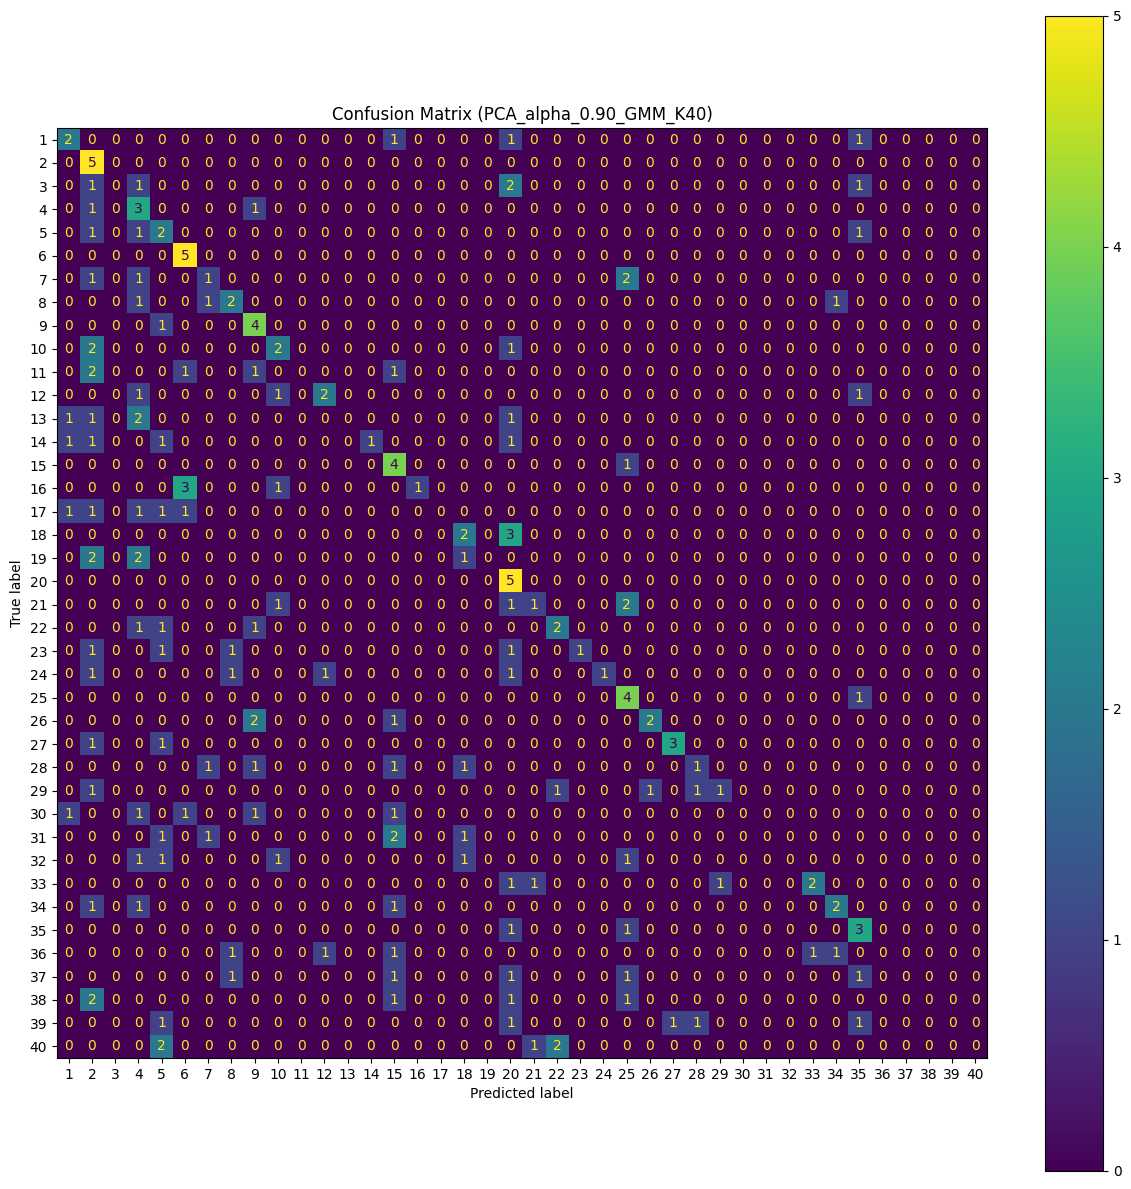


----- Running Experiment: PCA_alpha_0.90_GMM_K60 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.9}, Classifier K=N/A
Converged at iteration 24 for random start 0
Converged at iteration 16 for random start 1
Converged at iteration 16 for random start 2
Converged at iteration 9 for random start 3
Converged at iteration 29 for random start 4
Converged at iteration 45 for random start 5
Converged at iteration 47 for random start 6
Converged at iteration 35 for random start 7
Converged at iteration 35 for random start 8
Converged at iteration 28 for random start 9
Converged at iteration 29 for random start 10
Converged at iteration 63 for random start 11
Converged at iteration 30 for random start 12
Converged at iteration 33 for random start 13
Converged at iteration 10 for random start 14
Converged at iteration 42 for random start 15
Converged at iteration 31 for random start 16
Converged at iteration 38 for random start 17
Converged at iteration 26 

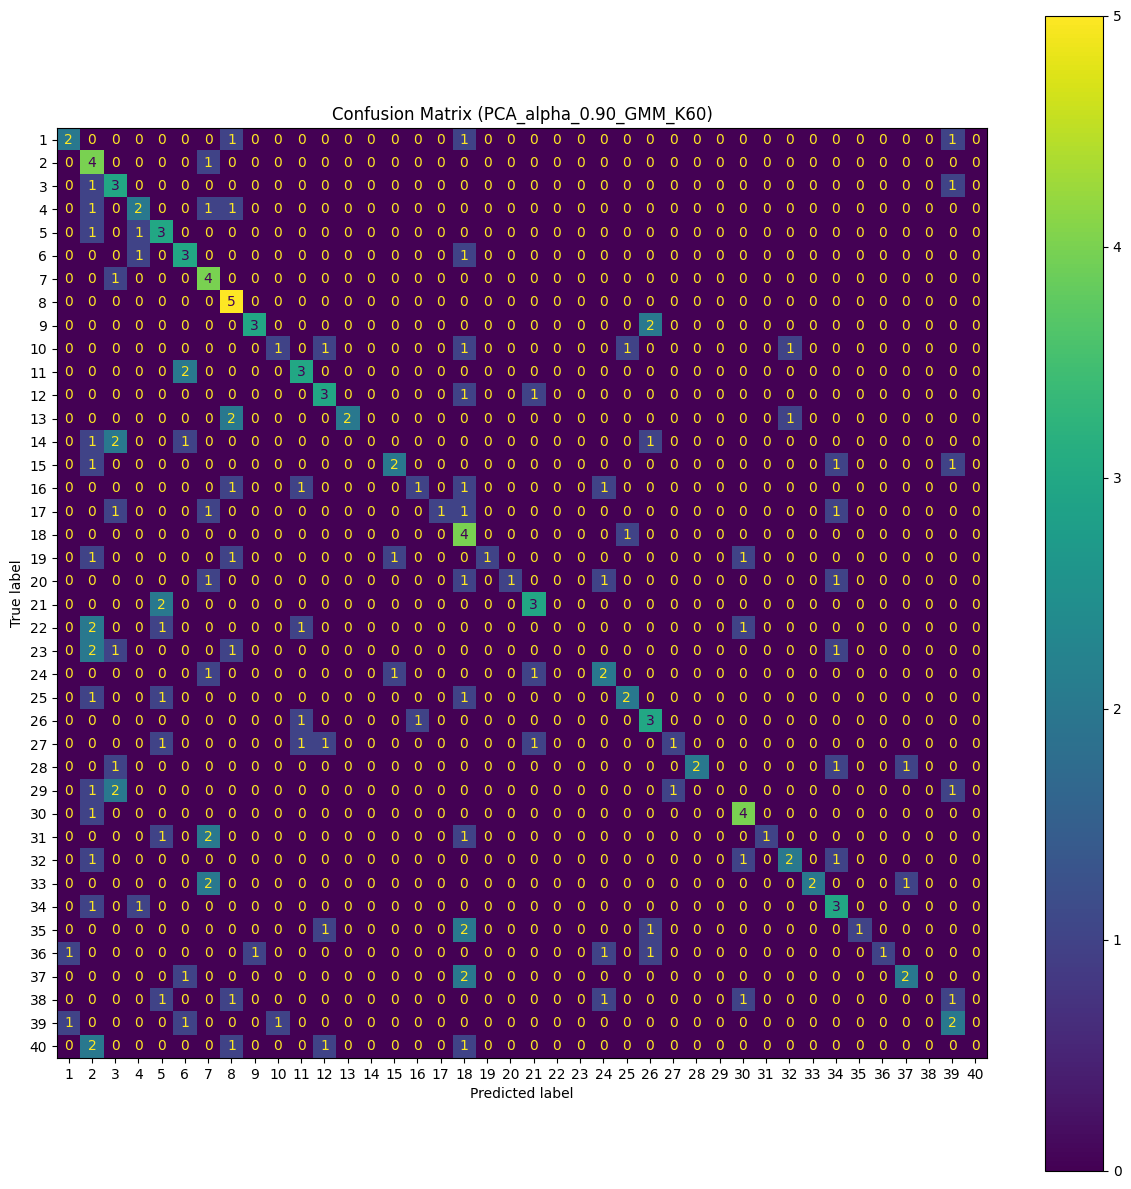



=== Evaluation Results Summary ===
PCA_alpha_0.80_KMeans_K20: Accuracy=0.4350, F1_Weighted=0.3181, F1_Macro=0.3181
PCA_alpha_0.80_KMeans_K40: Accuracy=0.6550, F1_Weighted=0.6160, F1_Macro=0.6160
PCA_alpha_0.80_KMeans_K60: Accuracy=0.7900, F1_Weighted=0.7630, F1_Macro=0.7630
PCA_alpha_0.80_GMM_K20: Accuracy=0.2800, F1_Weighted=0.1845, F1_Macro=0.1845
PCA_alpha_0.80_GMM_K40: Accuracy=0.4000, F1_Weighted=0.3320, F1_Macro=0.3320
PCA_alpha_0.80_GMM_K60: Accuracy=0.4850, F1_Weighted=0.4591, F1_Macro=0.4591
PCA_alpha_0.85_KMeans_K20: Accuracy=0.4750, F1_Weighted=0.3479, F1_Macro=0.3479
PCA_alpha_0.85_KMeans_K40: Accuracy=0.6450, F1_Weighted=0.6014, F1_Macro=0.6014
PCA_alpha_0.85_KMeans_K60: Accuracy=0.7550, F1_Weighted=0.7411, F1_Macro=0.7411
PCA_alpha_0.85_GMM_K20: Accuracy=0.2300, F1_Weighted=0.1298, F1_Macro=0.1298
PCA_alpha_0.85_GMM_K40: Accuracy=0.3850, F1_Weighted=0.3205, F1_Macro=0.3205
PCA_alpha_0.85_GMM_K60: Accuracy=0.4550, F1_Weighted=0.4209, F1_Macro=0.4209
PCA_alpha_0.90_KMeans

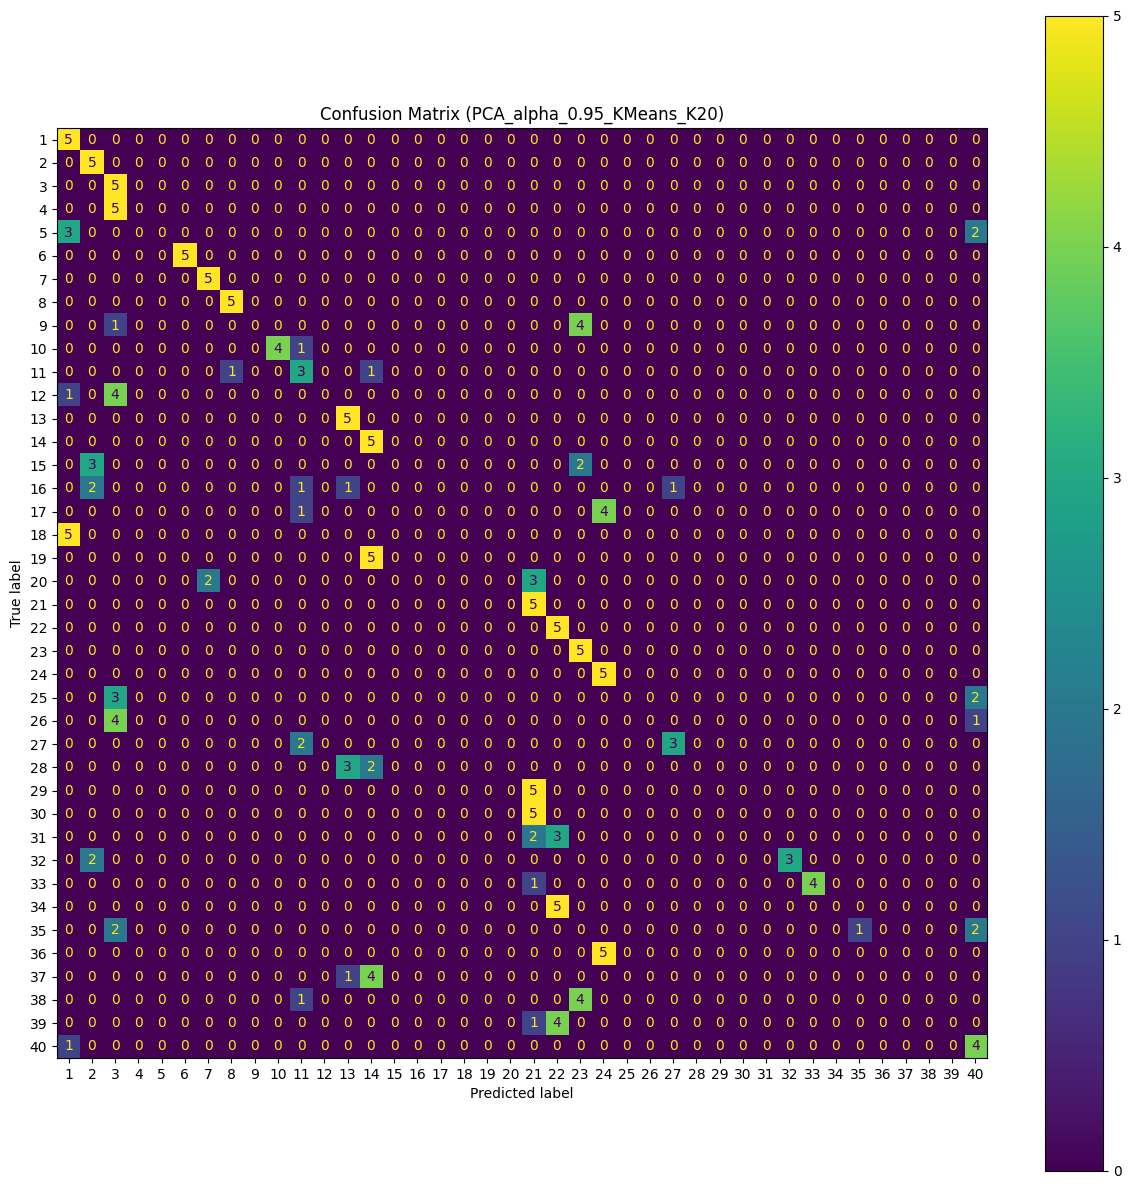


----- Running Experiment: PCA_alpha_0.95_KMeans_K40 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.95}, Classifier K=40
Test Accuracy: 0.6450
Test F1 Score (Weighted): 0.5959
Test F1 Score (Macro): 0.5959


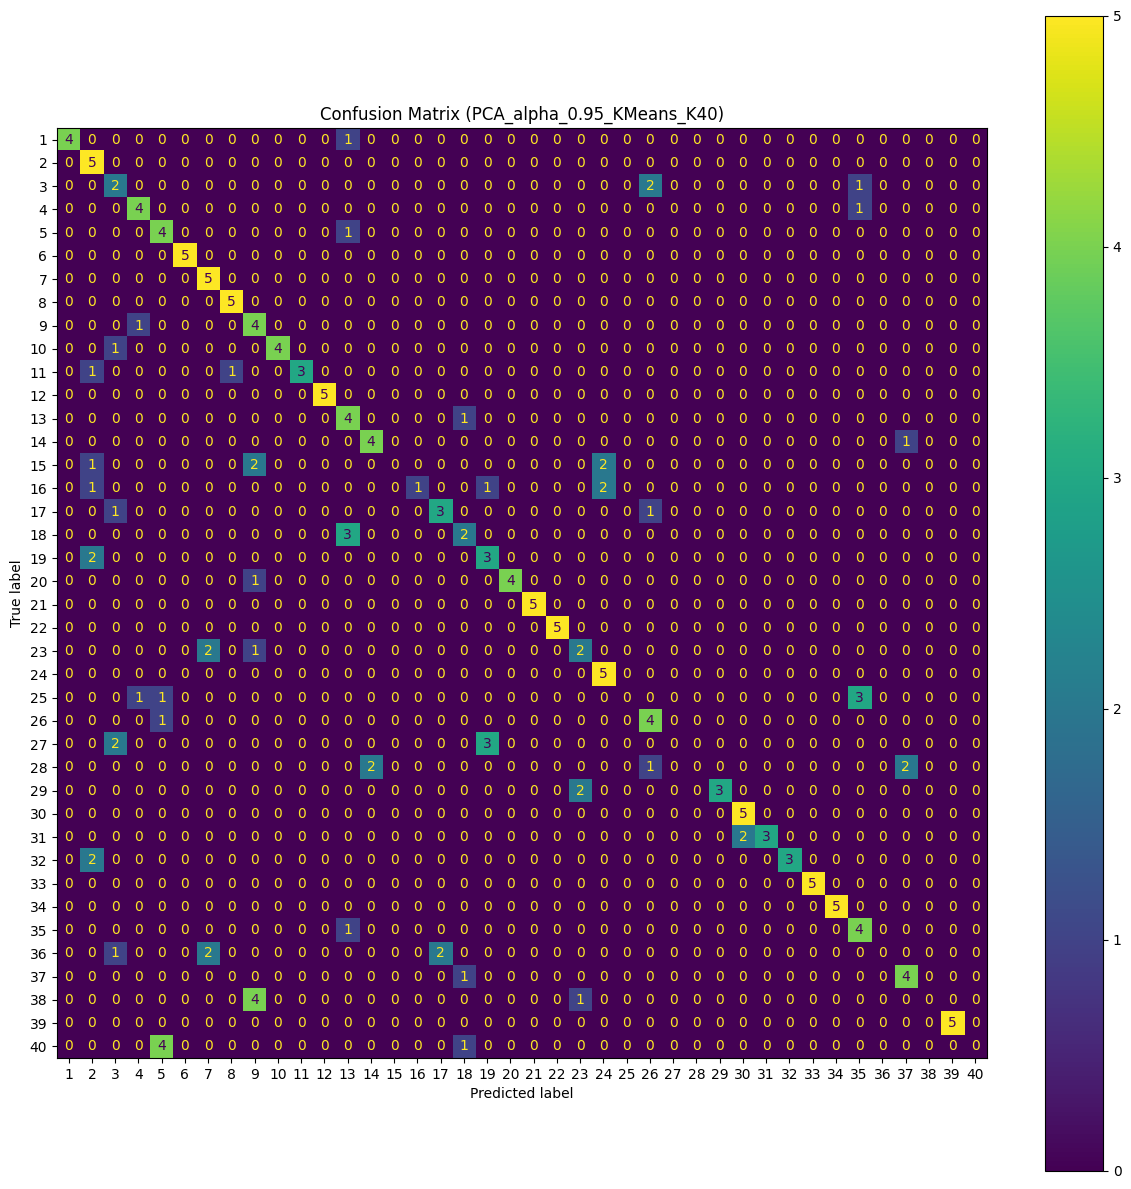


----- Running Experiment: PCA_alpha_0.95_KMeans_K60 -----

--- Evaluating: Projector=PCA, Classifier=KMeans ---
Projection Args: {'alpha': 0.95}, Classifier K=60
Test Accuracy: 0.7250
Test F1 Score (Weighted): 0.6947
Test F1 Score (Macro): 0.6947


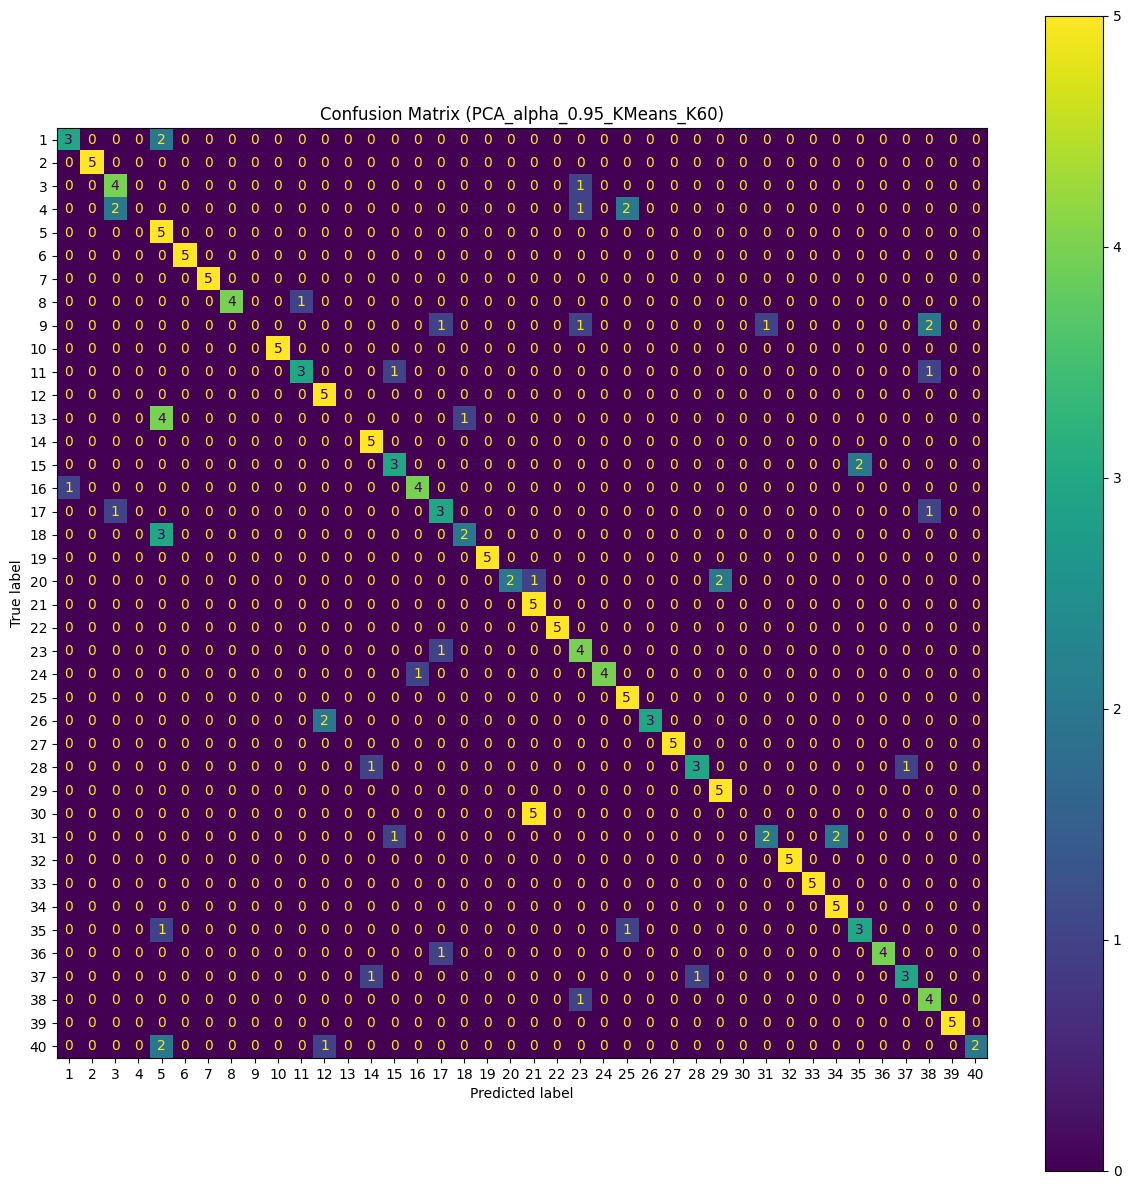


----- Running Experiment: PCA_alpha_0.95_GMM_K20 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.95}, Classifier K=N/A
Converged at iteration 6 for random start 0
Converged at iteration 7 for random start 1
Converged at iteration 12 for random start 2
Converged at iteration 6 for random start 3
Converged at iteration 6 for random start 4
Converged at iteration 6 for random start 5
Converged at iteration 6 for random start 6
Converged at iteration 6 for random start 7
Converged at iteration 6 for random start 8
Converged at iteration 5 for random start 9
Converged at iteration 6 for random start 10
Converged at iteration 5 for random start 11
Converged at iteration 6 for random start 12
Converged at iteration 5 for random start 13
Converged at iteration 5 for random start 14
Converged at iteration 6 for random start 15
Converged at iteration 12 for random start 16
Converged at iteration 6 for random start 17
Converged at iteration 5 for random star

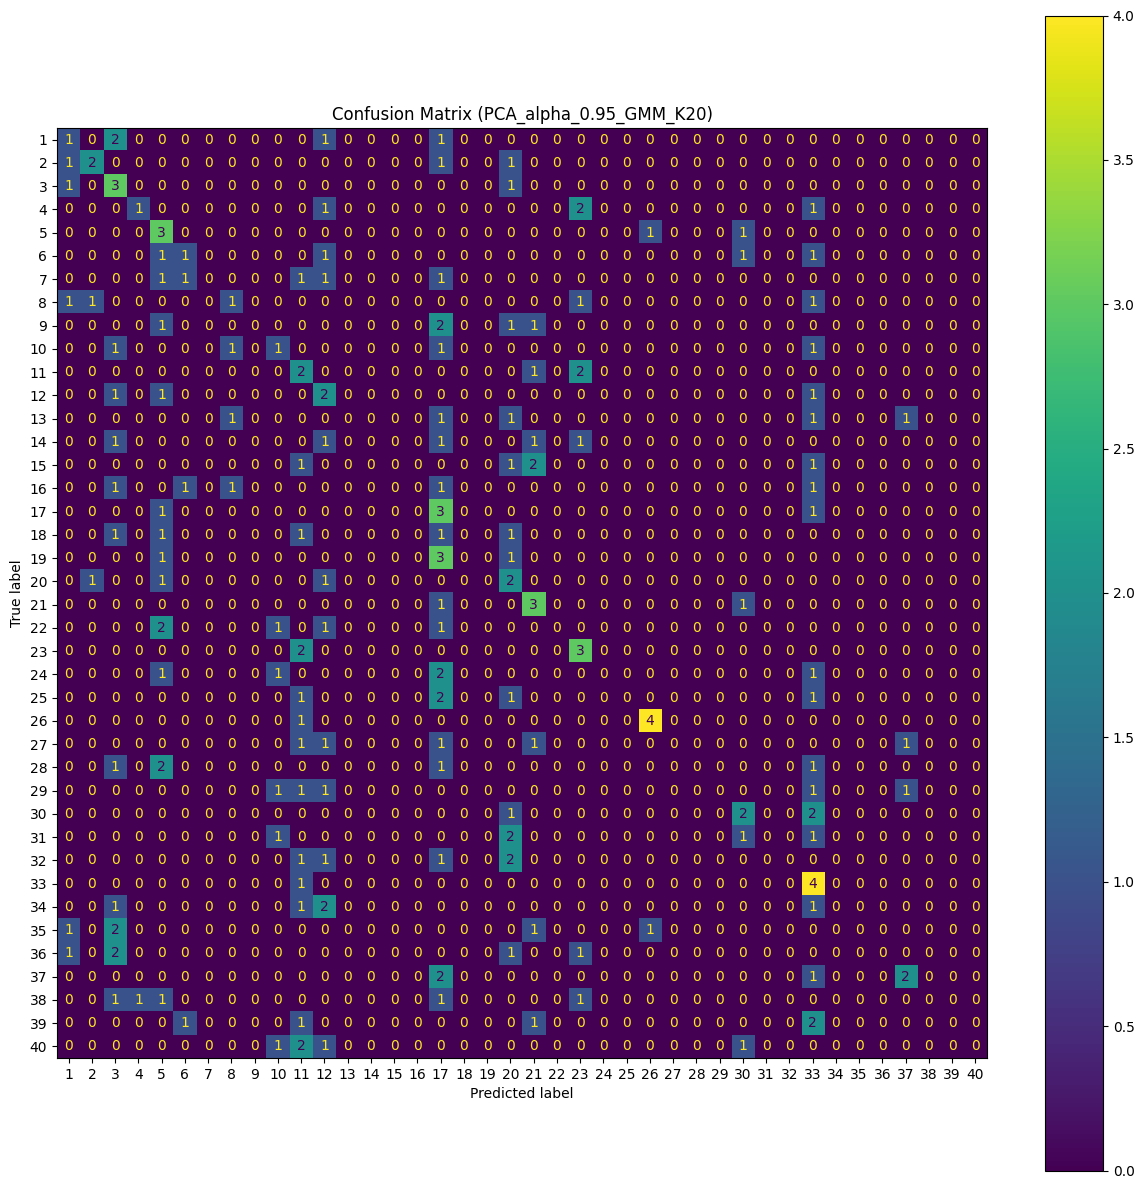


----- Running Experiment: PCA_alpha_0.95_GMM_K40 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.95}, Classifier K=N/A
Converged at iteration 26 for random start 0
Converged at iteration 31 for random start 1
Converged at iteration 37 for random start 2
Converged at iteration 11 for random start 3
Converged at iteration 42 for random start 4
Converged at iteration 6 for random start 5
Converged at iteration 33 for random start 6
Converged at iteration 11 for random start 7
Converged at iteration 41 for random start 8
Converged at iteration 11 for random start 9
Converged at iteration 6 for random start 10
Converged at iteration 14 for random start 11
Converged at iteration 8 for random start 12
Converged at iteration 24 for random start 13
Converged at iteration 6 for random start 14
Converged at iteration 6 for random start 15
Converged at iteration 14 for random start 16
Converged at iteration 9 for random start 17
Converged at iteration 35 for 

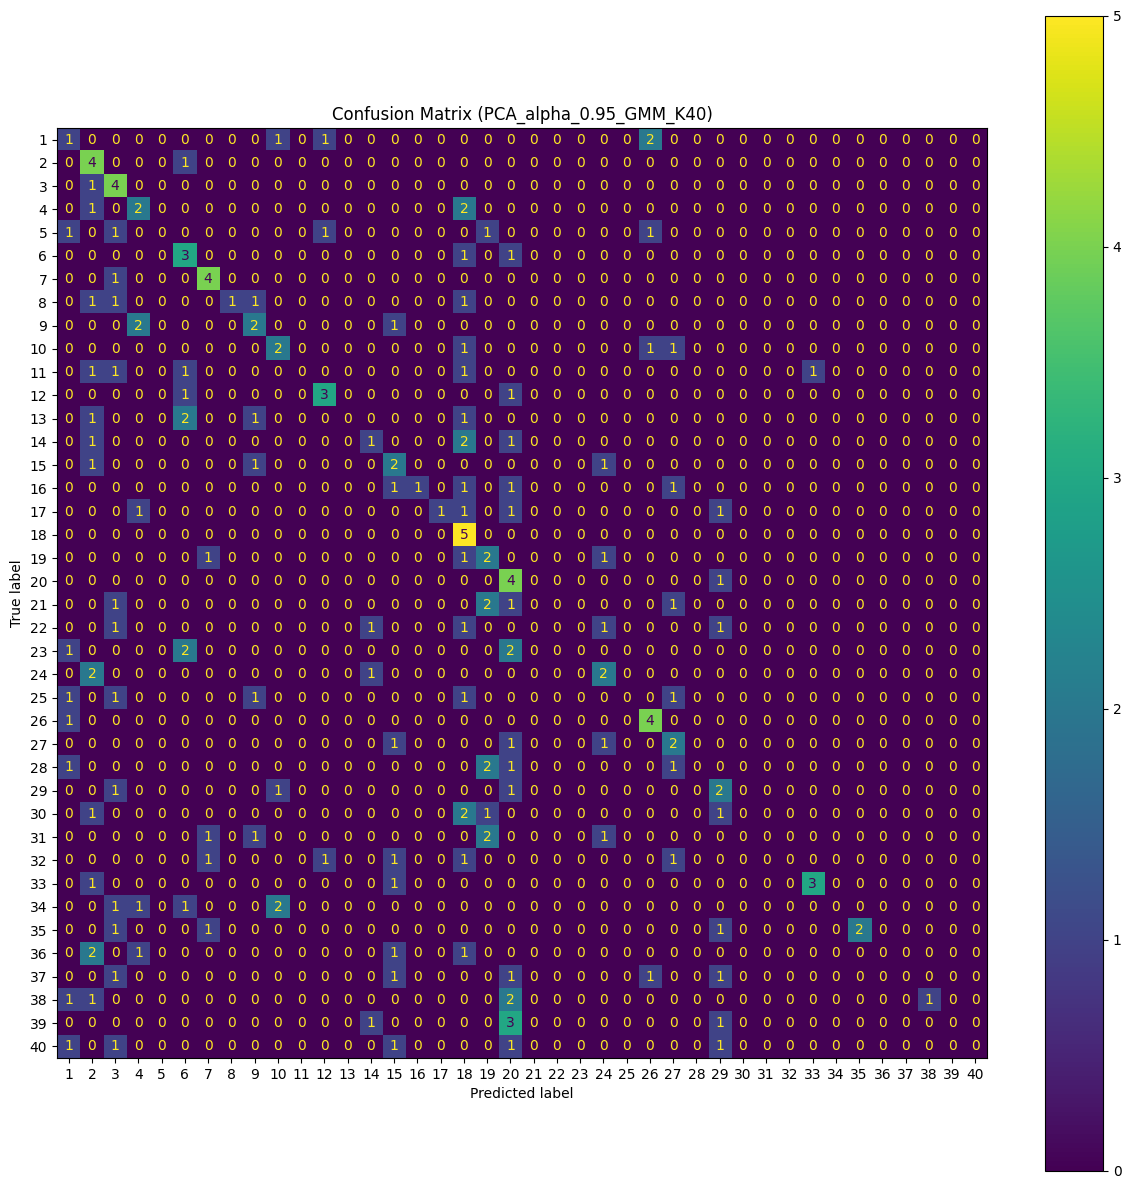


----- Running Experiment: PCA_alpha_0.95_GMM_K60 -----

--- Evaluating: Projector=PCA, Classifier=GMM ---
Projection Args: {'alpha': 0.95}, Classifier K=N/A
Converged at iteration 17 for random start 0
Converged at iteration 30 for random start 1
Converged at iteration 14 for random start 2
Converged at iteration 14 for random start 3
Converged at iteration 67 for random start 4
Converged at iteration 29 for random start 5
Converged at iteration 22 for random start 6
Converged at iteration 55 for random start 7
Converged at iteration 40 for random start 8
Converged at iteration 39 for random start 9
Converged at iteration 23 for random start 10
Converged at iteration 52 for random start 11
Converged at iteration 55 for random start 12
Converged at iteration 40 for random start 13
Converged at iteration 57 for random start 14
Converged at iteration 25 for random start 15
Converged at iteration 11 for random start 16
Converged at iteration 27 for random start 17
Converged at iteration 4

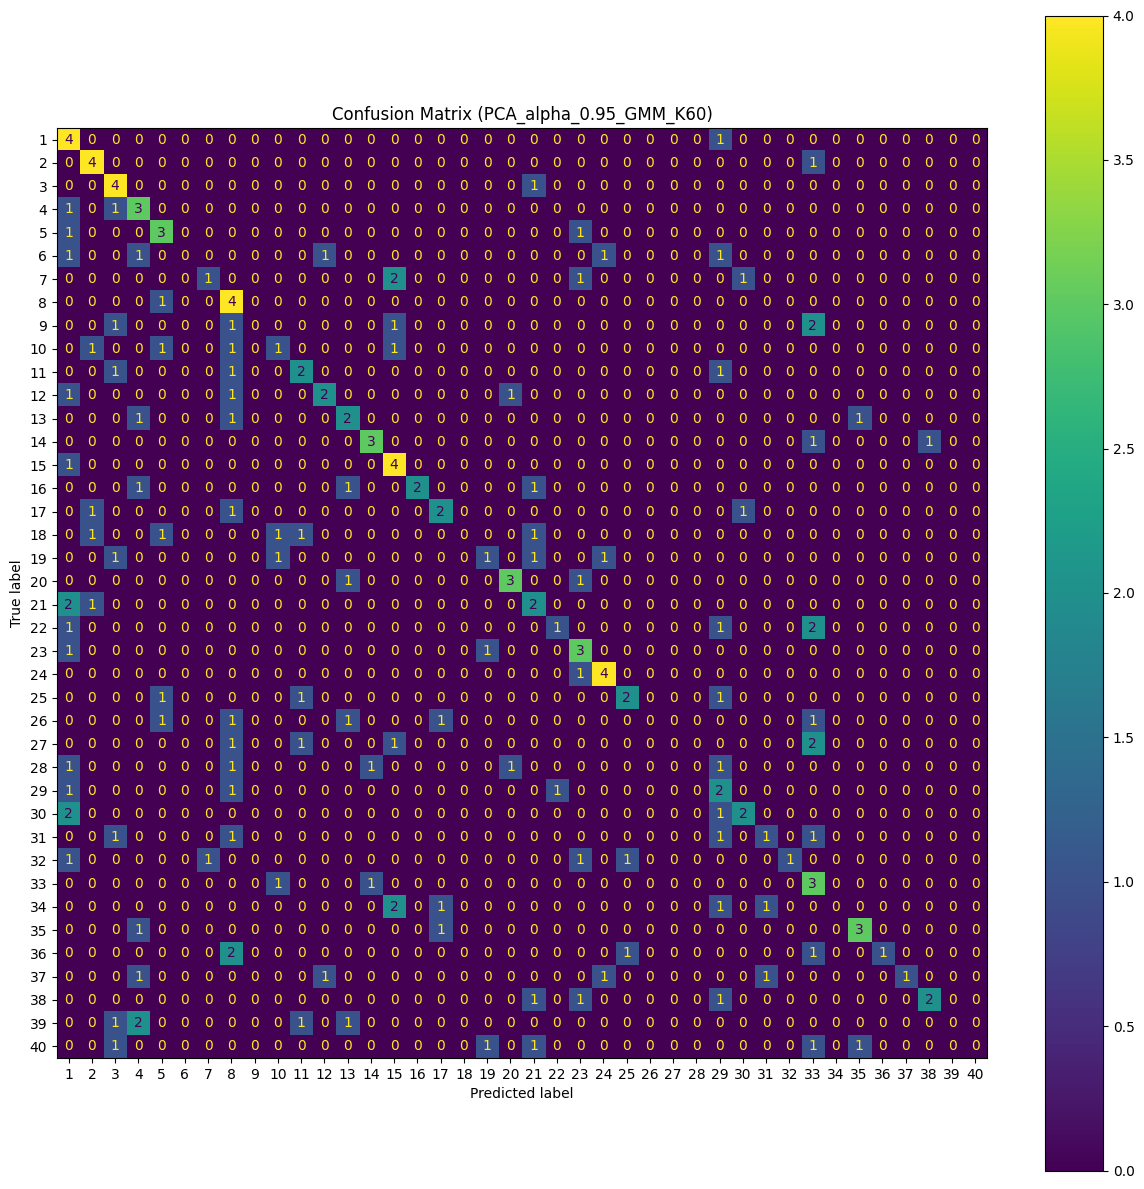



=== Evaluation Results Summary ===
PCA_alpha_0.80_KMeans_K20: Accuracy=0.4350, F1_Weighted=0.3181, F1_Macro=0.3181
PCA_alpha_0.80_KMeans_K40: Accuracy=0.6550, F1_Weighted=0.6160, F1_Macro=0.6160
PCA_alpha_0.80_KMeans_K60: Accuracy=0.7900, F1_Weighted=0.7630, F1_Macro=0.7630
PCA_alpha_0.80_GMM_K20: Accuracy=0.2800, F1_Weighted=0.1845, F1_Macro=0.1845
PCA_alpha_0.80_GMM_K40: Accuracy=0.4000, F1_Weighted=0.3320, F1_Macro=0.3320
PCA_alpha_0.80_GMM_K60: Accuracy=0.4850, F1_Weighted=0.4591, F1_Macro=0.4591
PCA_alpha_0.85_KMeans_K20: Accuracy=0.4750, F1_Weighted=0.3479, F1_Macro=0.3479
PCA_alpha_0.85_KMeans_K40: Accuracy=0.6450, F1_Weighted=0.6014, F1_Macro=0.6014
PCA_alpha_0.85_KMeans_K60: Accuracy=0.7550, F1_Weighted=0.7411, F1_Macro=0.7411
PCA_alpha_0.85_GMM_K20: Accuracy=0.2300, F1_Weighted=0.1298, F1_Macro=0.1298
PCA_alpha_0.85_GMM_K40: Accuracy=0.3850, F1_Weighted=0.3205, F1_Macro=0.3205
PCA_alpha_0.85_GMM_K60: Accuracy=0.4550, F1_Weighted=0.4209, F1_Macro=0.4209
PCA_alpha_0.90_KMeans

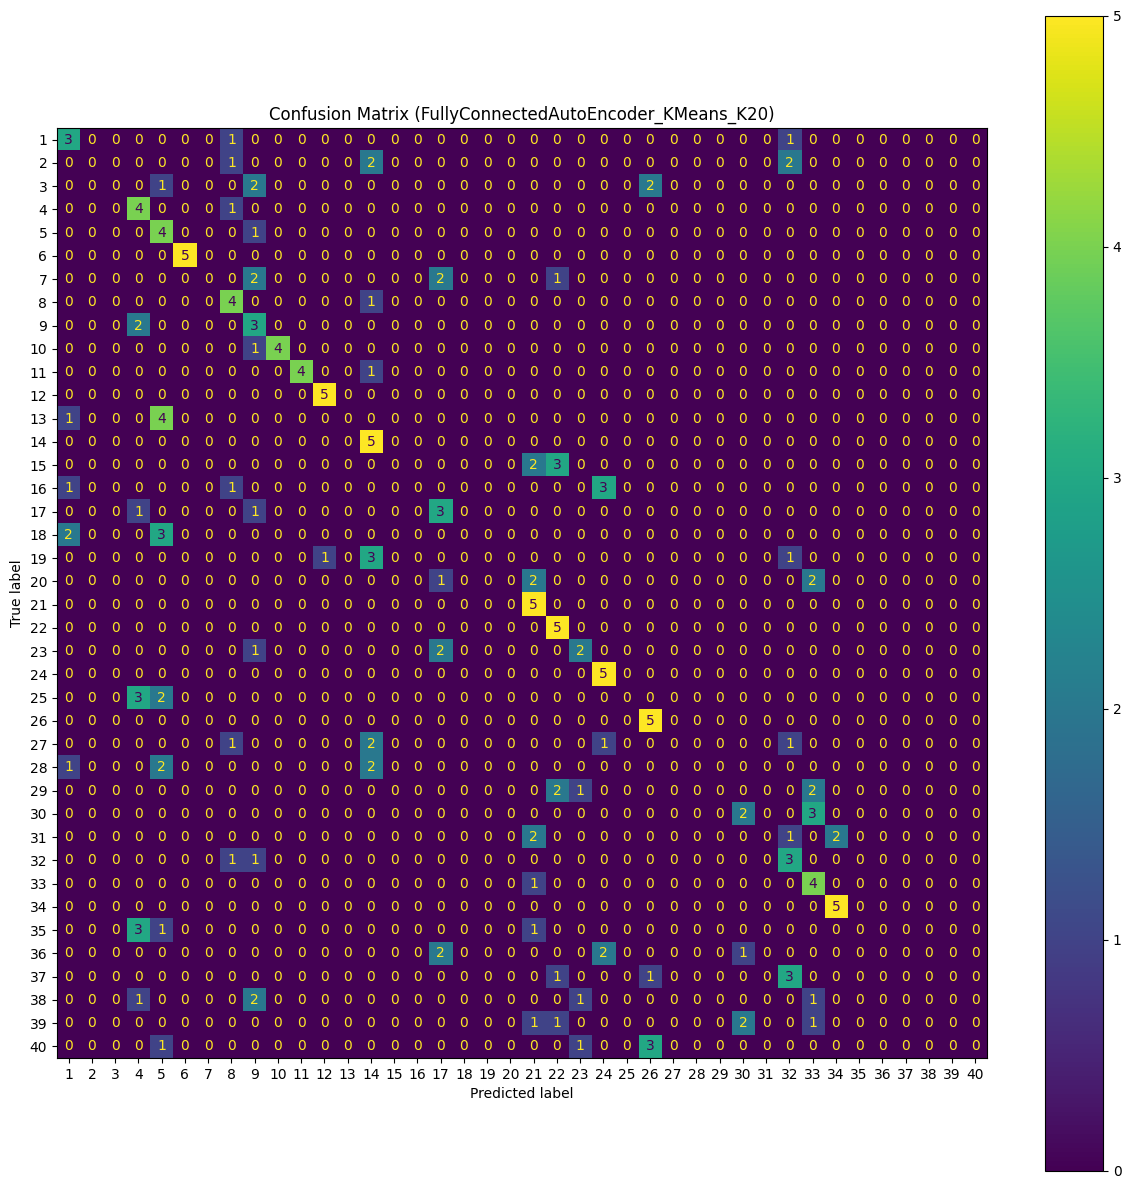


----- Running Experiment: FullyConnectedAutoEncoder_KMeans_K40 -----

--- Evaluating: Projector=FullyConnectedAutoencoder, Classifier=KMeans ---
Projection Args: {}, Classifier K=40
Test Accuracy: 0.6400
Test F1 Score (Weighted): 0.5976
Test F1 Score (Macro): 0.5976


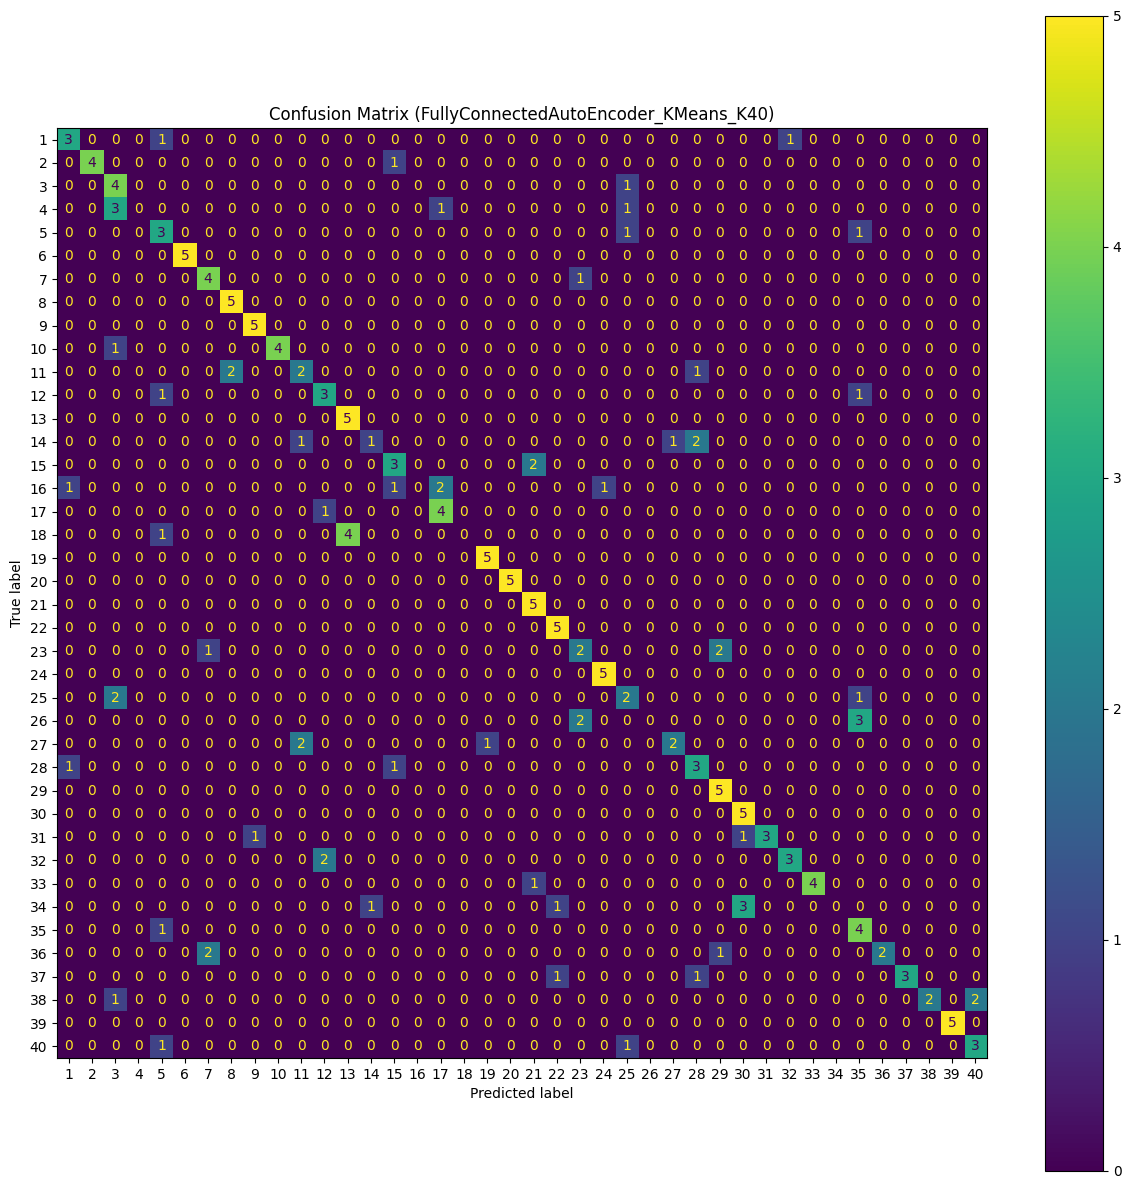


----- Running Experiment: FullyConnectedAutoEncoder_KMeans_K60 -----

--- Evaluating: Projector=FullyConnectedAutoencoder, Classifier=KMeans ---
Projection Args: {}, Classifier K=60
Test Accuracy: 0.7200
Test F1 Score (Weighted): 0.6959
Test F1 Score (Macro): 0.6959


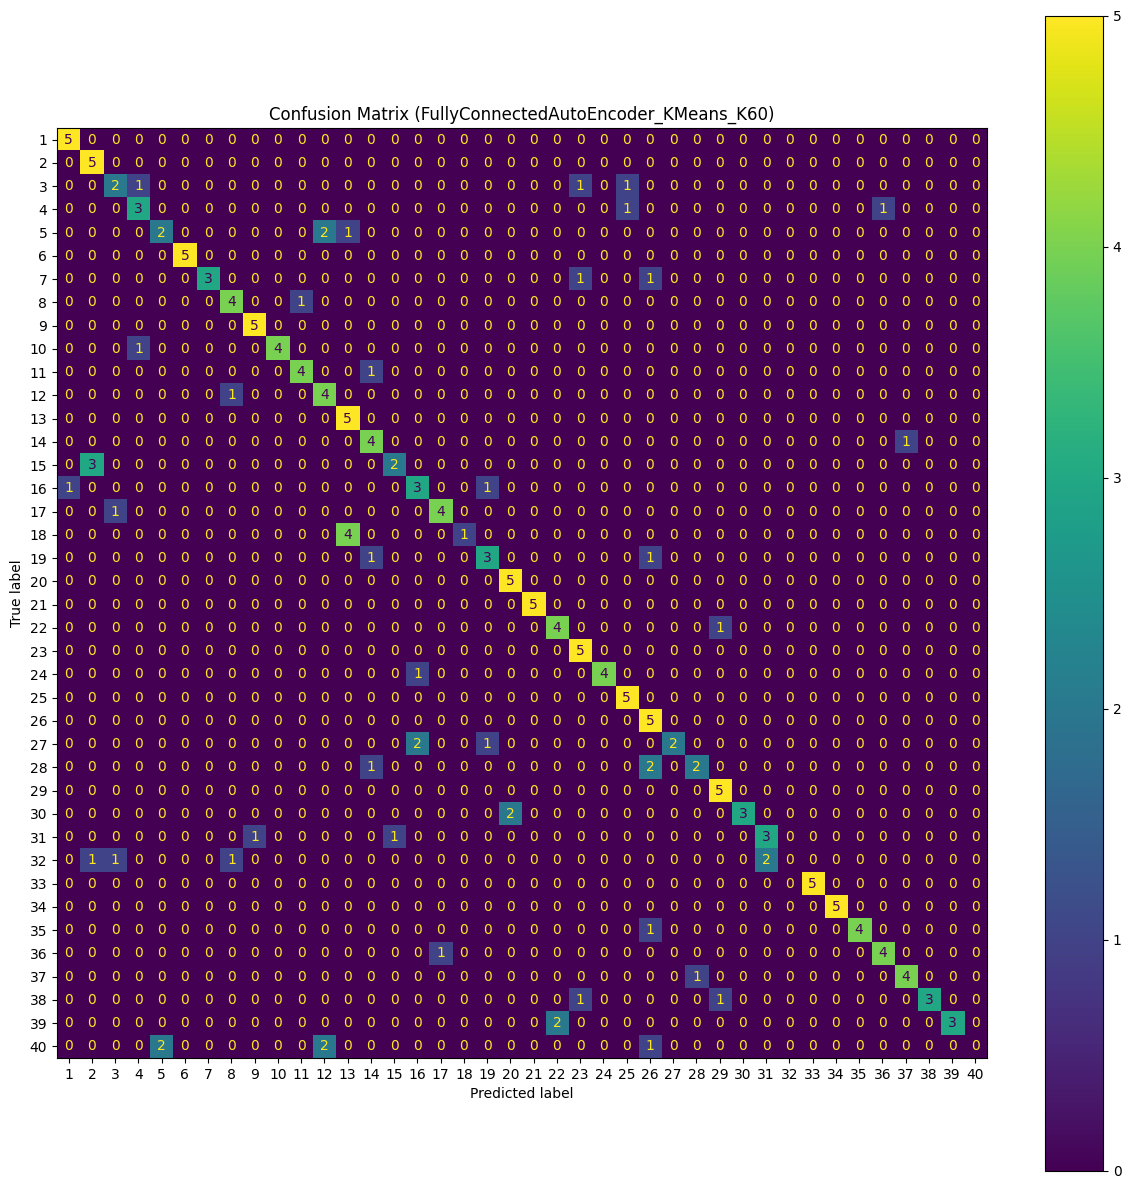


----- Running Experiment: FullyConnectedAutoEncoder_GMM_K20 -----

--- Evaluating: Projector=FullyConnectedAutoencoder, Classifier=GMM ---
Projection Args: {}, Classifier K=N/A
Converged at iteration 5 for random start 0
Converged at iteration 7 for random start 1
Converged at iteration 13 for random start 2
Converged at iteration 6 for random start 3
Converged at iteration 6 for random start 4
Converged at iteration 6 for random start 5
Converged at iteration 6 for random start 6
Converged at iteration 6 for random start 7
Converged at iteration 13 for random start 8
Converged at iteration 5 for random start 9
Converged at iteration 6 for random start 10
Converged at iteration 6 for random start 11
Converged at iteration 5 for random start 12
Converged at iteration 8 for random start 13
Converged at iteration 6 for random start 14
Converged at iteration 8 for random start 15
Converged at iteration 6 for random start 16
Converged at iteration 6 for random start 17
Converged at iterati

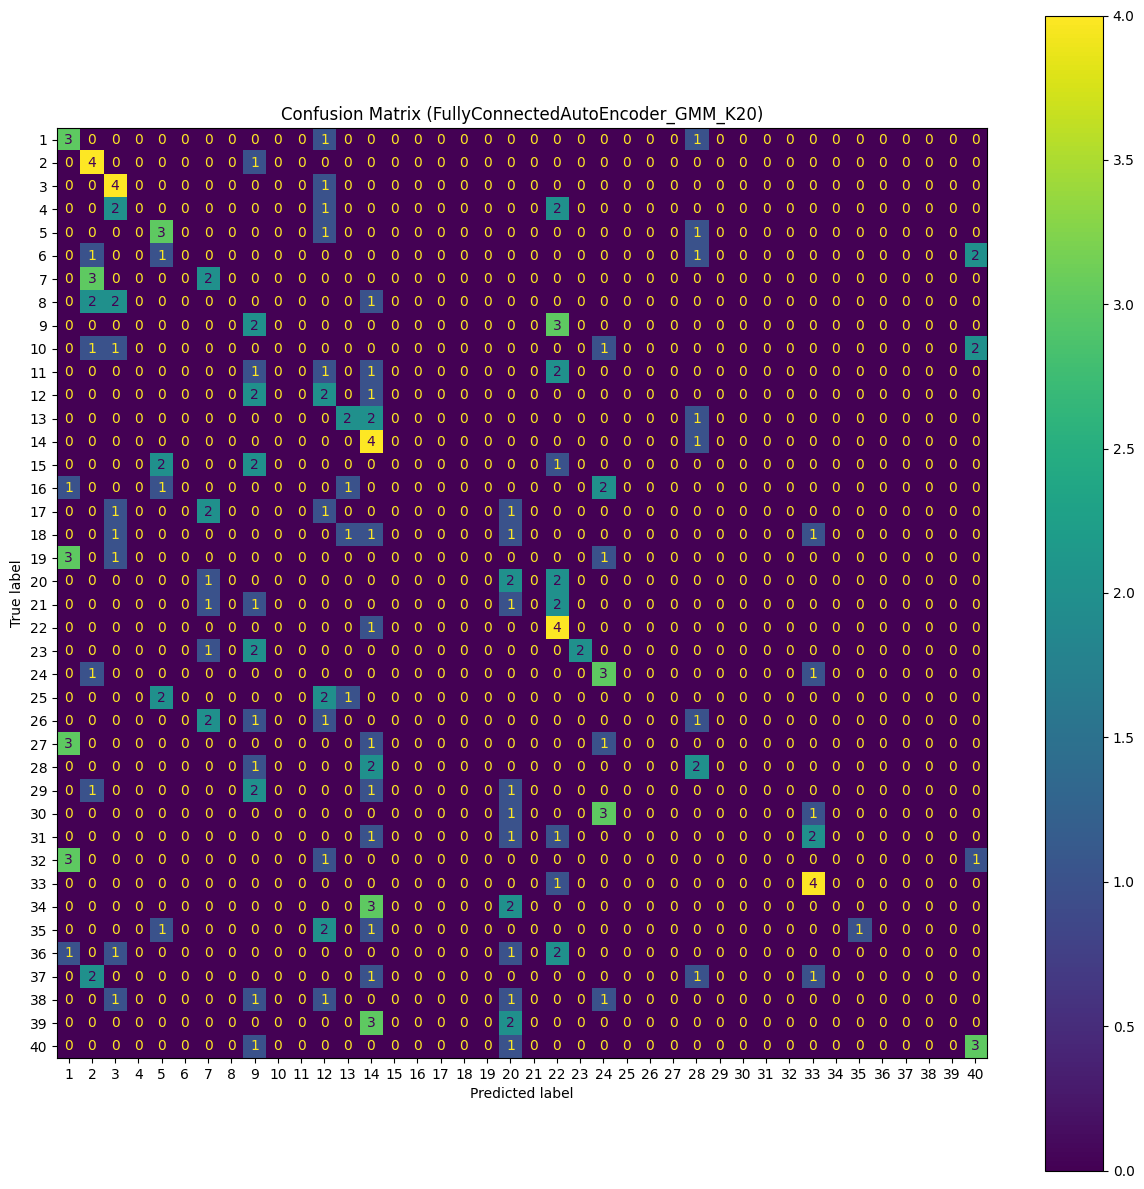


----- Running Experiment: FullyConnectedAutoEncoder_GMM_K40 -----

--- Evaluating: Projector=FullyConnectedAutoencoder, Classifier=GMM ---
Projection Args: {}, Classifier K=N/A
Converged at iteration 36 for random start 0
Converged at iteration 44 for random start 1
Converged at iteration 55 for random start 2
Converged at iteration 27 for random start 3
Converged at iteration 36 for random start 4
Converged at iteration 10 for random start 5
Converged at iteration 7 for random start 6
Converged at iteration 27 for random start 7
Converged at iteration 20 for random start 8
Converged at iteration 16 for random start 9
Converged at iteration 7 for random start 10
Converged at iteration 24 for random start 11
Converged at iteration 33 for random start 12
Converged at iteration 8 for random start 13
Converged at iteration 44 for random start 14
Converged at iteration 40 for random start 15
Converged at iteration 58 for random start 16
Converged at iteration 7 for random start 17
Converge

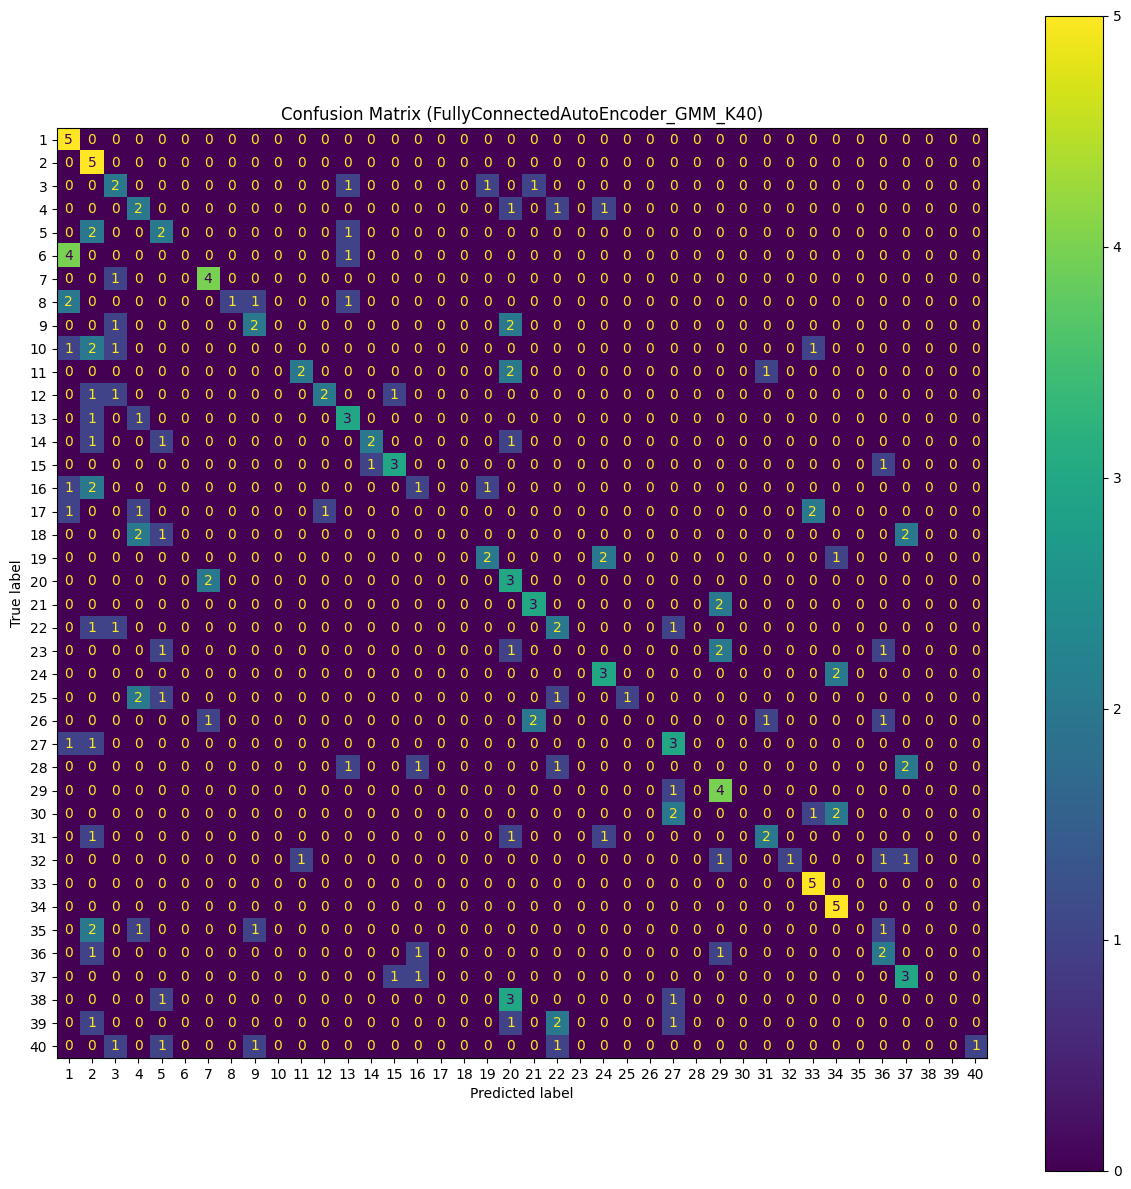


----- Running Experiment: FullyConnectedAutoEncoder_GMM_K60 -----

--- Evaluating: Projector=FullyConnectedAutoencoder, Classifier=GMM ---
Projection Args: {}, Classifier K=N/A
Converged at iteration 23 for random start 0
Converged at iteration 24 for random start 1
Converged at iteration 16 for random start 2
Converged at iteration 26 for random start 3
Converged at iteration 23 for random start 4
Converged at iteration 29 for random start 5
Converged at iteration 29 for random start 6
Converged at iteration 31 for random start 7
Converged at iteration 22 for random start 8
Converged at iteration 29 for random start 9
Converged at iteration 32 for random start 10
Converged at iteration 23 for random start 11
Converged at iteration 35 for random start 12
Converged at iteration 37 for random start 13
Converged at iteration 16 for random start 14
Converged at iteration 35 for random start 15
Converged at iteration 43 for random start 16
Converged at iteration 31 for random start 17
Conv

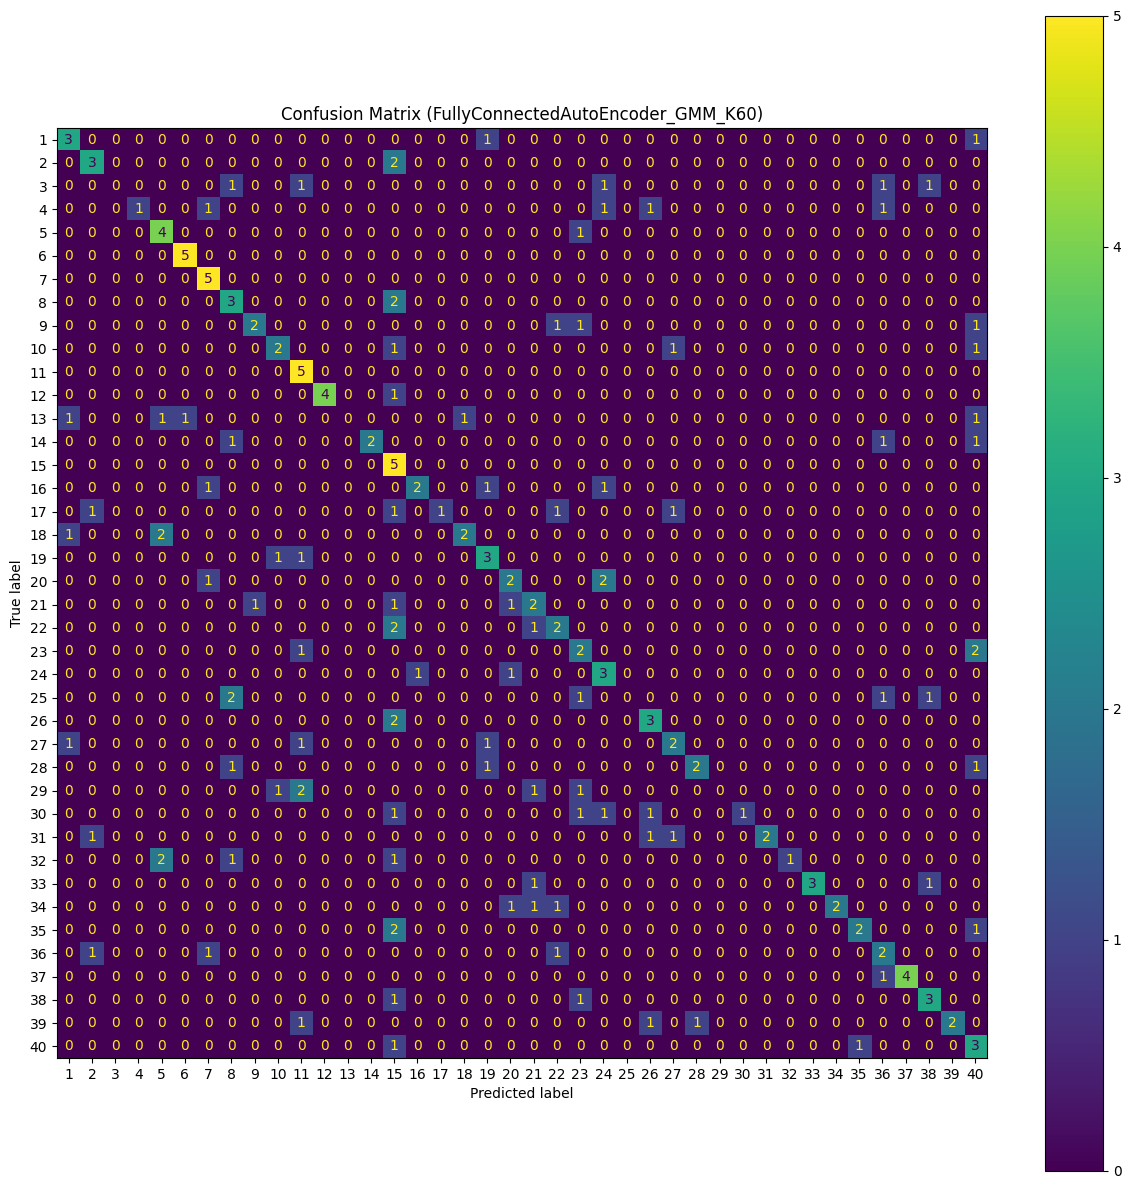



=== Evaluation Results Summary ===
PCA_alpha_0.80_KMeans_K20: Accuracy=0.4350, F1_Weighted=0.3181, F1_Macro=0.3181
PCA_alpha_0.80_KMeans_K40: Accuracy=0.6550, F1_Weighted=0.6160, F1_Macro=0.6160
PCA_alpha_0.80_KMeans_K60: Accuracy=0.7900, F1_Weighted=0.7630, F1_Macro=0.7630
PCA_alpha_0.80_GMM_K20: Accuracy=0.2800, F1_Weighted=0.1845, F1_Macro=0.1845
PCA_alpha_0.80_GMM_K40: Accuracy=0.4000, F1_Weighted=0.3320, F1_Macro=0.3320
PCA_alpha_0.80_GMM_K60: Accuracy=0.4850, F1_Weighted=0.4591, F1_Macro=0.4591
PCA_alpha_0.85_KMeans_K20: Accuracy=0.4750, F1_Weighted=0.3479, F1_Macro=0.3479
PCA_alpha_0.85_KMeans_K40: Accuracy=0.6450, F1_Weighted=0.6014, F1_Macro=0.6014
PCA_alpha_0.85_KMeans_K60: Accuracy=0.7550, F1_Weighted=0.7411, F1_Macro=0.7411
PCA_alpha_0.85_GMM_K20: Accuracy=0.2300, F1_Weighted=0.1298, F1_Macro=0.1298
PCA_alpha_0.85_GMM_K40: Accuracy=0.3850, F1_Weighted=0.3205, F1_Macro=0.3205
PCA_alpha_0.85_GMM_K60: Accuracy=0.4550, F1_Weighted=0.4209, F1_Macro=0.4209
PCA_alpha_0.90_KMeans

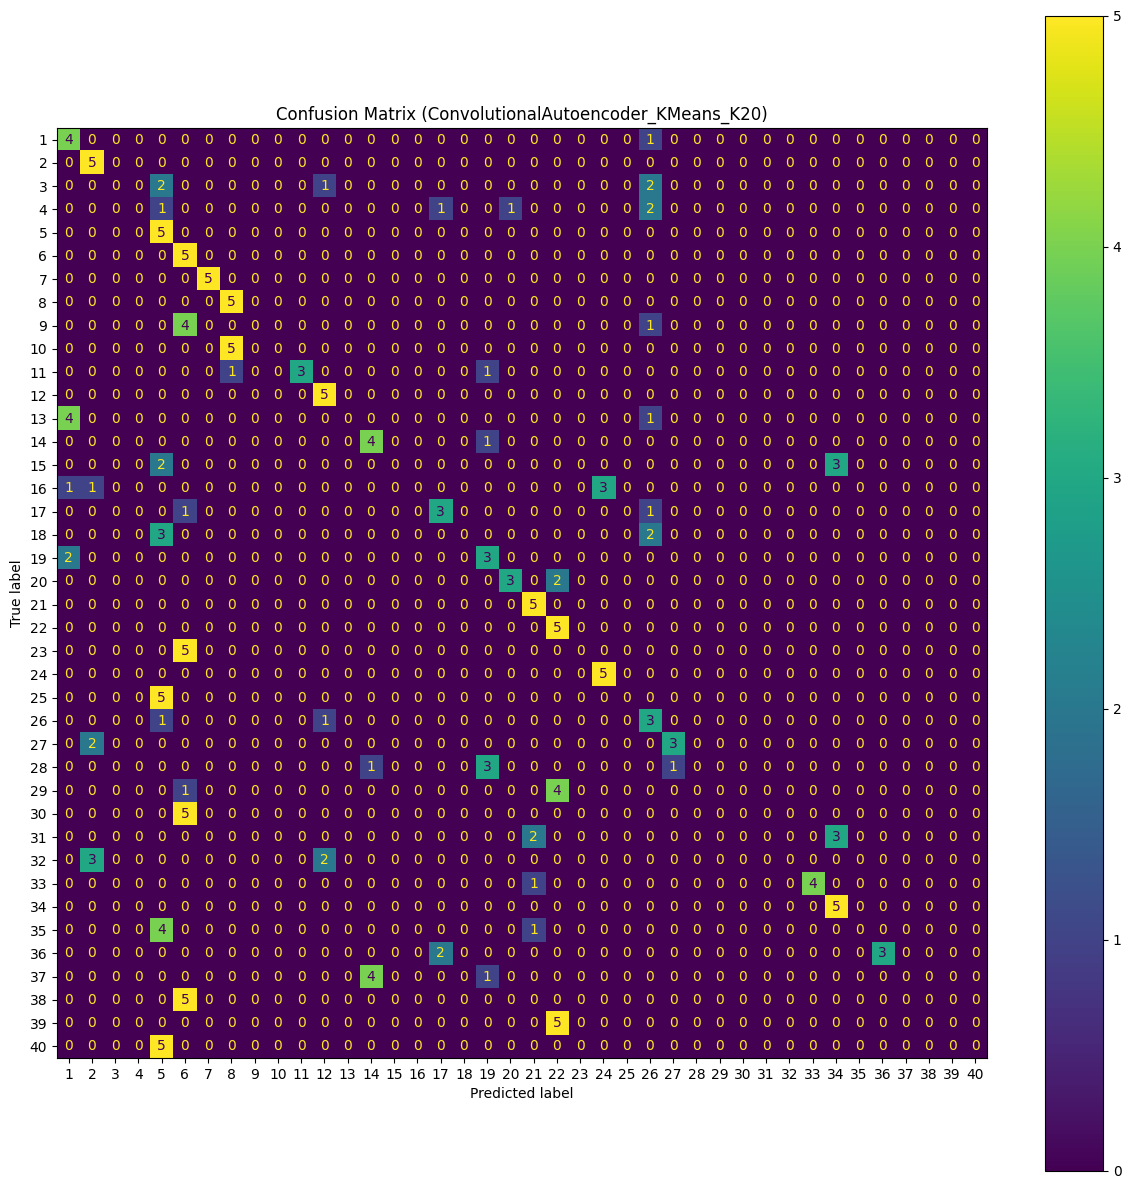


----- Running Experiment: ConvolutionalAutoencoder_KMeans_K40 -----

--- Evaluating: Projector=ConvolutionalAutoencoder, Classifier=KMeans ---
Projection Args: {}, Classifier K=40
Test Accuracy: 0.6650
Test F1 Score (Weighted): 0.6228
Test F1 Score (Macro): 0.6228


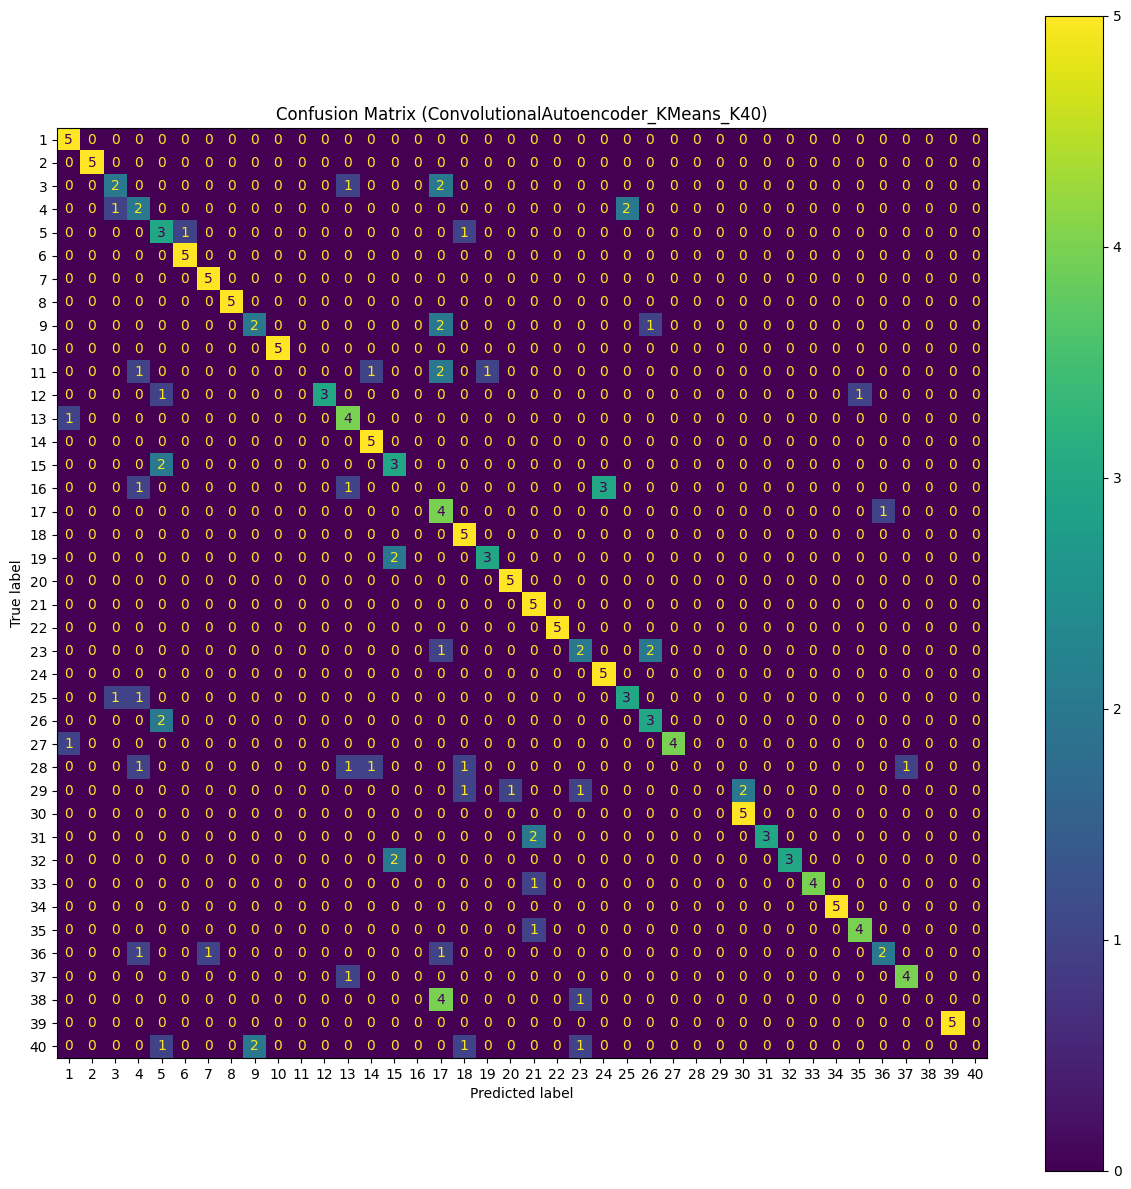


----- Running Experiment: ConvolutionalAutoencoder_KMeans_K60 -----

--- Evaluating: Projector=ConvolutionalAutoencoder, Classifier=KMeans ---
Projection Args: {}, Classifier K=60
Test Accuracy: 0.8100
Test F1 Score (Weighted): 0.7772
Test F1 Score (Macro): 0.7772


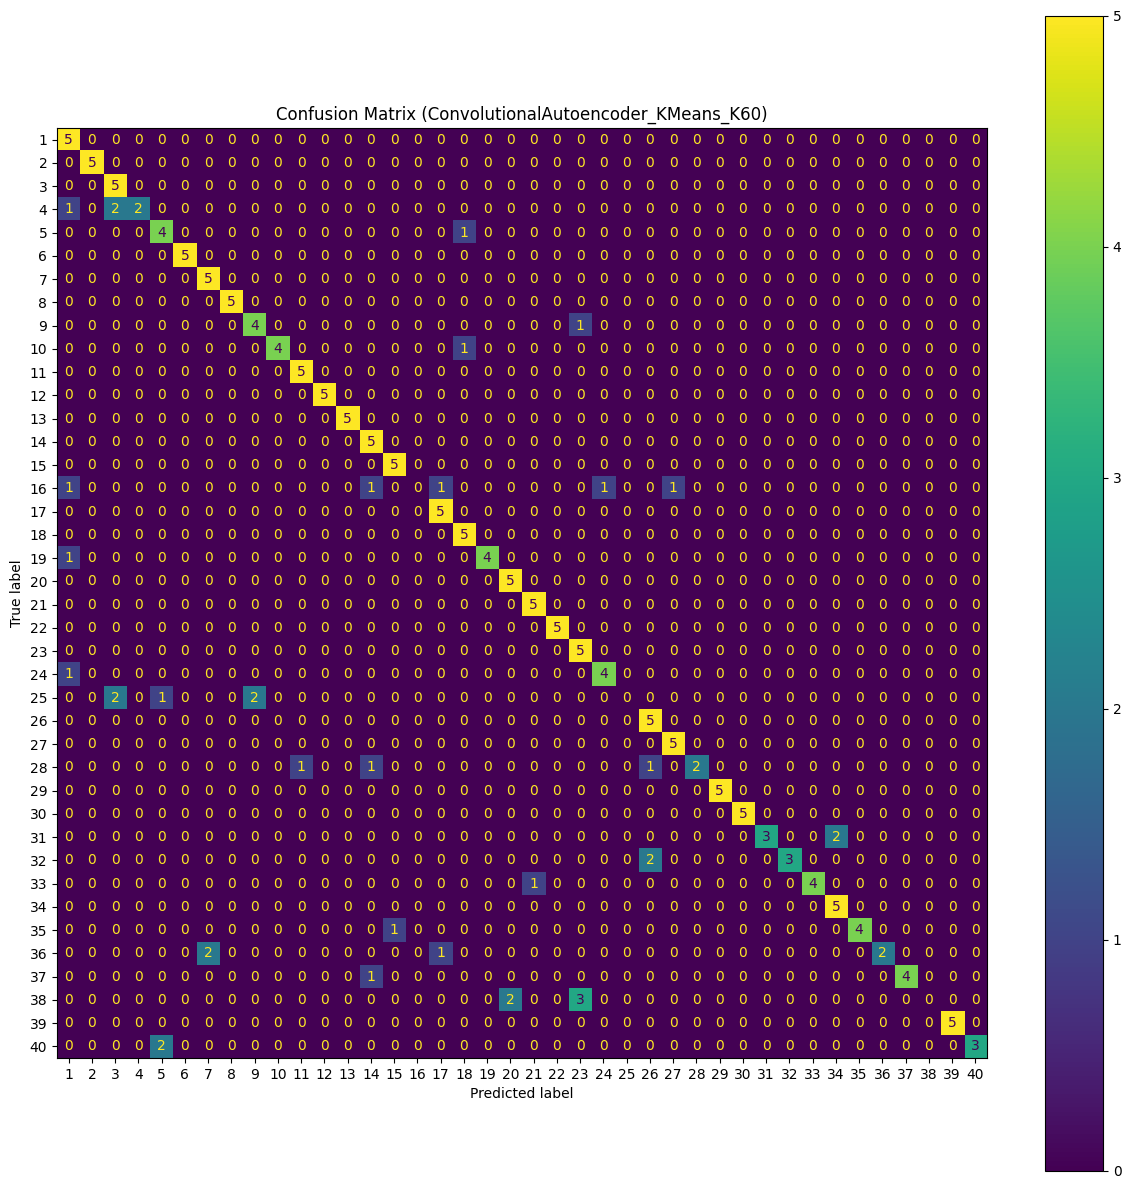


----- Running Experiment: ConvolutionalAutoencoder_GMM_K20 -----

--- Evaluating: Projector=ConvolutionalAutoencoder, Classifier=GMM ---
Projection Args: {}, Classifier K=N/A
Converged at iteration 5 for random start 0
Converged at iteration 6 for random start 1
Converged at iteration 11 for random start 2
Converged at iteration 6 for random start 3
Converged at iteration 5 for random start 4
Converged at iteration 8 for random start 5
Converged at iteration 6 for random start 6
Converged at iteration 5 for random start 7
Converged at iteration 8 for random start 8
Converged at iteration 7 for random start 9
Converged at iteration 5 for random start 10
Converged at iteration 6 for random start 11
Converged at iteration 7 for random start 12
Converged at iteration 5 for random start 13
Converged at iteration 5 for random start 14
Converged at iteration 6 for random start 15
Converged at iteration 5 for random start 16
Converged at iteration 5 for random start 17
Converged at iteration 

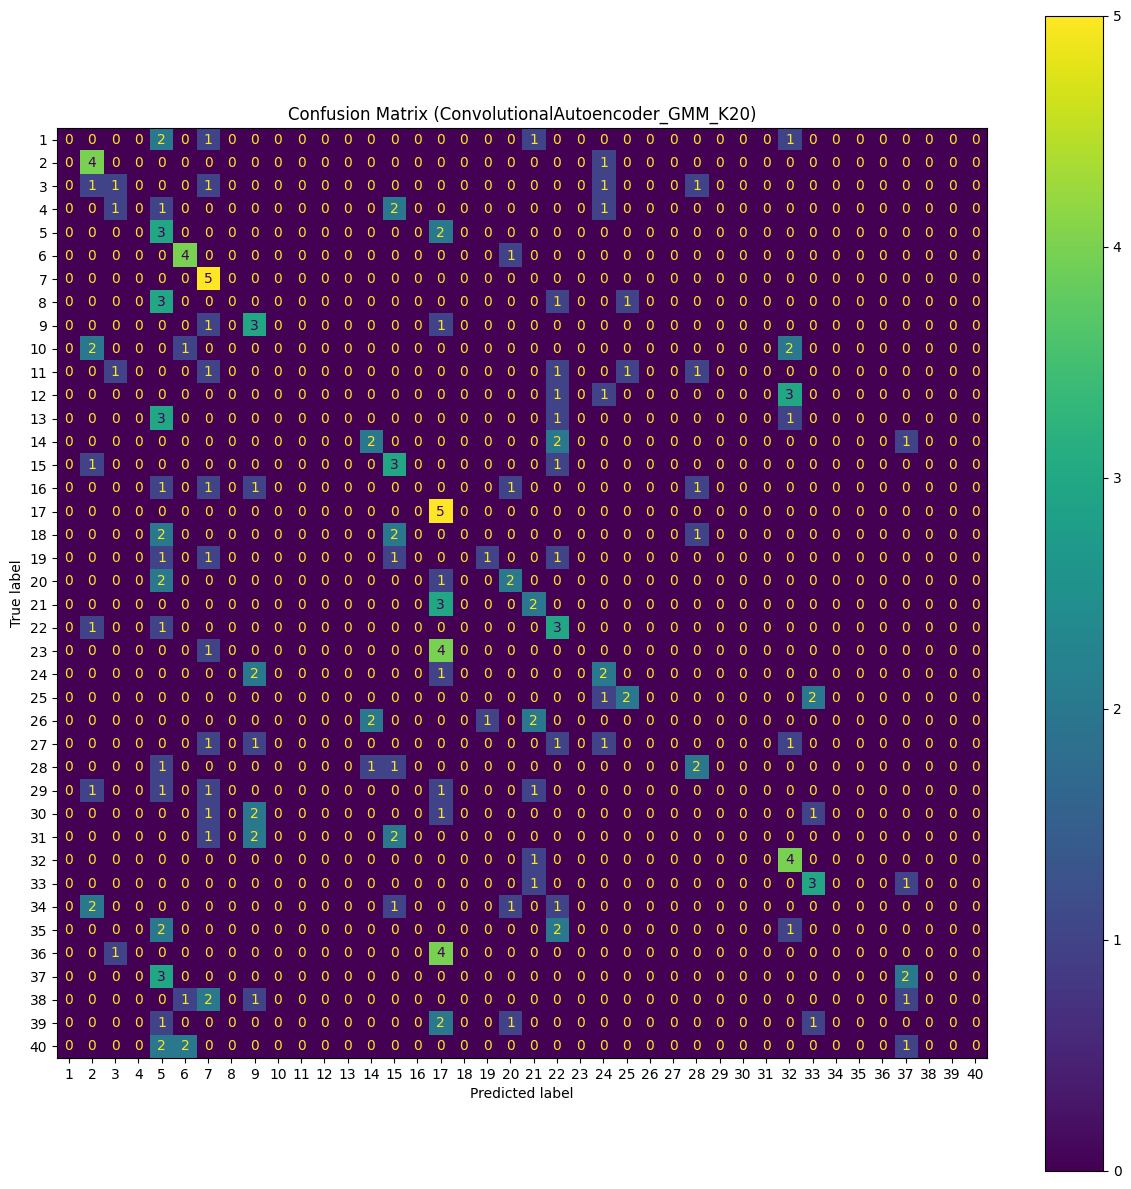


----- Running Experiment: ConvolutionalAutoencoder_GMM_K40 -----

--- Evaluating: Projector=ConvolutionalAutoencoder, Classifier=GMM ---
Projection Args: {}, Classifier K=N/A
Converged at iteration 24 for random start 0
Converged at iteration 32 for random start 1
Converged at iteration 39 for random start 2
Converged at iteration 34 for random start 3
Converged at iteration 14 for random start 4
Converged at iteration 13 for random start 5
Converged at iteration 21 for random start 6
Converged at iteration 13 for random start 7
Converged at iteration 17 for random start 8
Converged at iteration 31 for random start 9
Converged at iteration 8 for random start 10
Converged at iteration 28 for random start 11
Converged at iteration 16 for random start 12
Converged at iteration 36 for random start 13
Converged at iteration 18 for random start 14
Converged at iteration 13 for random start 15
Converged at iteration 18 for random start 16
Converged at iteration 11 for random start 17
Converg

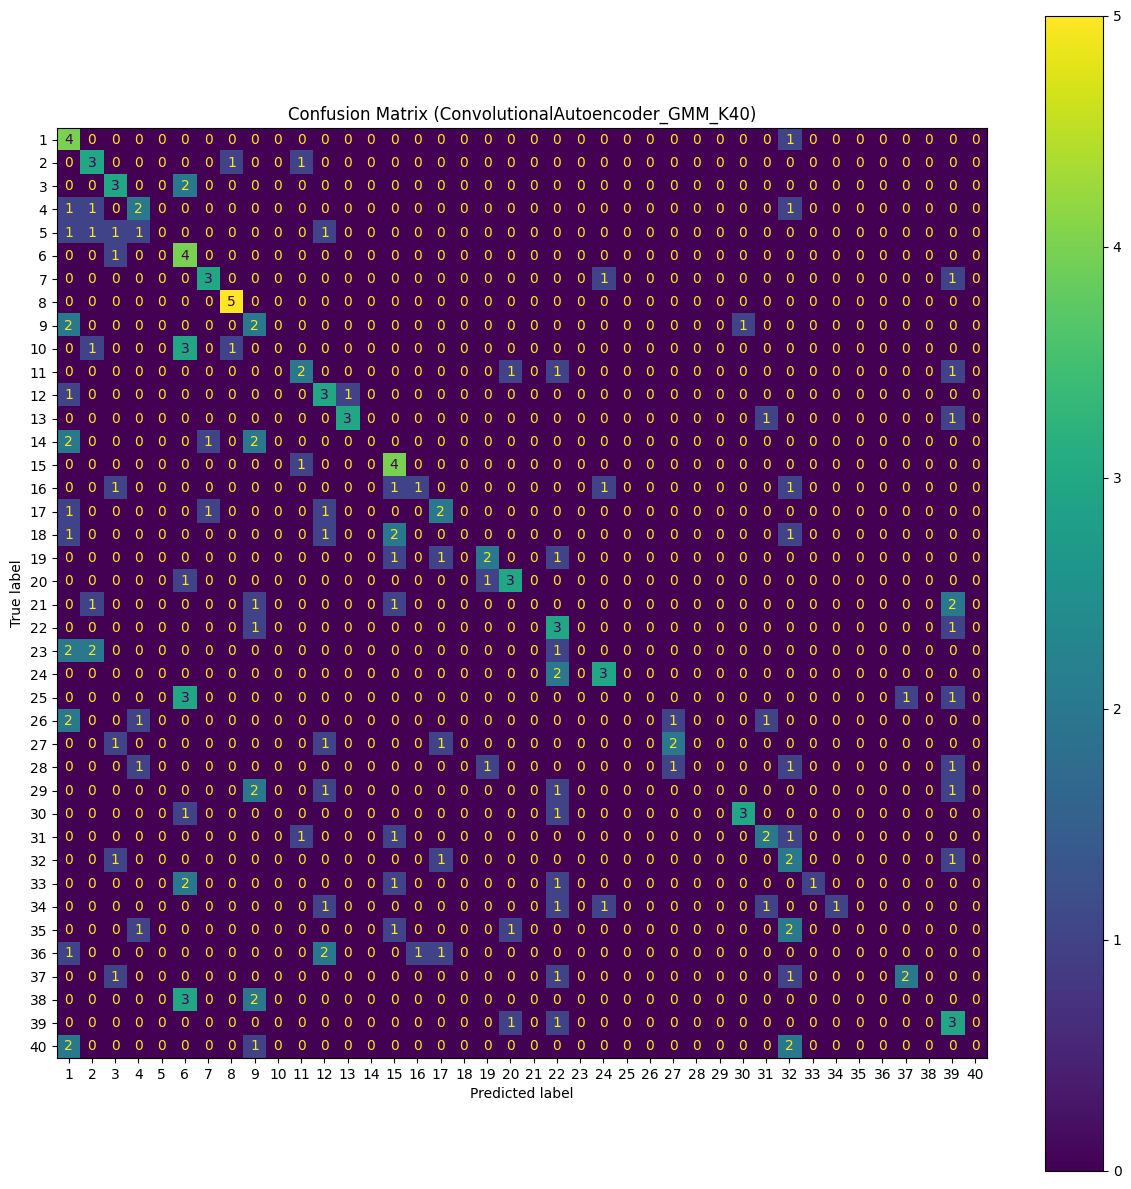


----- Running Experiment: ConvolutionalAutoencoder_GMM_K60 -----

--- Evaluating: Projector=ConvolutionalAutoencoder, Classifier=GMM ---
Projection Args: {}, Classifier K=N/A
Converged at iteration 18 for random start 0
Converged at iteration 33 for random start 1
Converged at iteration 16 for random start 2
Converged at iteration 48 for random start 3
Converged at iteration 52 for random start 4
Converged at iteration 19 for random start 5
Converged at iteration 36 for random start 6
Converged at iteration 27 for random start 7
Converged at iteration 37 for random start 8
Converged at iteration 27 for random start 9
Converged at iteration 42 for random start 10
Converged at iteration 22 for random start 11
Converged at iteration 38 for random start 12
Converged at iteration 42 for random start 13
Converged at iteration 31 for random start 14
Converged at iteration 34 for random start 15
Converged at iteration 48 for random start 16
Converged at iteration 12 for random start 17
Conver

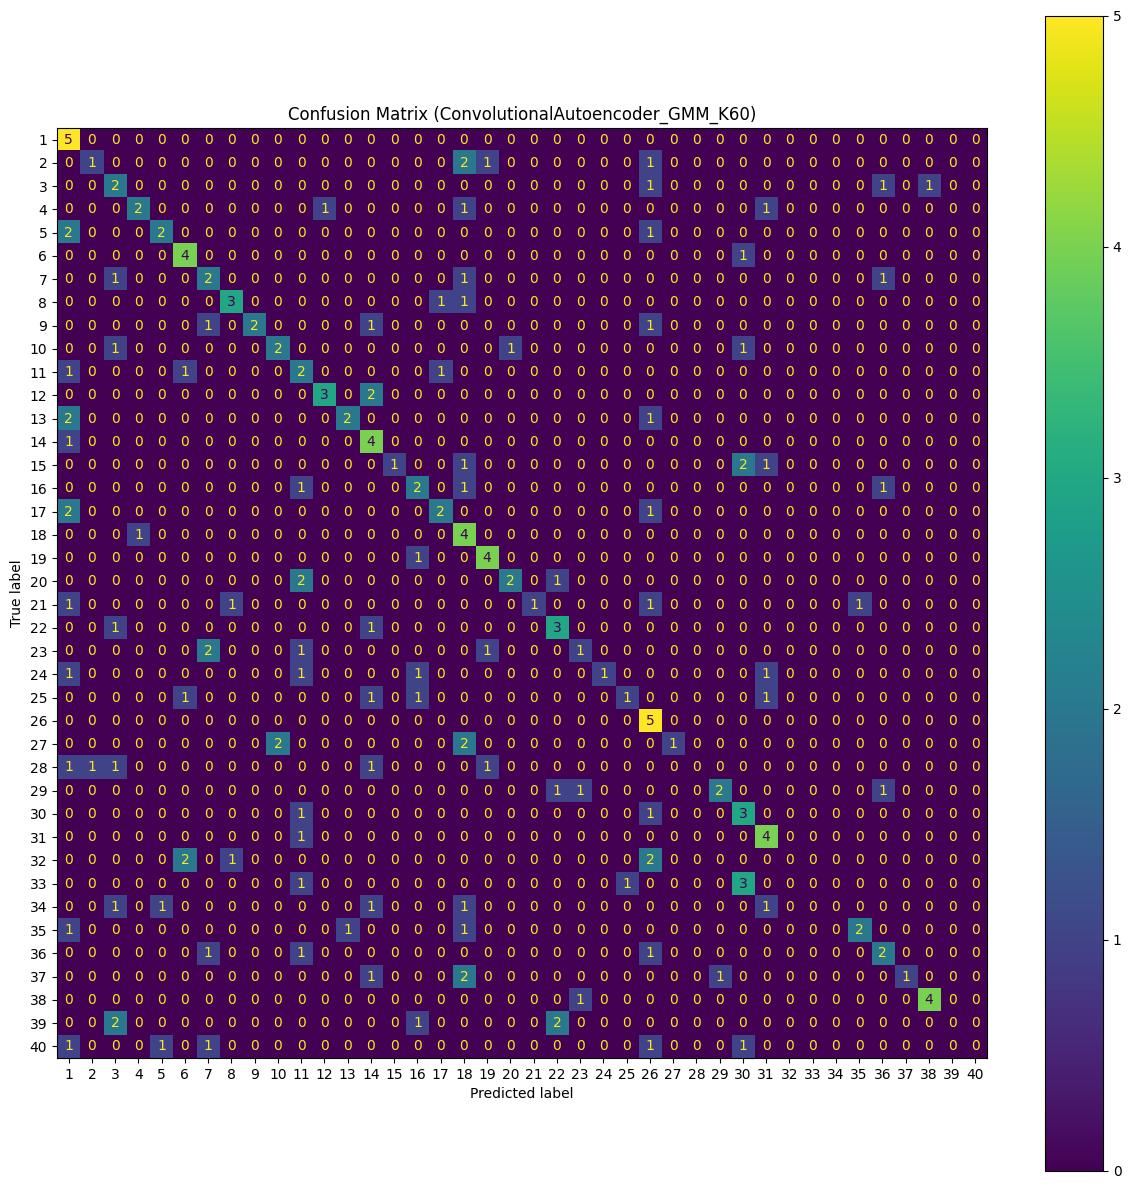



=== Evaluation Results Summary ===
PCA_alpha_0.80_KMeans_K20: Accuracy=0.4350, F1_Weighted=0.3181, F1_Macro=0.3181
PCA_alpha_0.80_KMeans_K40: Accuracy=0.6550, F1_Weighted=0.6160, F1_Macro=0.6160
PCA_alpha_0.80_KMeans_K60: Accuracy=0.7900, F1_Weighted=0.7630, F1_Macro=0.7630
PCA_alpha_0.80_GMM_K20: Accuracy=0.2800, F1_Weighted=0.1845, F1_Macro=0.1845
PCA_alpha_0.80_GMM_K40: Accuracy=0.4000, F1_Weighted=0.3320, F1_Macro=0.3320
PCA_alpha_0.80_GMM_K60: Accuracy=0.4850, F1_Weighted=0.4591, F1_Macro=0.4591
PCA_alpha_0.85_KMeans_K20: Accuracy=0.4750, F1_Weighted=0.3479, F1_Macro=0.3479
PCA_alpha_0.85_KMeans_K40: Accuracy=0.6450, F1_Weighted=0.6014, F1_Macro=0.6014
PCA_alpha_0.85_KMeans_K60: Accuracy=0.7550, F1_Weighted=0.7411, F1_Macro=0.7411
PCA_alpha_0.85_GMM_K20: Accuracy=0.2300, F1_Weighted=0.1298, F1_Macro=0.1298
PCA_alpha_0.85_GMM_K40: Accuracy=0.3850, F1_Weighted=0.3205, F1_Macro=0.3205
PCA_alpha_0.85_GMM_K60: Accuracy=0.4550, F1_Weighted=0.4209, F1_Macro=0.4209
PCA_alpha_0.90_KMeans

In [36]:
for proj_name, (projector_inst, proj_kwargs) in projectors.items():
    for cls_name, classifier_inst in classifiers.items():
        
        exp_name = f"{proj_name}_{cls_name}"
        print(f"\n----- Running Experiment: {exp_name} -----")

        metrics = evaluate_projection_classification(
            projector=projector_inst,
            classifier=classifier_inst,
            D_train_orig=D_train,
            y_train=y_train,
            D_test_orig=D_test,
            y_test=y_test,
            projection_kwargs=proj_kwargs,
            exp_name=exp_name
        )
        results[exp_name] = metrics

    # ==================================================
    # Display Final Results Summary
    # ==================================================
    print("\n\n=== Evaluation Results Summary ===")
    for exp_name, metrics in results.items():
        print(f"{exp_name}: Accuracy={metrics['accuracy']:.4f}, F1_Weighted={metrics['f1_weighted']:.4f}, F1_Macro={metrics['f1_macro']:.4f}")

In [37]:
# Get both best kmeans and gmm models based on accuracy
best_kmeans = None
best_gmm = None

for exp_name, metrics in results.items():
    if "KMeans" in exp_name and (best_kmeans is None or metrics['accuracy'] > results[best_kmeans]['accuracy']):
        best_kmeans = exp_name
    elif "GMM" in exp_name and (best_gmm is None or metrics['accuracy'] > results[best_gmm]['accuracy']):
        best_gmm = exp_name
print(f"\nBest KMeans Model: {best_kmeans} with accuracy {results[best_kmeans]['accuracy']:.4f}")
print(f"Best GMM Model: {best_gmm} with accuracy {results[best_gmm]['accuracy']:.4f}")


Best KMeans Model: PCA_alpha_0.90_KMeans_K60 with accuracy 0.8150
Best GMM Model: PCA_alpha_0.80_GMM_K60 with accuracy 0.4850


In [38]:
# test the best kmeans model on the test set
kmeans_projector, kmeans_kwargs = projectors["PCA_alpha_0.90"]
kmeans_classifier = classifiers["KMeans_K60"]

kmeans_classifier.fit(kmeans_projector.project(D_train, alpha=kmeans_kwargs['alpha']), y_train)
y_pred_test_kmeans = kmeans_classifier.predict(kmeans_projector.project(D_test, alpha=kmeans_kwargs['alpha']))

# test the best gmm model on the test set
gmm_projector, gmm_kwargs = projectors["PCA_alpha_0.80"]
gmm_classifier = classifiers["GMM_K60"]

# project the data
D_train_proj = gmm_projector.project(D_train, alpha=gmm_kwargs['alpha'])
# normalize the data
D_train_proj_standard = (D_train_proj - np.mean(D_train_proj, axis=0)) / np.std(D_train_proj, axis=0)

gmm_classifier.fit(D_train_proj_standard, y_train)

# project the test data
D_test_proj = gmm_projector.project(D_test, alpha=gmm_kwargs['alpha'])
# normalize the test data
D_test_proj_standard = (D_test_proj - np.mean(D_train_proj, axis=0)) / np.std(D_train_proj, axis=0)
y_pred_test_gmm = gmm_classifier.predict(D_test_proj_standard)

Converged at iteration 13 for random start 0
Converged at iteration 13 for random start 1
Converged at iteration 45 for random start 2
Converged at iteration 31 for random start 3
Converged at iteration 13 for random start 4
Converged at iteration 46 for random start 5
Converged at iteration 22 for random start 6
Converged at iteration 26 for random start 7
Converged at iteration 47 for random start 8
Converged at iteration 35 for random start 9
Converged at iteration 47 for random start 10
Converged at iteration 16 for random start 11
Converged at iteration 23 for random start 12
Converged at iteration 23 for random start 13
Converged at iteration 40 for random start 14
Converged at iteration 23 for random start 15
Converged at iteration 20 for random start 16
Converged at iteration 33 for random start 17
Converged at iteration 37 for random start 18
Converged at iteration 26 for random start 19
Model fitted successfully.
Best log likelihood: -3768.3274397971263
Best random start: 19




=== Evaluation on Test Set ===
Best KMeans Model: PCA_alpha_0.90_KMeans_K60 with accuracy 0.8150
Test Accuracy: 0.7350
Test F1 Score (Weighted): 0.7122
Test F1 Score (Macro): 0.7122


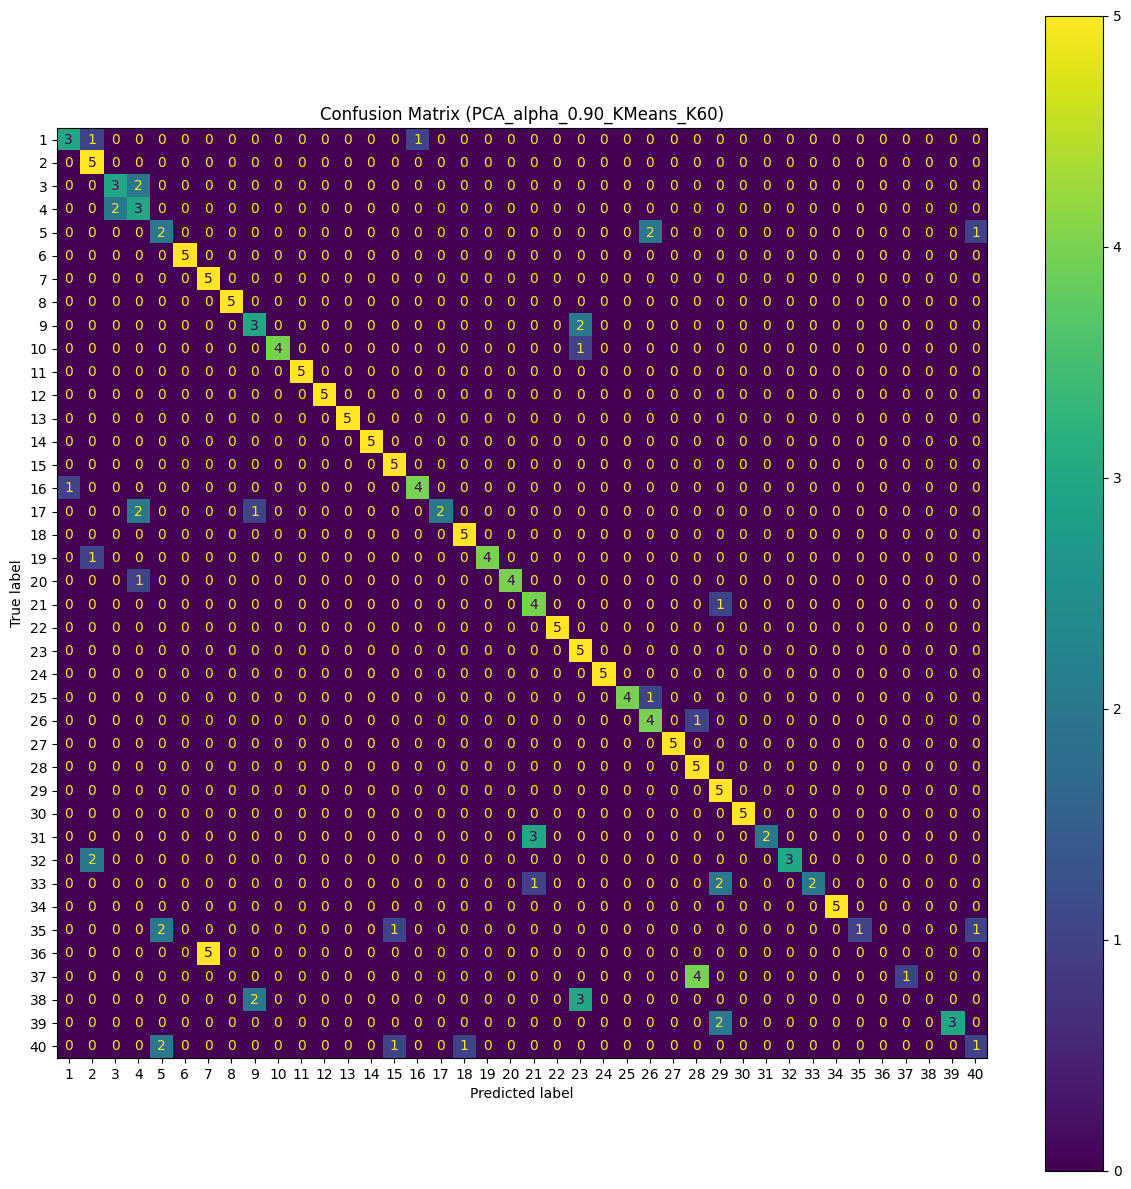

Best GMM Model: PCA_alpha_0.80_GMM_K60 with accuracy 0.4850
Test Accuracy: 0.3750
Test F1 Score (Weighted): 0.3188
Test F1 Score (Macro): 0.3188


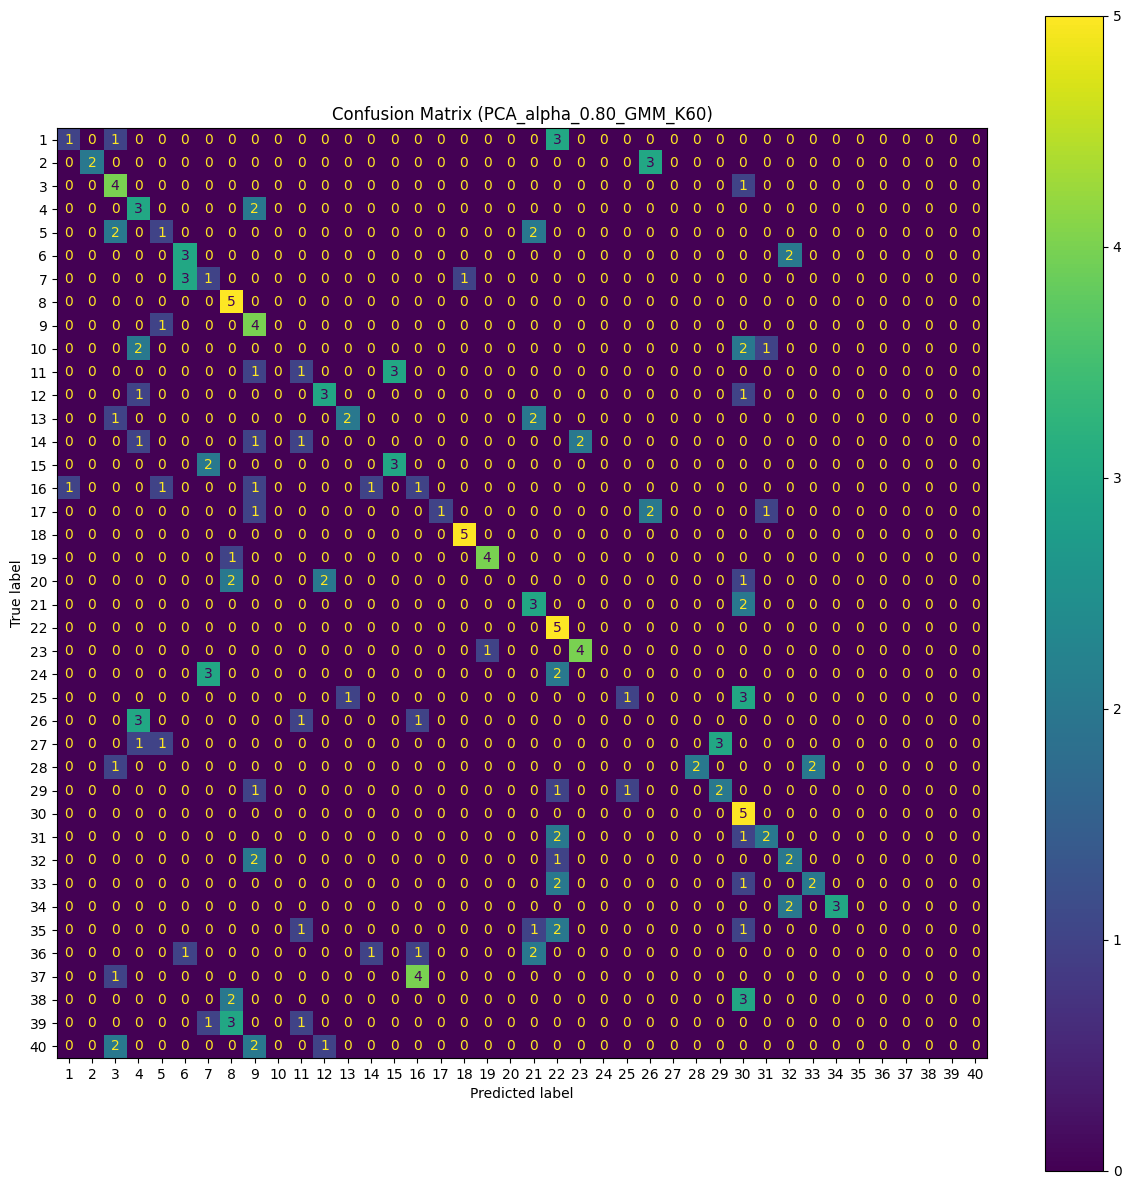

{'accuracy': 0.375,
 'f1_weighted': 0.3188378591783323,
 'f1_macro': 0.3188378591783323}

In [39]:
def evaluate_test_labels(y_test, y_pred_test, exp_name):
    """
    Evaluates the test labels against the predicted labels.

    Args:
        y_test: True test labels.
        y_pred_test: Predicted test labels.
        exp_name: Name of the experiment.

    Returns:
        dict: Dictionary containing evaluation metrics ('accuracy', 'f1_weighted', 'f1_macro').
    """
    accuracy = accuracy_score(y_test, y_pred_test)
    f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Test F1 Score (Macro): {f1_macro:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test, labels=np.arange(1, NUM_SUBJECTS + 1)) # Assuming labels are 1 to num_subjects
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, NUM_SUBJECTS + 1))
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(ax=ax, cmap='viridis')
    plt.title(f"Confusion Matrix ({exp_name})")
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }

print("\n\n=== Evaluation on Test Set ===")
print(f"Best KMeans Model: {best_kmeans} with accuracy {results[best_kmeans]['accuracy']:.4f}")
evaluate_test_labels(y_test, y_pred_test_kmeans, best_kmeans)
print(f"Best GMM Model: {best_gmm} with accuracy {results[best_gmm]['accuracy']:.4f}")
evaluate_test_labels(y_test, y_pred_test_gmm, best_gmm)